In [5]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot
import matplotlib.animation as animation 
from JSAnimation.IPython_display import display_animation
import math
import itertools as itool

##THIS CELL WILL DEFINE THE CLASSES EMPLOYED

class BoundaryCondition:
    RBC, PBC = range(2)
    
    
    
class StartConf:
    Triangular, Rectangular, Random, Confined = range(4)
    
    
    
class particle(object):
    
    def __init__(self, m=1., x=0., y=0., vx=0., vy=0., fx=0., fy=0.):
        self.m=m
        self.x=x
        self.y=y
        self.vx=vx
        self.vy=vy
        self.fx=fx
        self.fy=fy
    
    def update_force(self, fx, fy):
        self.fx=fx
        self.fy=fy
    
    def accel(self, dt):
        self.vx=self.vx+self.fx/self.m * dt
        self.vy=self.vy+self.fy/self.m * dt
    
    def move(self, dt):
        self.x=self.x+self.vx*dt
        self.y=self.y+self.vy*dt
    
    def move_2(self, dt, dtsquaredhalf):
        self.move(dt)
        self.x=self.x+self.fx/self.m * dtsquaredhalf
        self.y=self.x+self.fy/self.m * dtsquaredhalf
        
    def euler(self, dt):
        self.accel(dt)
        self.move(dt)
        
        
        
        
        
class system(object):
    
    def __init__(self, lx, ly, N, dt, bc, KE=0., PE=0.):
        self.lx=lx
        self.ly=ly
        self.N=N
        self.dt=dt
        self.bc=bc
        self.KE=KE
        self.PE=PE
        self.E=KE+PE
        self.dtsquared=dt*dt
        self.dthalf= self.dt *.5
        self.dtsquaredhalf=self.dtsquared*.5
        self.particles=[particle()]
        for i in range(0, N-1):
            self.particles.append(particle())
            
            
    def distance2(self, p1, p2):
        dx = p2.x - p1.x;
        dy = p2.y - p1.y;
        # nearest image convention
        if self.bc == BoundaryCondition.PBC:
            if abs(dx) > self.lx/2:
                dx -= dx*self.lx/abs(dx)
                
            if abs(dy) > self.ly/2:
                dy -= dy*self.ly/abs(dy)
        
        r12 = dx * dx + dy * dy
        return (r12, dx, dy)
    
            
    def distance(self, p1, p2):
        (r12, dx, dy) = self.distance2(p1, p2)
        return math.sqrt(r12)
    

    def force(self, p1, p2):  #Lennard-Jones
        (r12,dx,dy) = self.distance2(p1, p2)
        if r12!=0: #difference!!!
            u2 = 1./r12
            u6 = u2 * u2 * u2
            f = 24.*u2*u6*(2.*u6-1.)
            fx = f*(-dx)
            fy = f*(-dy)
        else:
            fx=0.
            fy=0.
        return (fx, fy);
    
    
    def forces(self):
        # Compute the interaction forces between particles
        for p in self.particles:
            p.fx = 0.
            p.fy = 0.
    
        for i in range(self.N):
            p1 = self.particles[i]
            for j in range(i+1,self.N):
                p2 = self.particles[j]
                (fx, fy) = self.force(p1, p2)
                p1.fx += fx
                p1.fy += fy
                p2.fx -= fx
                p2.fy -= fy
                

    def boundary(self, p):
        if self.bc == BoundaryCondition.RBC:
            
            if p.x < 0:  
                p.x = -p.x
                p.vx = -p.vx
            if p.y < 0:
                p.y = -p.y
                p.vy = -p.vy
            if p.x > self.lx:
                p.x = 2*self.lx - p.x
                p.vx = -p.vx
            if p.y > self.ly:
                p.y = 2*self.ly - p.y
                p.vy = -p.vy
                

        elif self.bc == BoundaryCondition.PBC:

            if p.x < 0: 
                p.x += lx
            elif p.x > lx:  
                p.x -= lx
            if p.y < 0:  
                p.y += ly
            elif p.y > ly:  
                p.y -= ly
#            c = (p.x+2*self.lx)/self.lx
#            p.x = p.x + 2*self.lx - int(c)*self.lx
#            c = (p.y+2*self.ly)/self.ly
#            p.y = p.y + 2*self.ly - int(c)*self.ly
             
        if abs(p.y)>ly or abs(p.x)>lx:
            #print "error particle leaving array"
            

    def Calc_KE(self):
        ke=0
        for p in self.particles:
            ke +=.5*p.m*(p.vx**2+p.vy**2)
        self.KE=ke
    
    def Calc_PE(self):
        pe = 0. #assuming Lenard-Jones
        #for p1 in self.particles:
            #for p2 in self.particles:
        for i in range(self.N):
            p1=self.particles[i]
            for j in range(i+1, self.N):
                p2=self.particles[j]
                (r12,dx,dy) = self.distance2(p1, p2)
                if (r12!=0.):
                    u2 = 1./r12
                    u6 = u2 * u2 * u2
                    pe += 4.*u6*(1-u6)
        self.PE=pe
    
    def total_energy(self):
        self.Calc_KE()
        self.Calc_PE()
        self.E=self.KE+self.PE

    
    def initconfig(self, config, vmax, cm_vx=0., cm_vy=0.):
        np.random.seed(1272121)
        ncols=int(math.sqrt(N*float(self.lx)/float(self.ly)))
        nrows=int(math.sqrt(N*float(self.ly)/float(self.lx)))
        ax=float(self.lx)/float(ncols)
        ay=float(self.ly)/float(nrows)
        
        i=0
        
        if config == StartConf.Triangular:
            #Challenge
            return
        elif config == StartConf.Rectangular:
            for row, col in itool.product(range(nrows),range(ncols)):
                if i >= self.N: 
                    break
                self.particles[i].x = col*ax+ax/2
                self.particles[i].y = row*ay+ay/2
                i+=1

            for row, col in itool.product(range(1,nrows),range(1,ncols)):
                if i >= self.N: 
                    break
                self.particles[i].x = col*ax/2.+ax/2.
                self.particles[i].y = row*ay/2.+ay/2.
                i+=1
                
        elif config == StartConf.Confined:
            for row, col in itool.product(range(nrows),range(ncols)):
                if i >= self.N: 
                    break
                self.particles[i].x = (col*ax+ax/2.)/2.
                self.particles[i].y = (row*ay+ay/2.)
                i+=1

            for row, col in itool.product(range(1,nrows),range(1,ncols)):
                if i >= self.N: 
                    break
                self.particles[i].x = (col*ax/2.+ax/2.)/2.
                self.particles[i].y = (row*ay/2.+ay/2.)
                i+=1
                
        elif config == StartConf.Random:
            for i in range(self.N):
                overlap = True;
                while overlap:
                    overlap = False;
                    self.particles[i].x = np.random.random()*self.lx
                    self.particles[i].y = np.random.random()*self.ly
                    for j in range(i):
                        r12 = self.distance(seld.particle[i], self.particle.p[j])
                        if r12 < 1.: 
                            overlap = True;
                            break
        # Velocities
        for p in self.particles:
            p.vx = vmax*(2. * np.random.random() - 1);
            p.vy = vmax*(2. * np.random.random() - 1);

        # We set total momentum to zero
        for p in self.particles:
            cm_vx += p.vx;
            cm_vy += p.vy;
        
        cm_vx /= self.N
        cm_vy /= self.N
        for p in self.particles:
            p.vx -= cm_vx;
            p.vy -= cm_vy;
            
        self.forces()
        self.total_energy()
        
                    
    def evolve(self):
        for p in self.particles:
            p.move_2(self.dt, self.dtsquaredhalf)
            #p.move(self.dt)
            p.accel(self.dthalf)
            self.boundary(p)
           

        self.forces()
        self.total_energy()

        for p in self.particles:
            p.accel(self.dthalf)
            
    
    def equilib(self, neqilib):
        for i in range(nequilib):
            self.evolve()
            
    def NumInArea(self, ymin, ymax, xmin, xmax):
        count=0
        for p in self.particles:
            #print p.y
            #print p.x
            if p.y>ymin and p.y<ymax:
                if p.x>xmin and p.x<xmax:
                    count=count+1
                   
        return count
        

In [6]:
#Cell for initializing a specific experiment
lx = 10
ly = 10
N = 25
dt = 0.01
v0 = 3.
nsteps = 5000
nequilib=1000

S=system(lx, ly, N, dt, BoundaryCondition.RBC)
S.initconfig(StartConf.Confined, v0)
#S.equilib(nequilib)
#print S.KE
#print S.PE

x = np.zeros(N)
y = np.zeros(N)



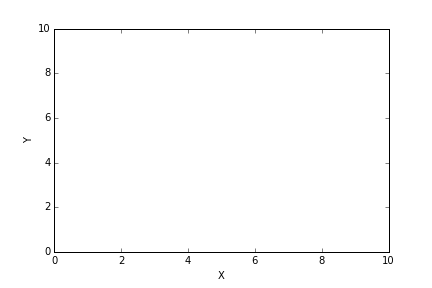
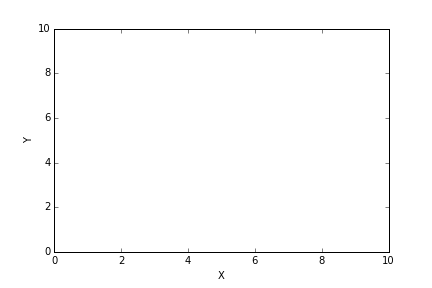
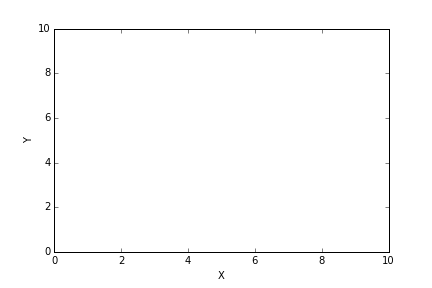
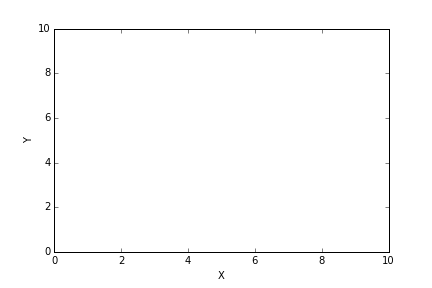
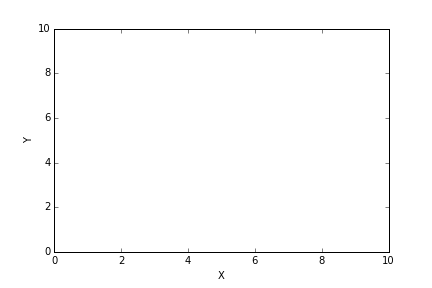
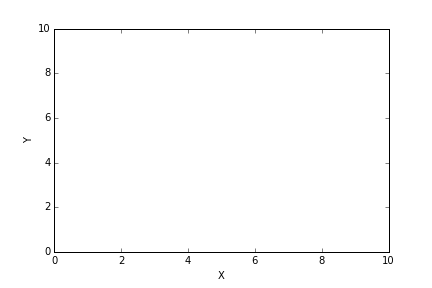
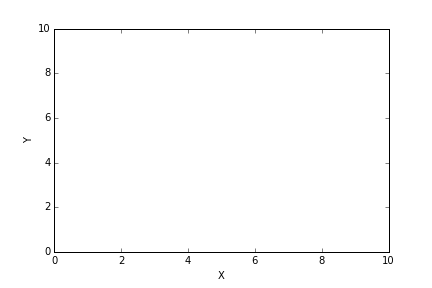
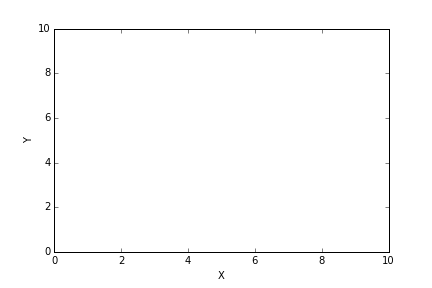
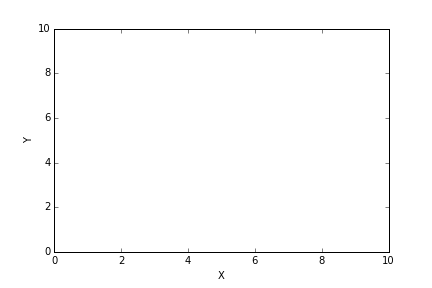
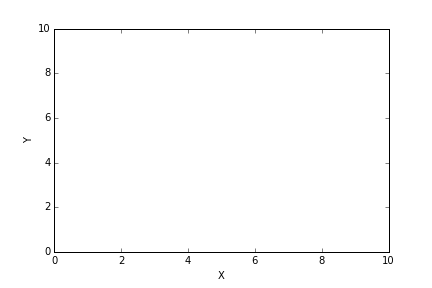
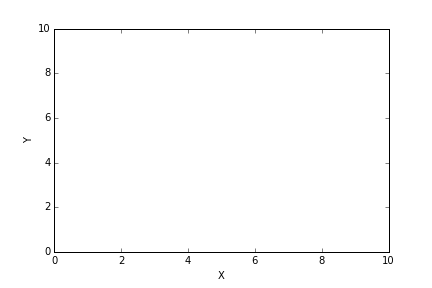
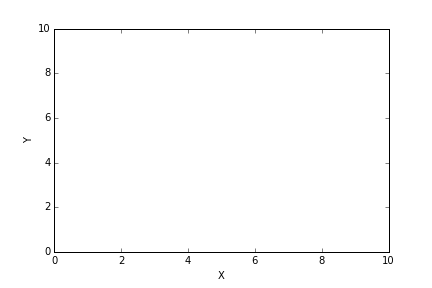
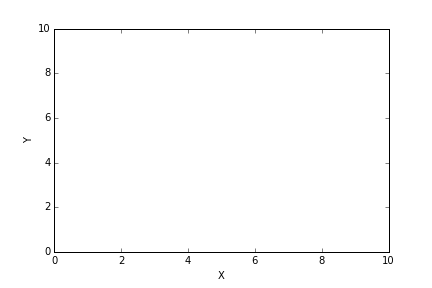
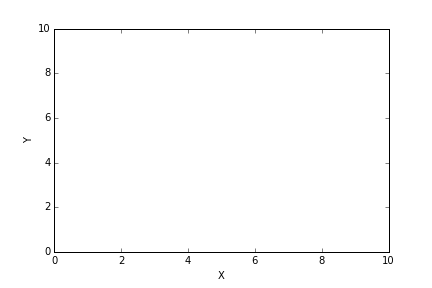
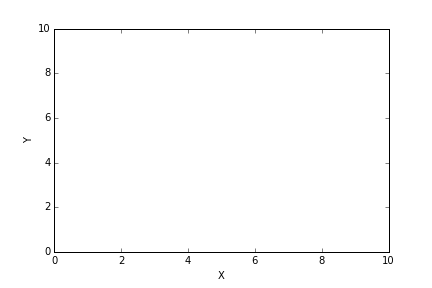
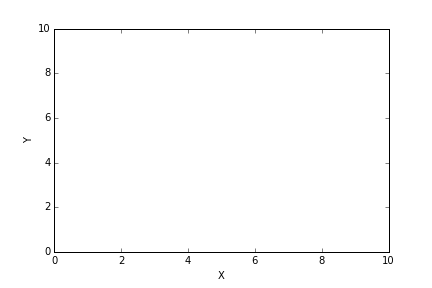
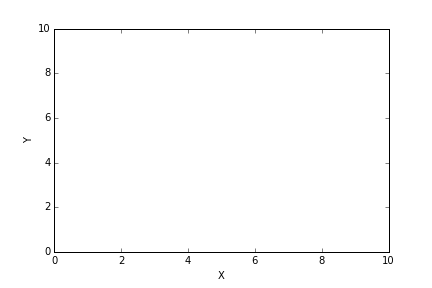
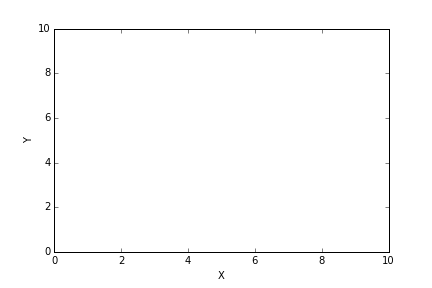
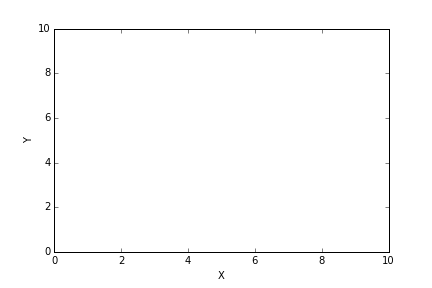
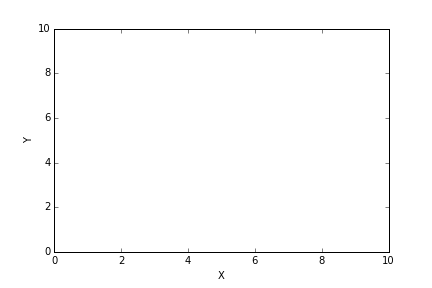
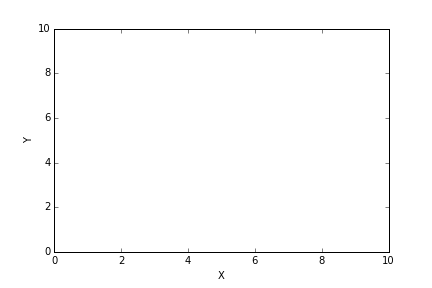
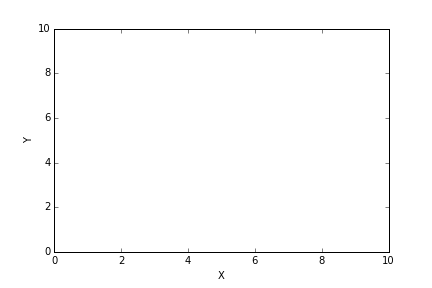
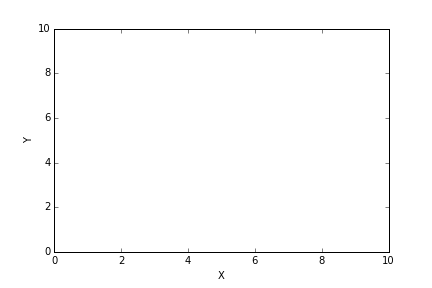
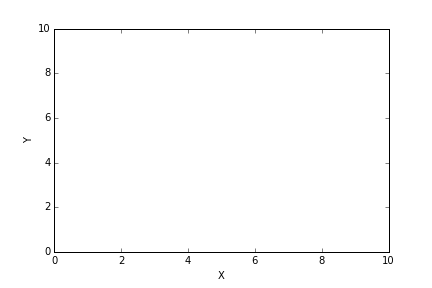
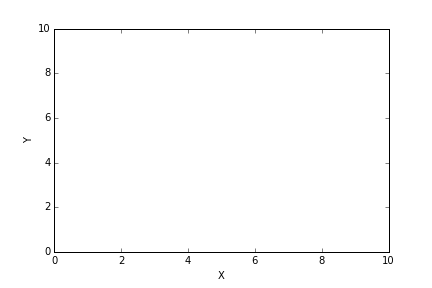
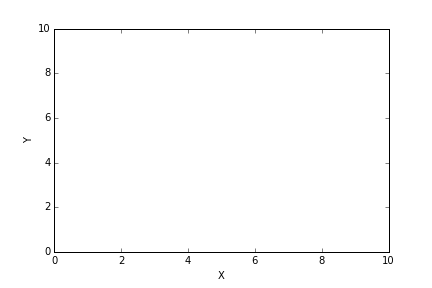
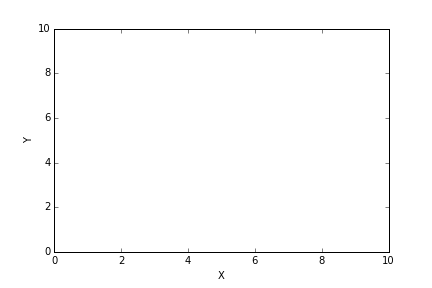
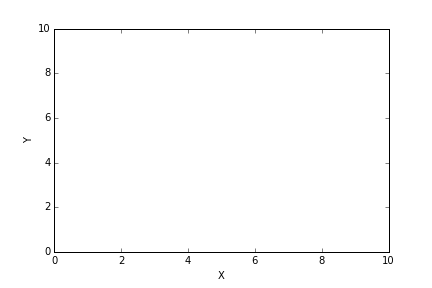
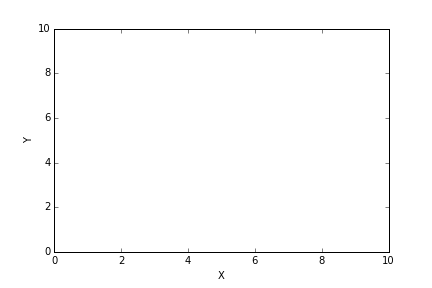
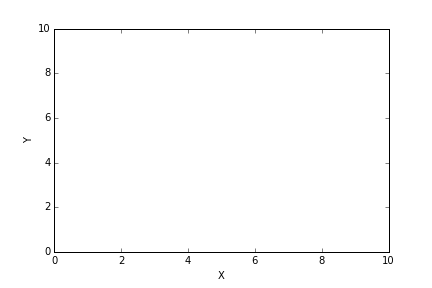
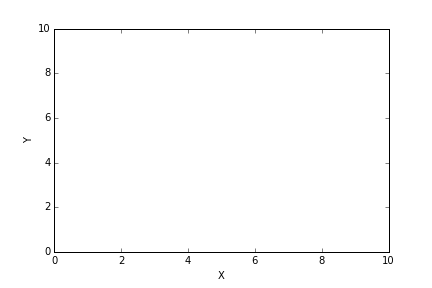
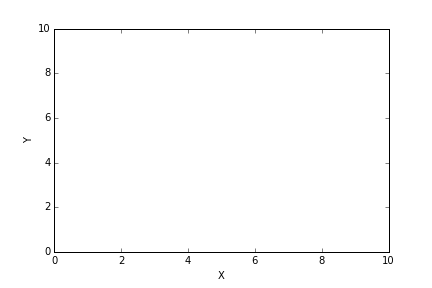
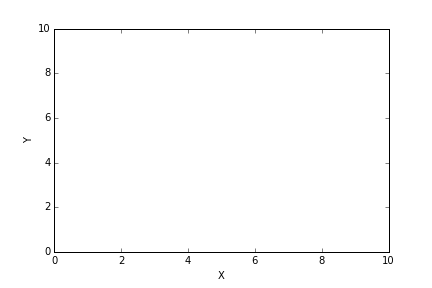
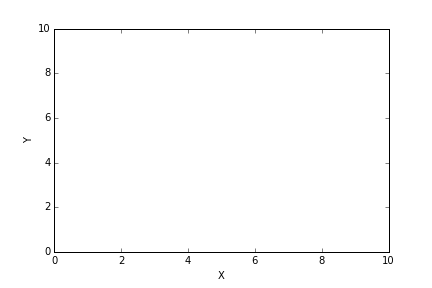
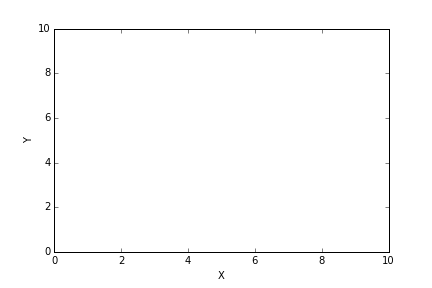
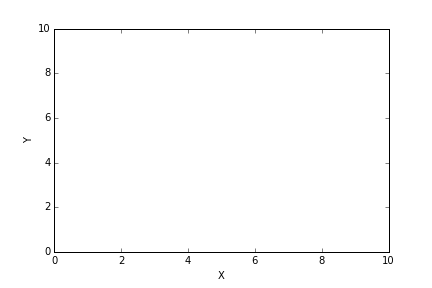
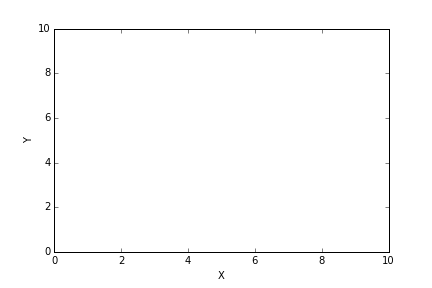
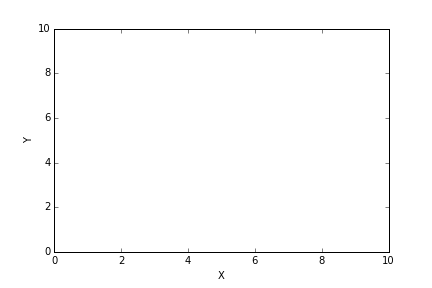
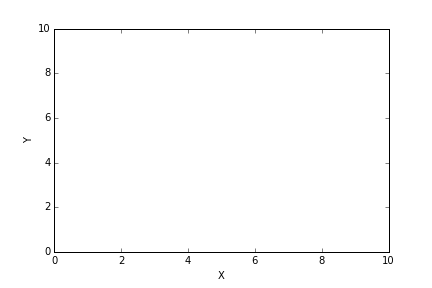
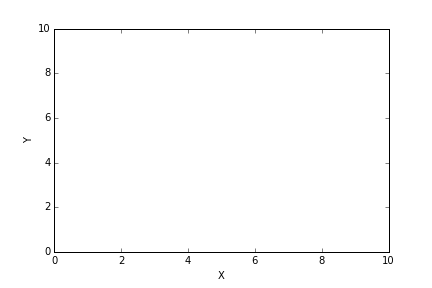
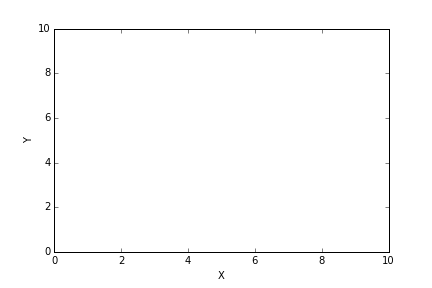
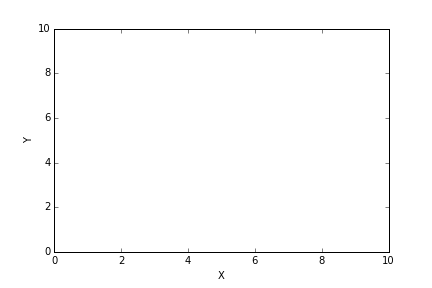
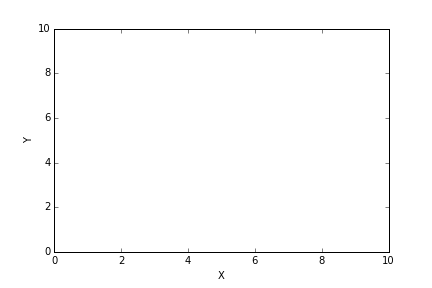
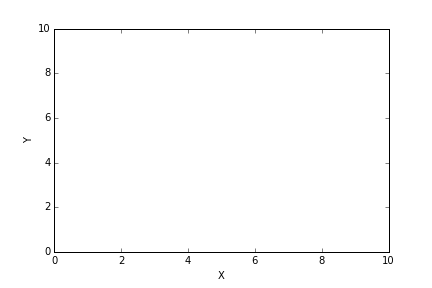
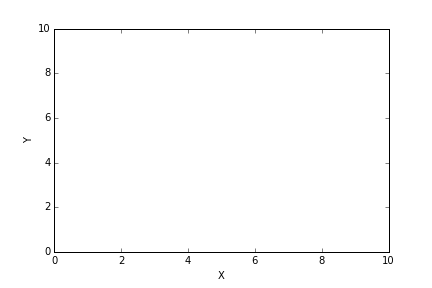
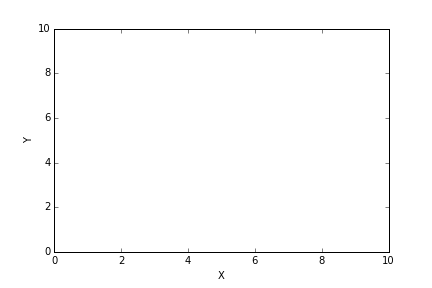
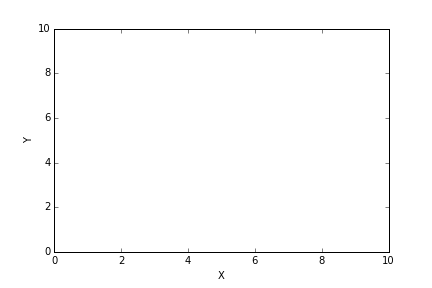
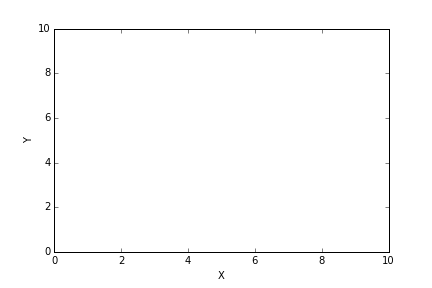
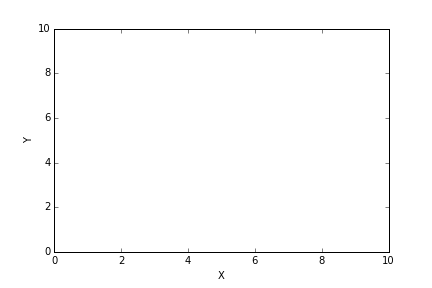
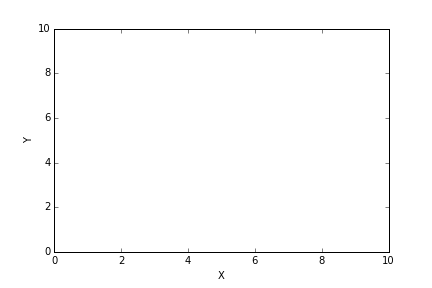
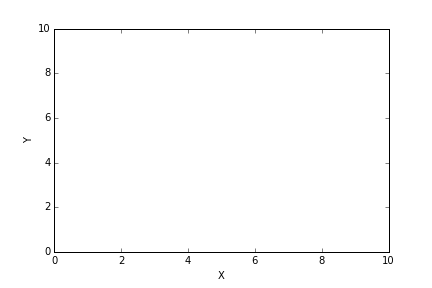
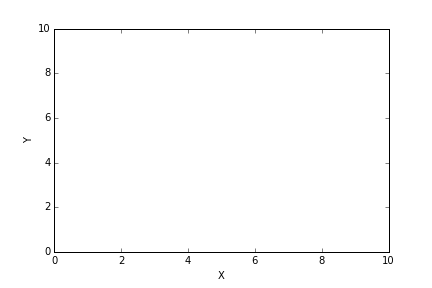
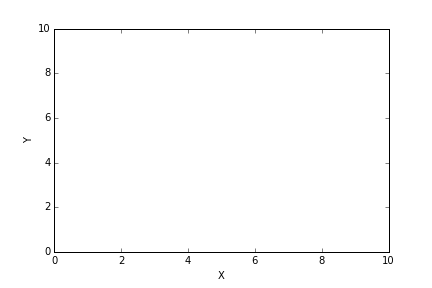
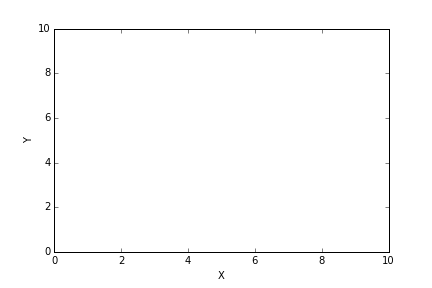
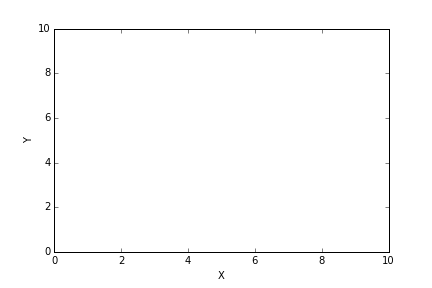
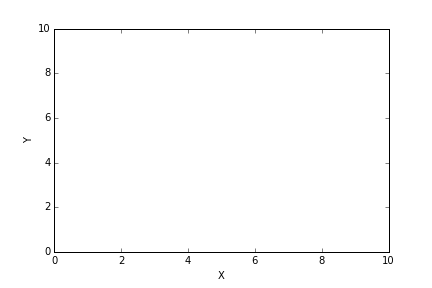
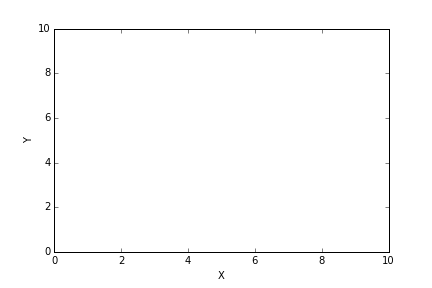
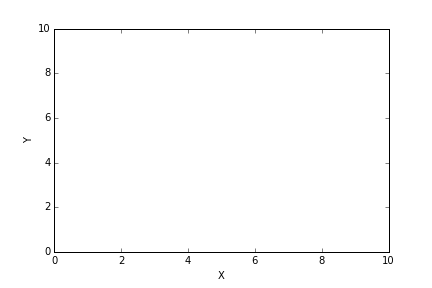
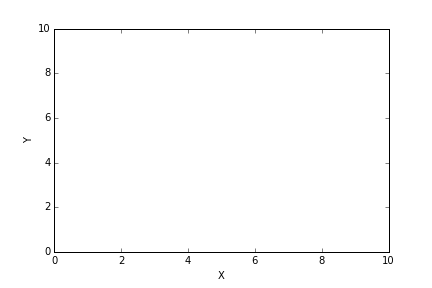
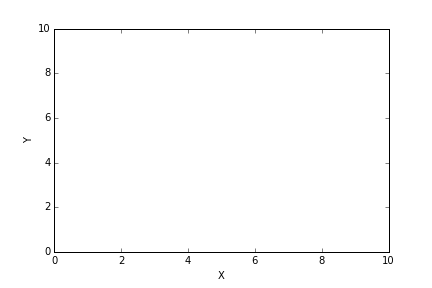
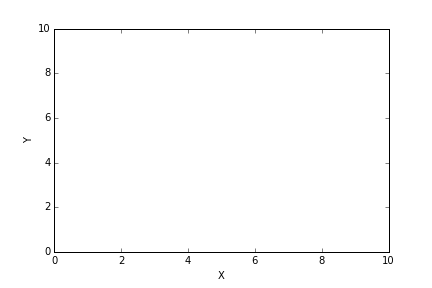
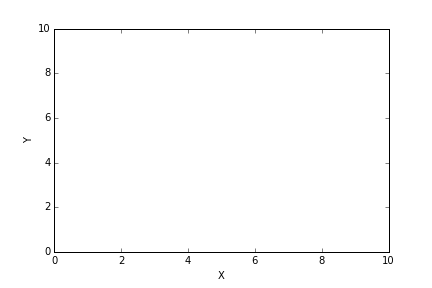
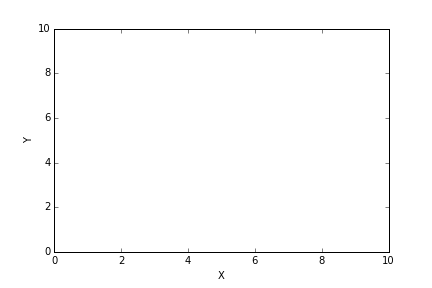
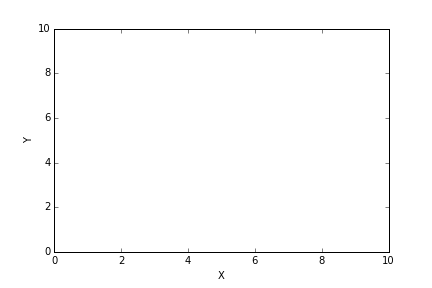
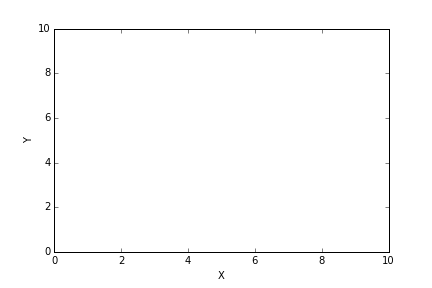
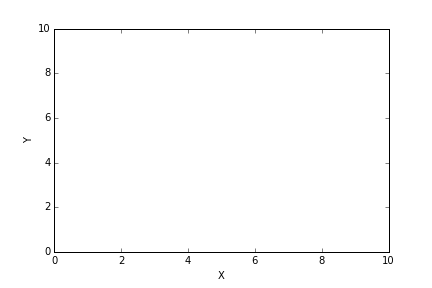
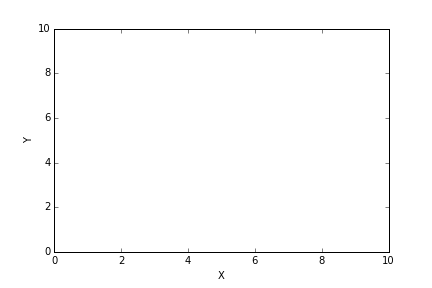
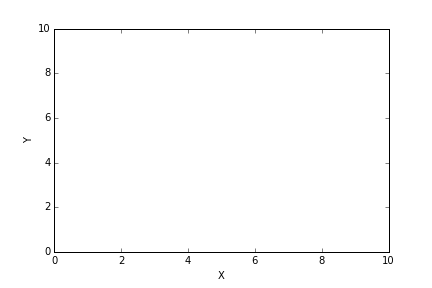
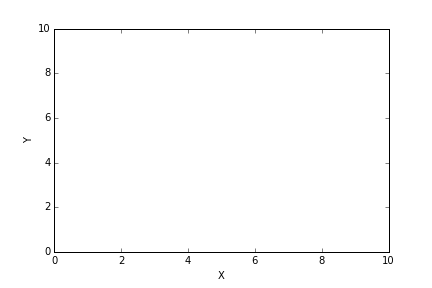
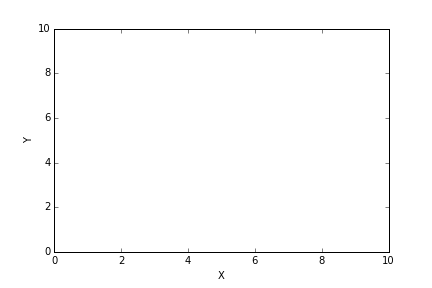
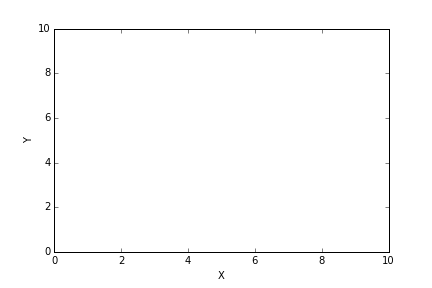
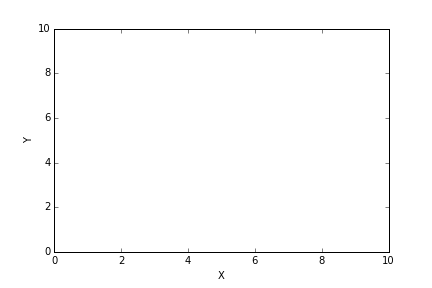
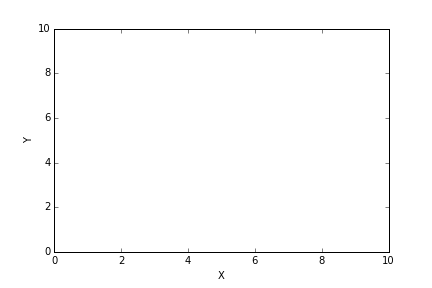
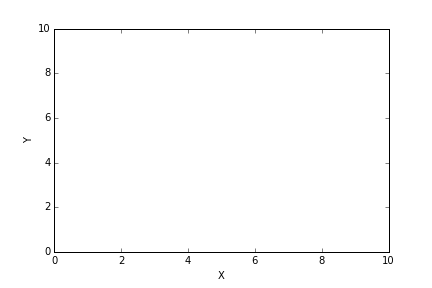
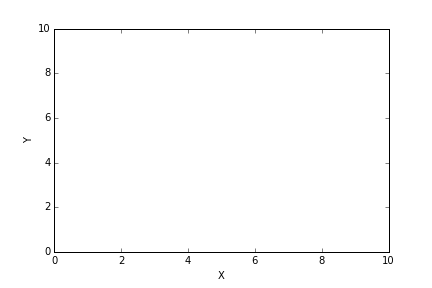
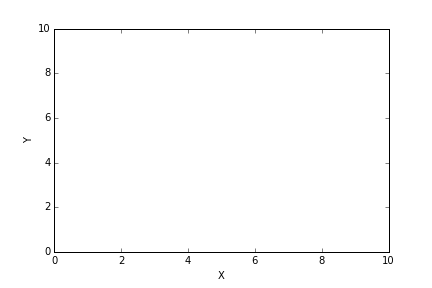
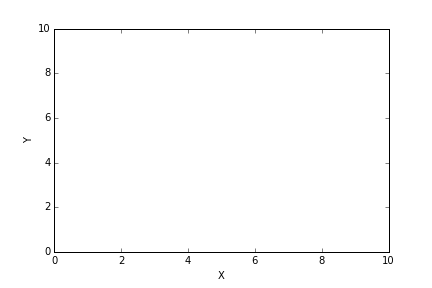
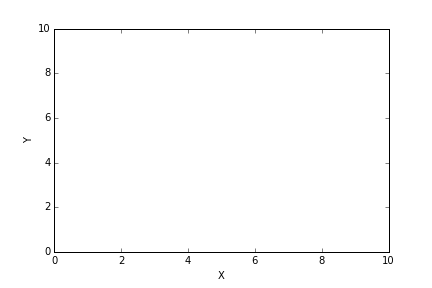
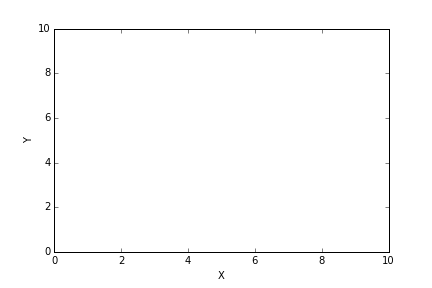
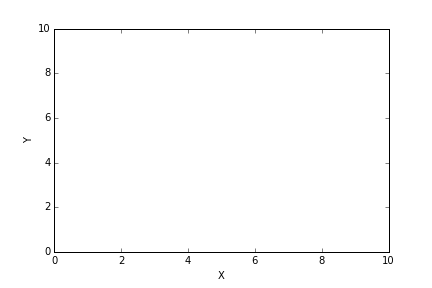
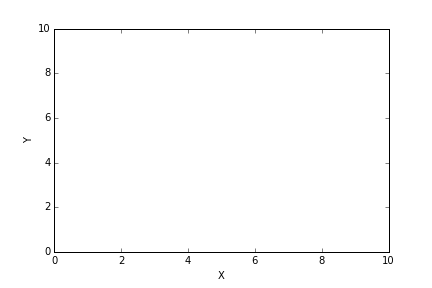
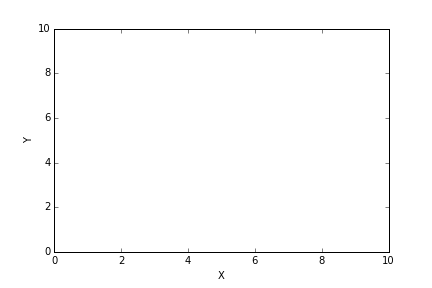
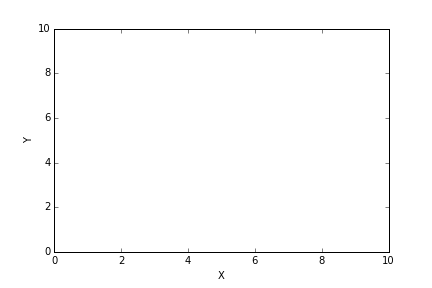
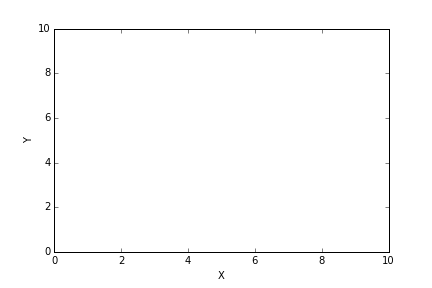
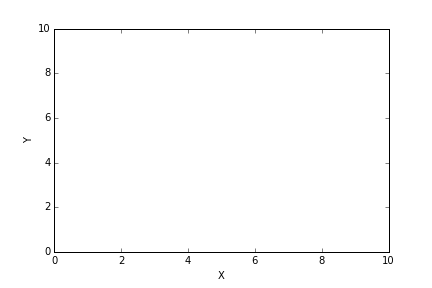
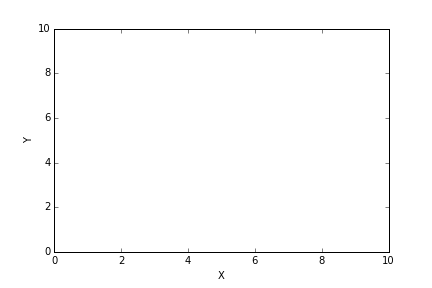
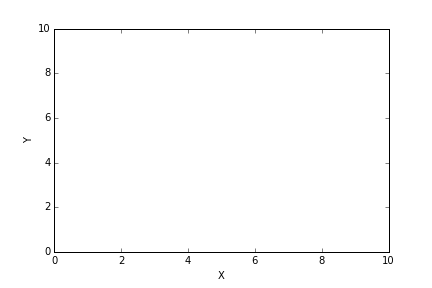
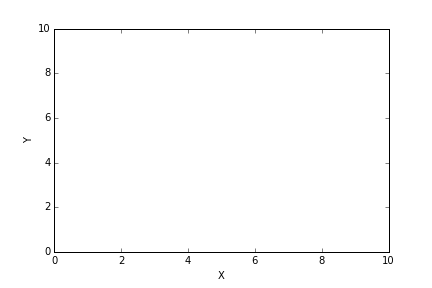
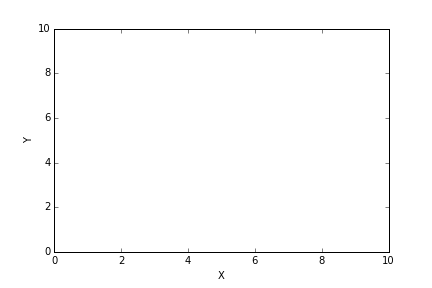
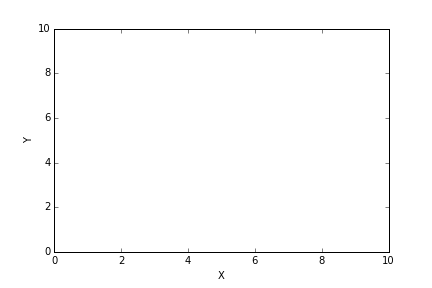
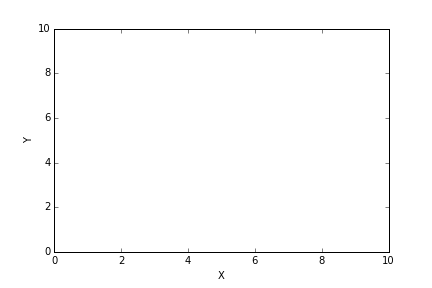
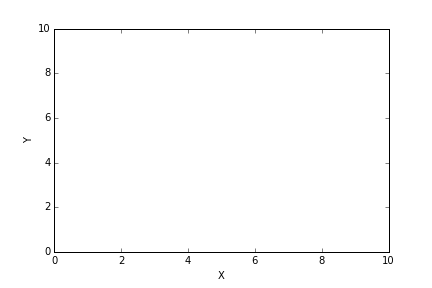
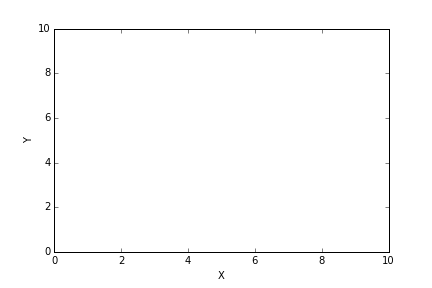
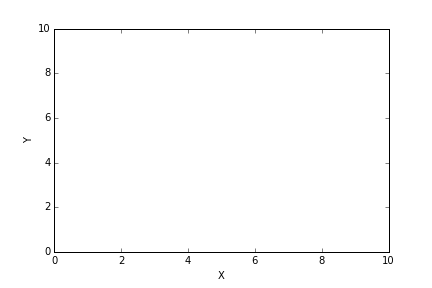
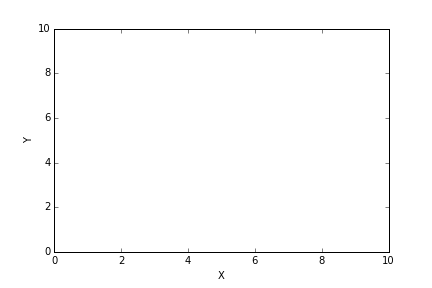
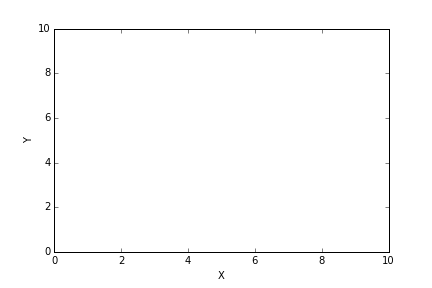
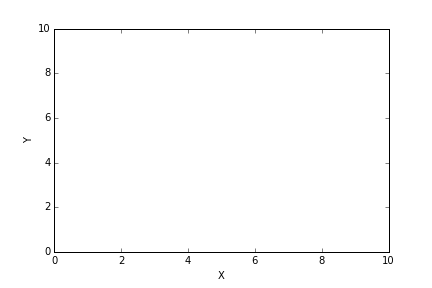
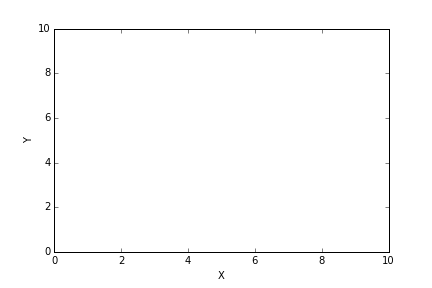
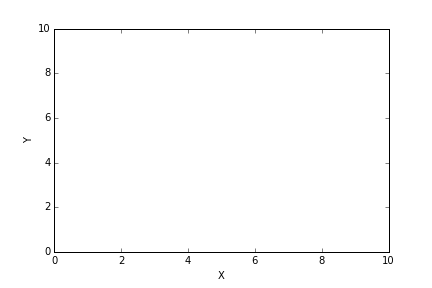
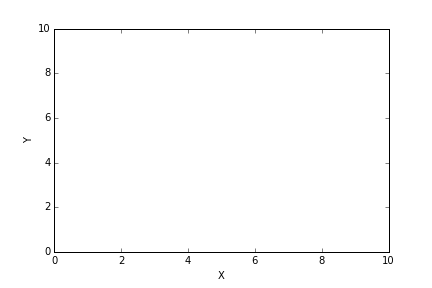
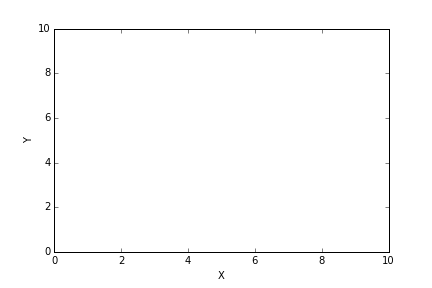
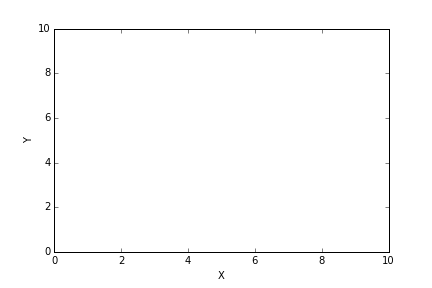
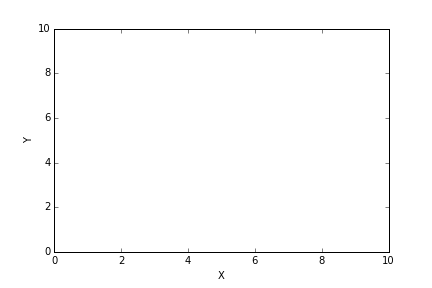
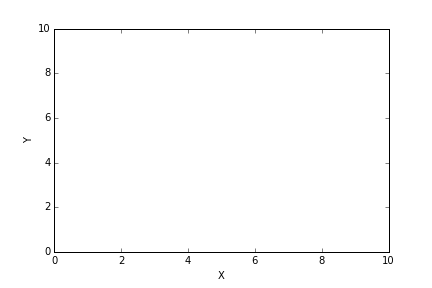
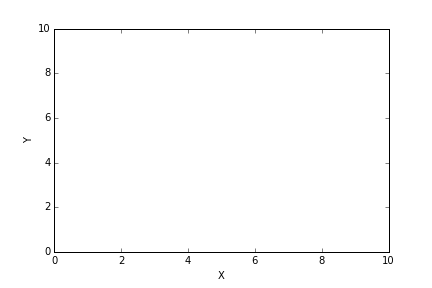
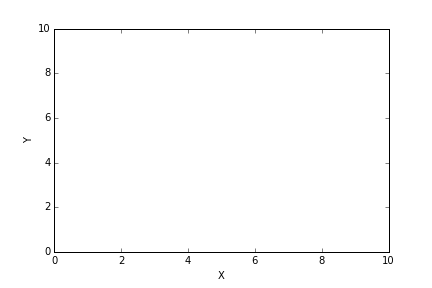
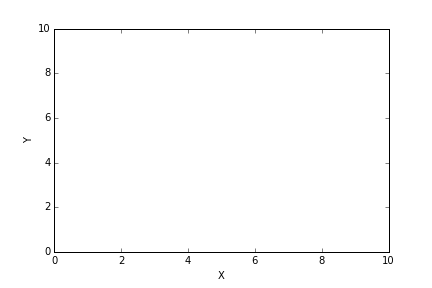
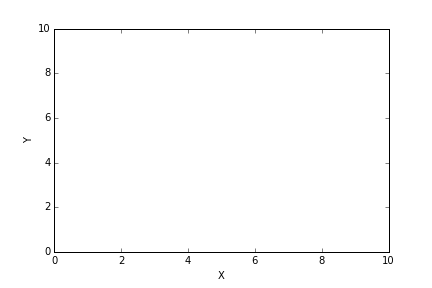
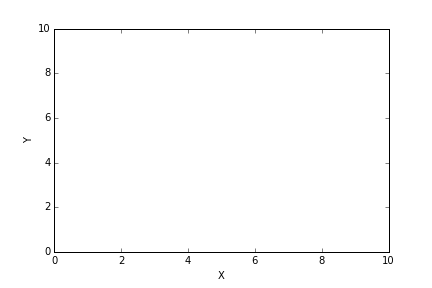
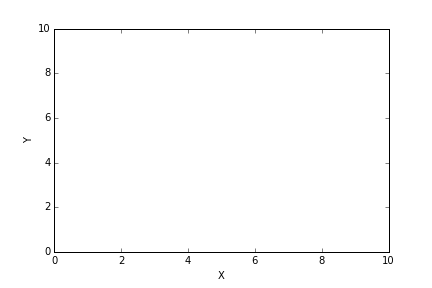
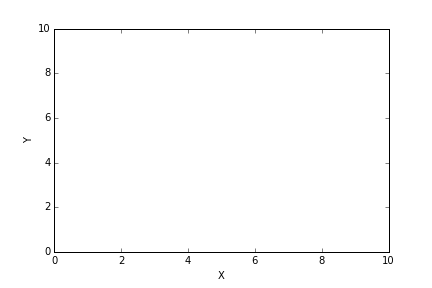
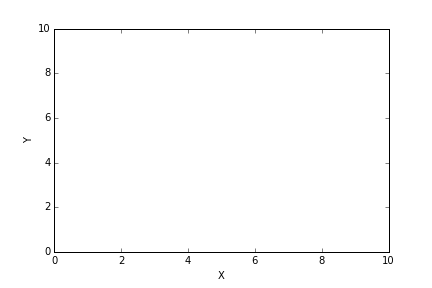
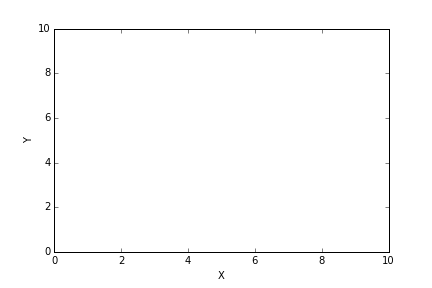
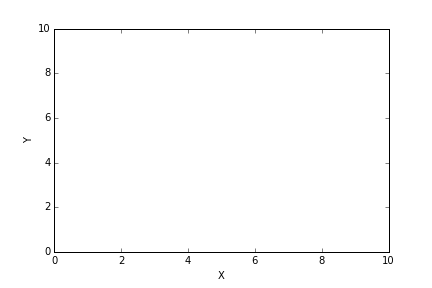
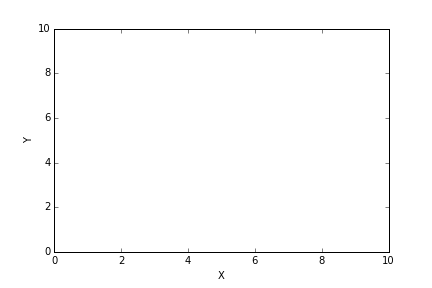
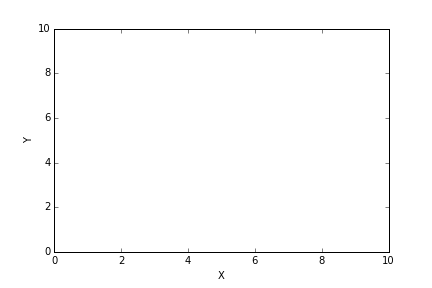
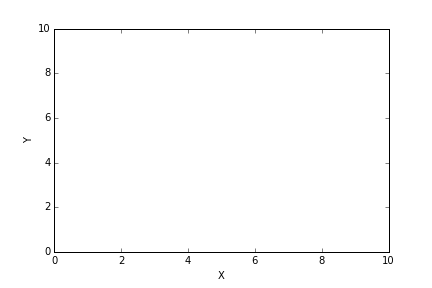
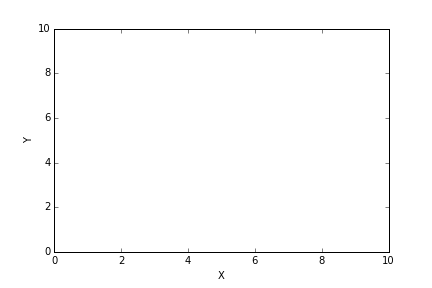
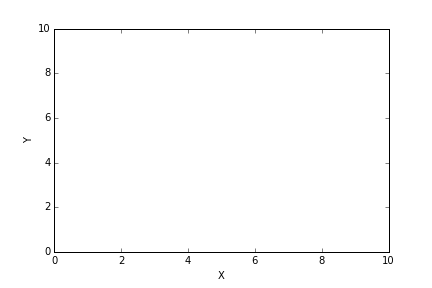
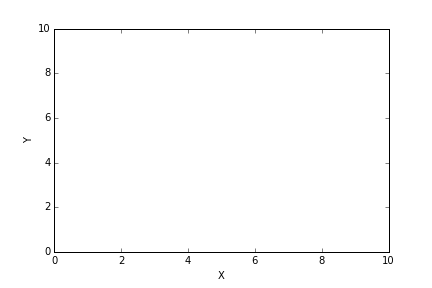
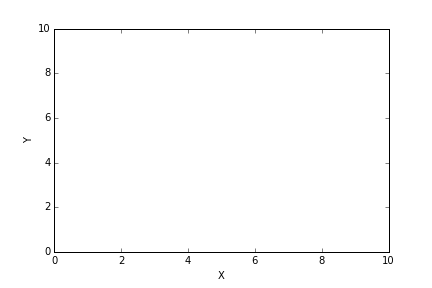
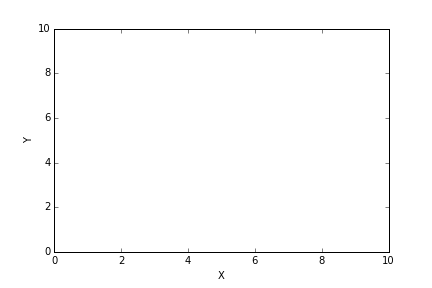
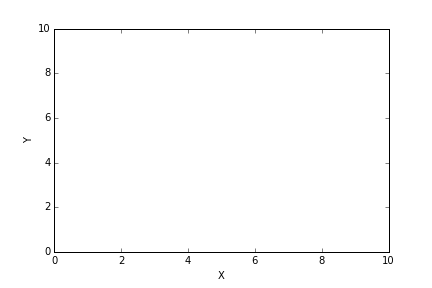
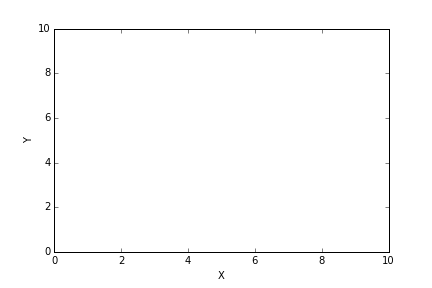
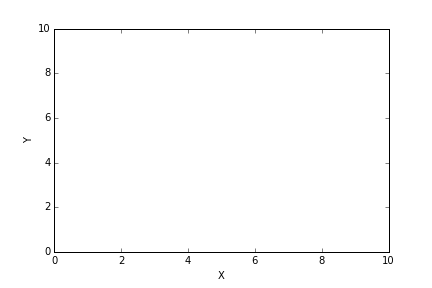
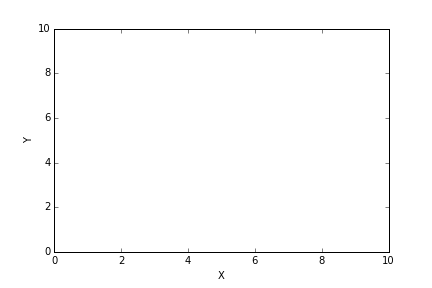
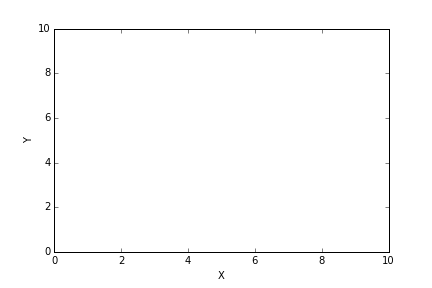
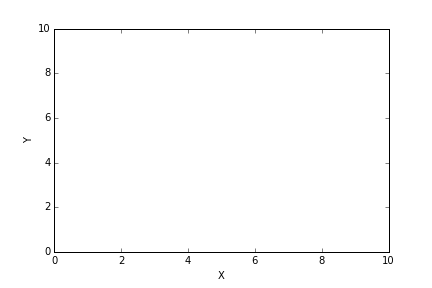
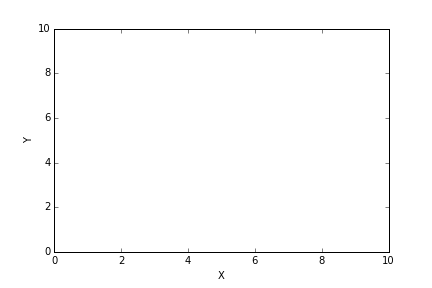
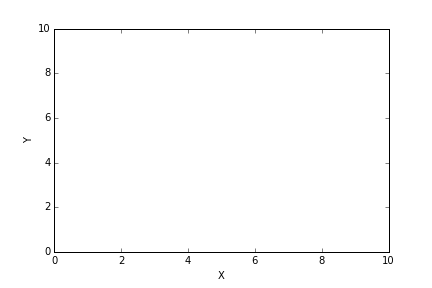
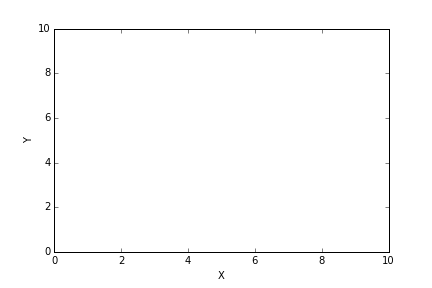
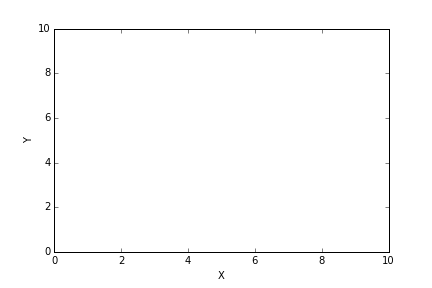
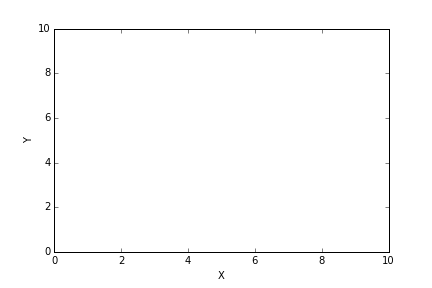
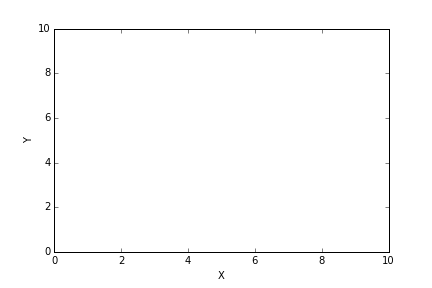
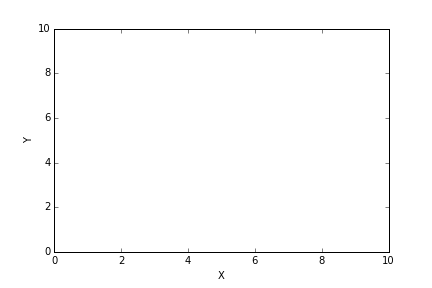
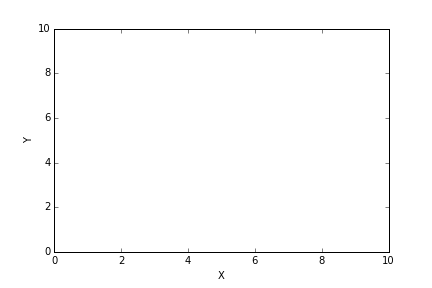
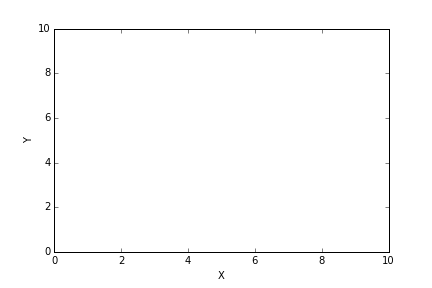
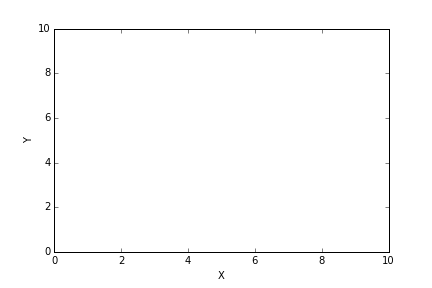
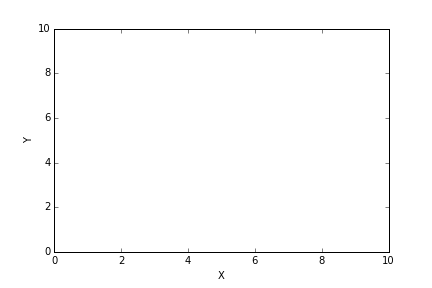
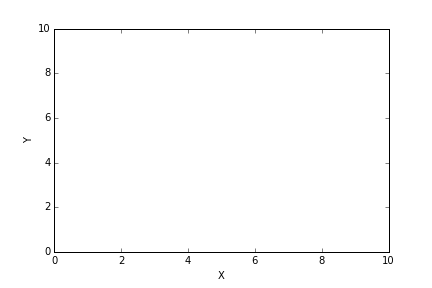
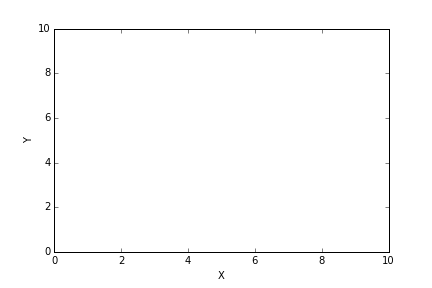
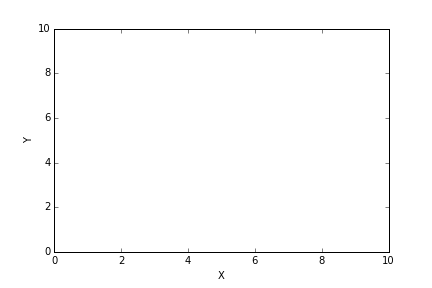
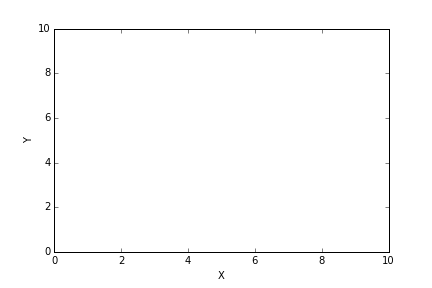
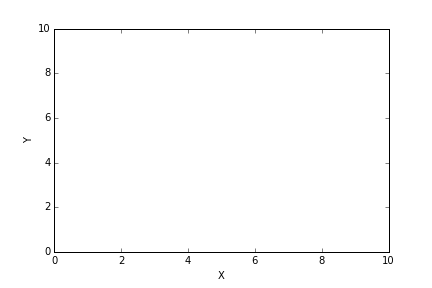
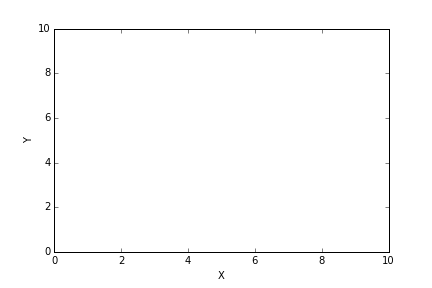
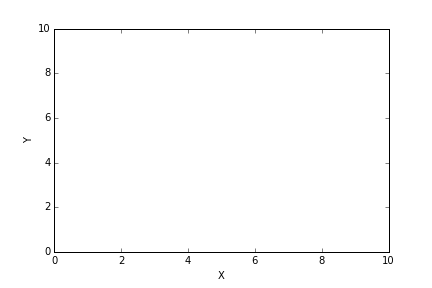
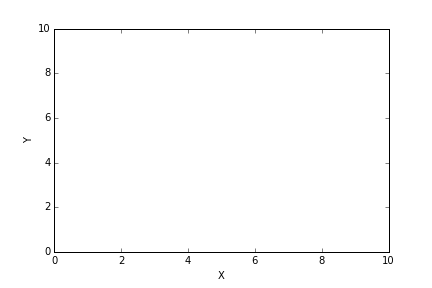
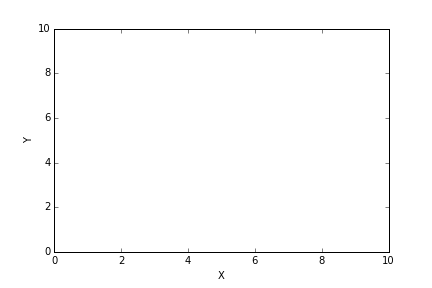
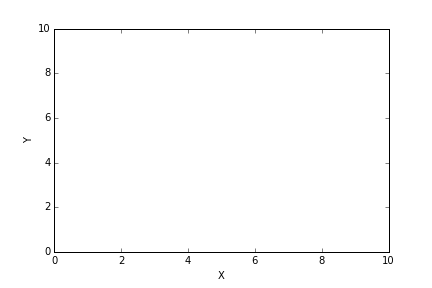
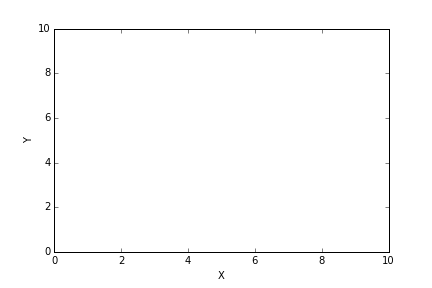
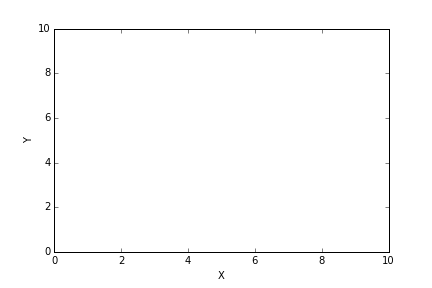
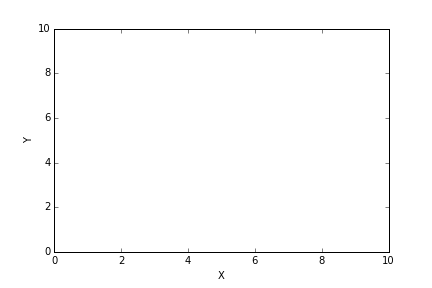
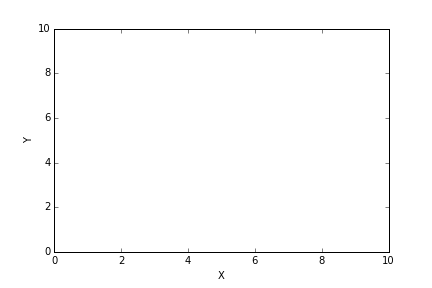
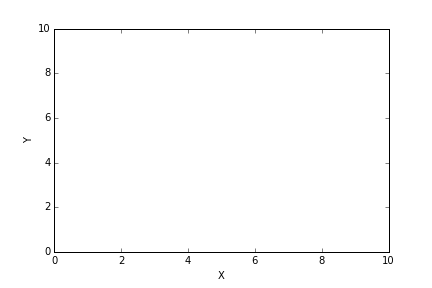
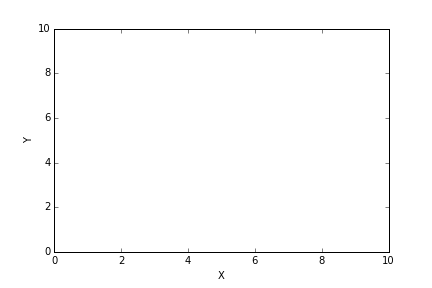
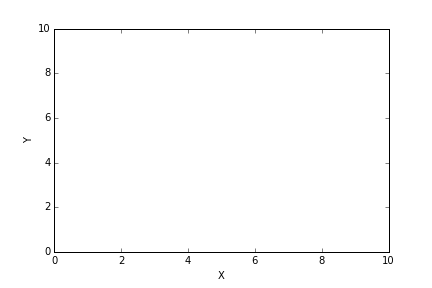
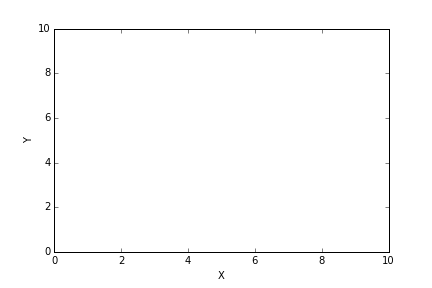
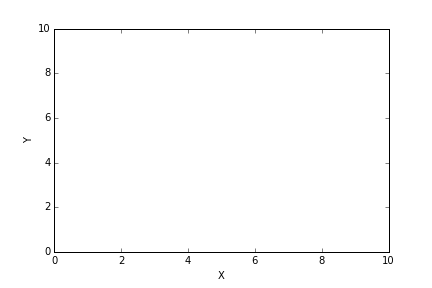
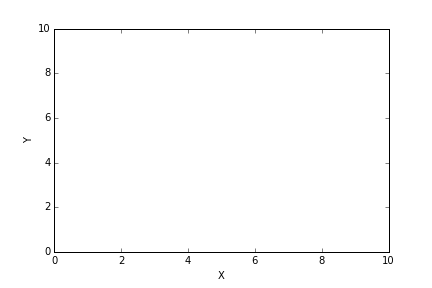
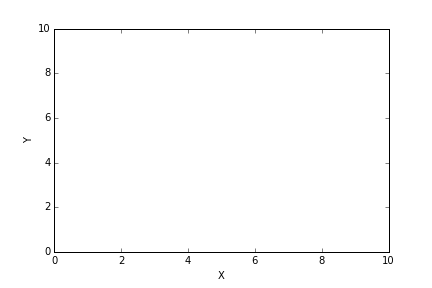
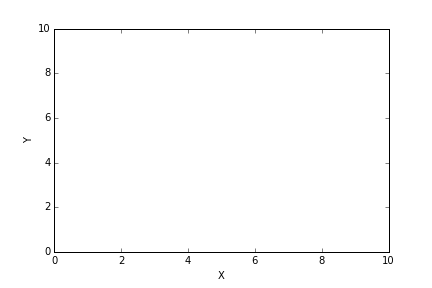
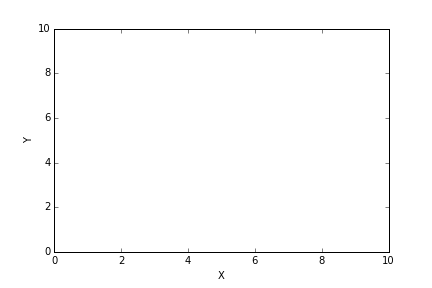
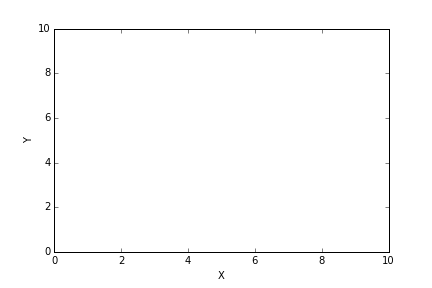
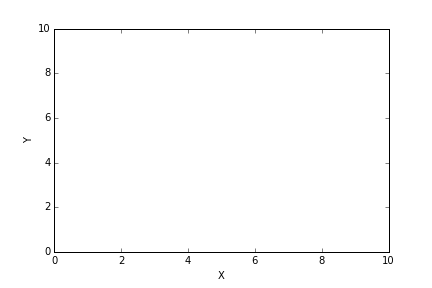
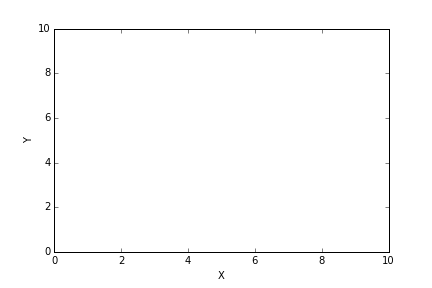
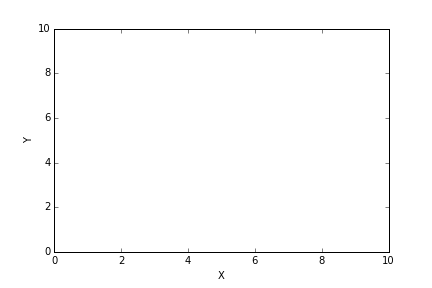
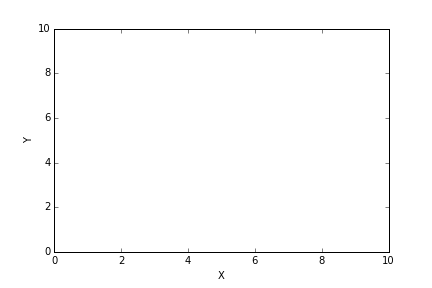
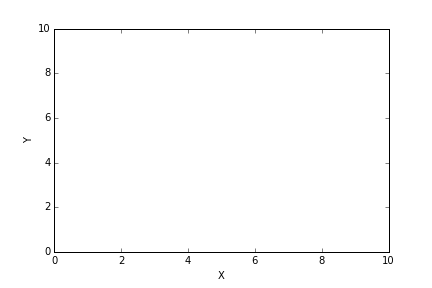
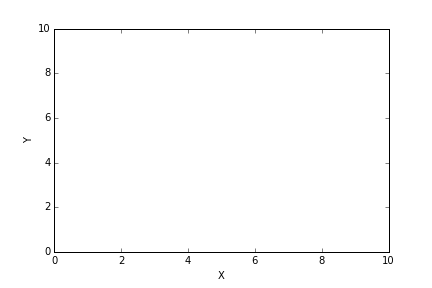
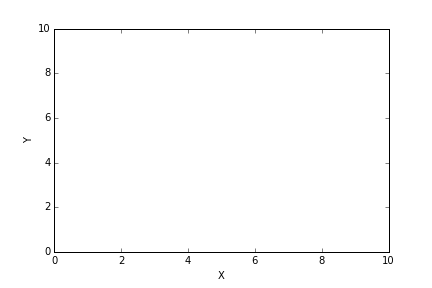
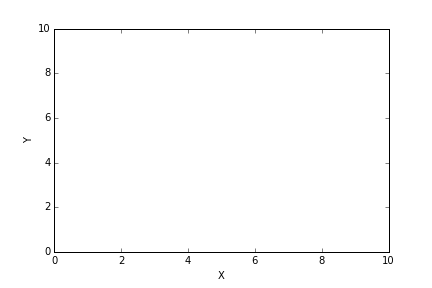
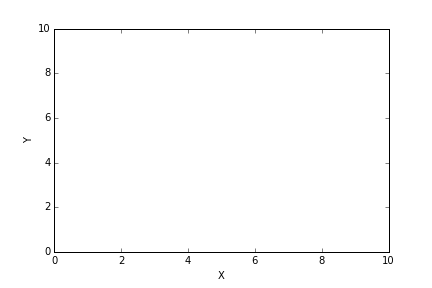
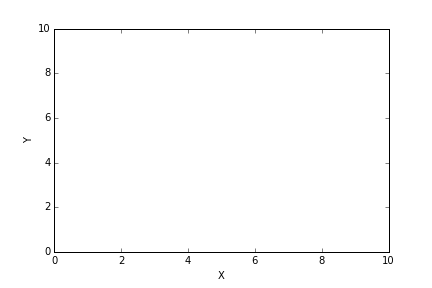
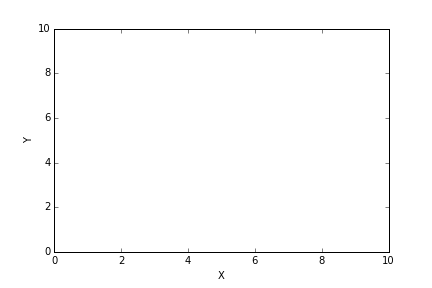
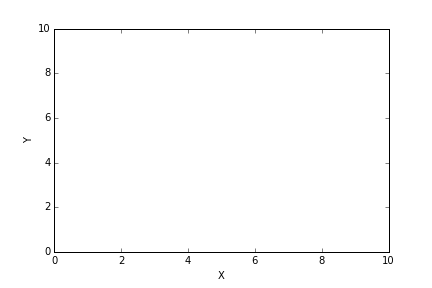
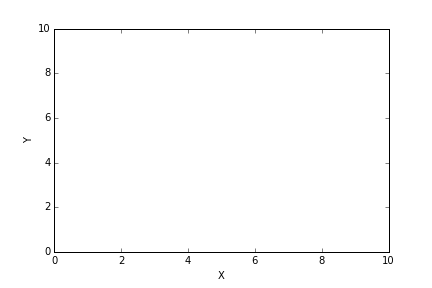
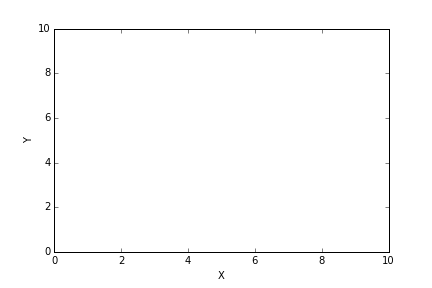
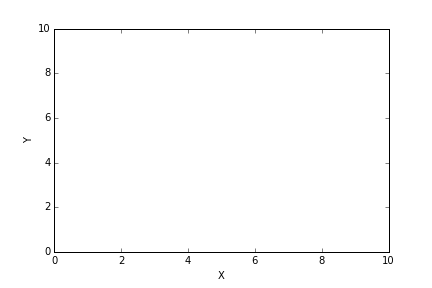
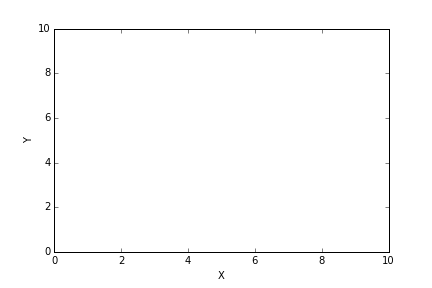
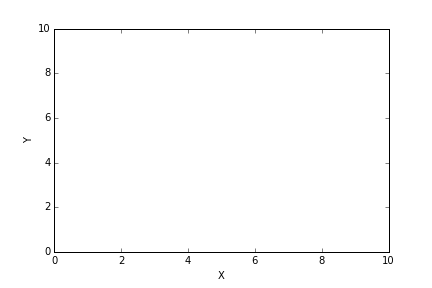
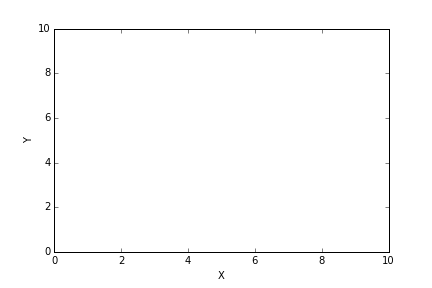
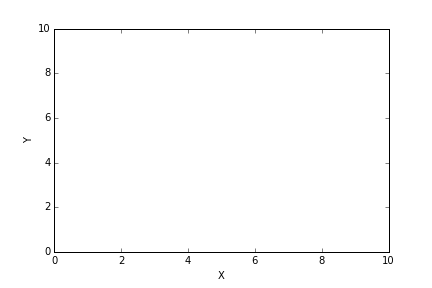
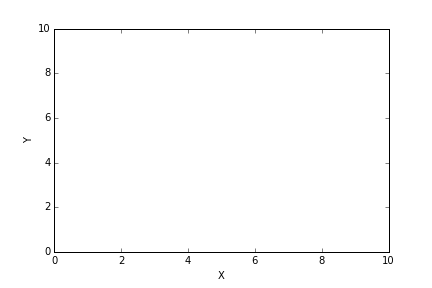
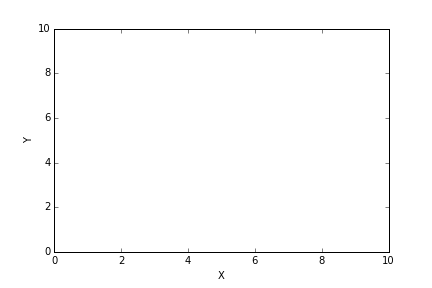
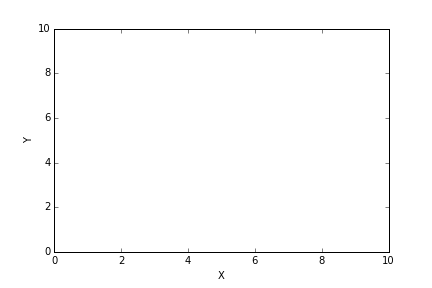
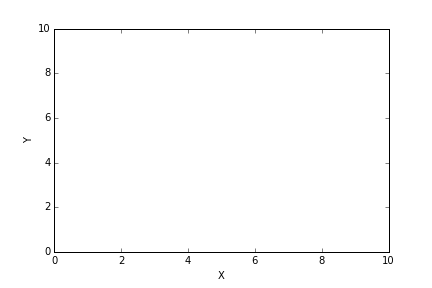
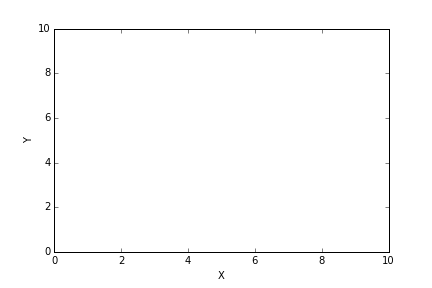
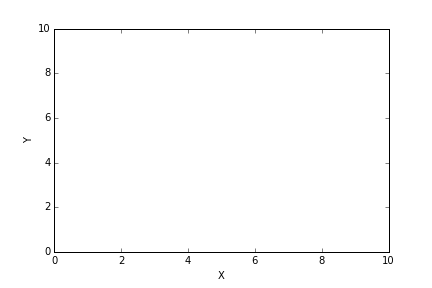
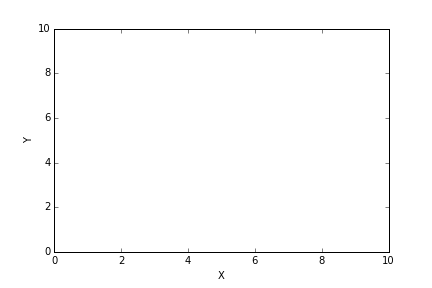
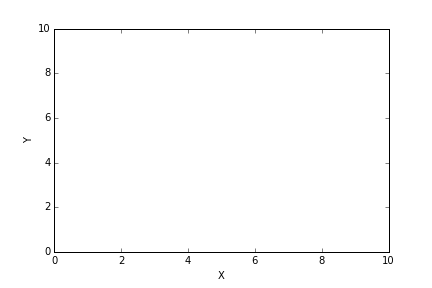
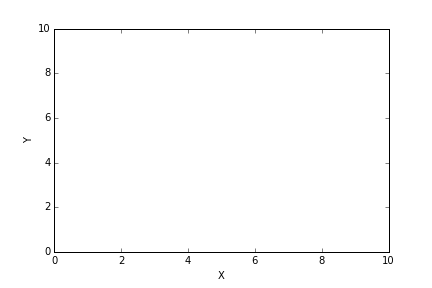
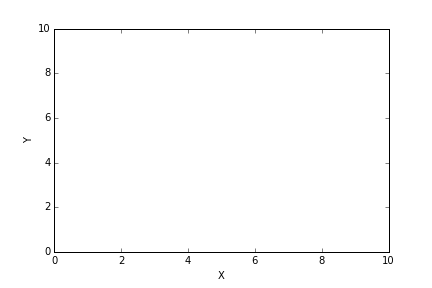
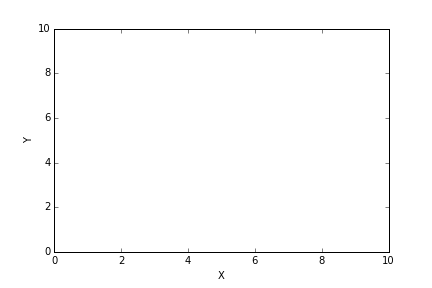
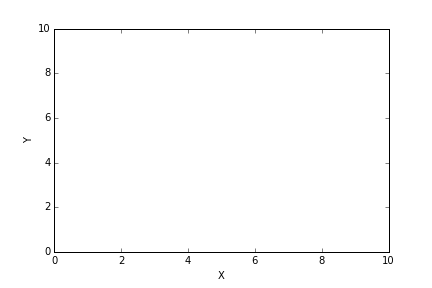
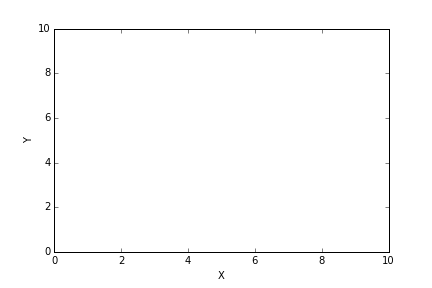
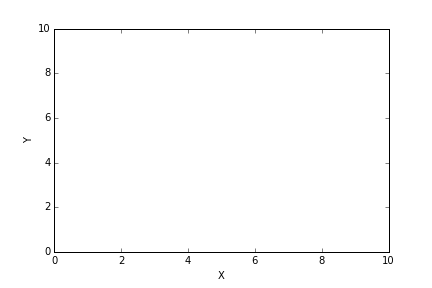
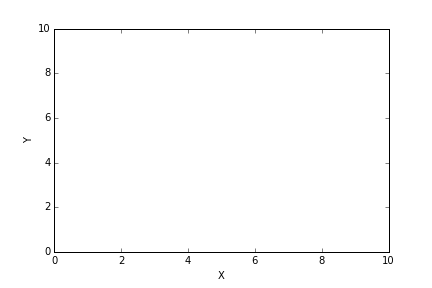
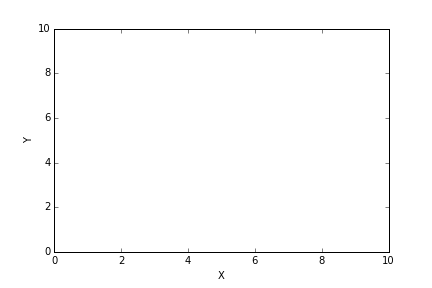
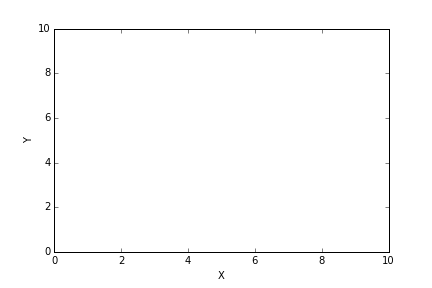
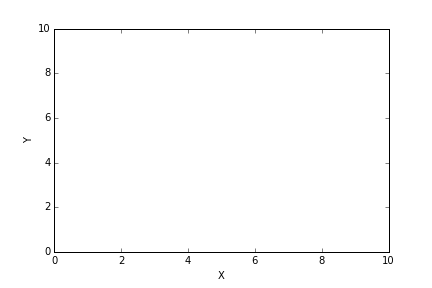
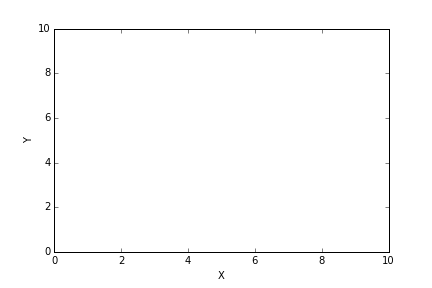
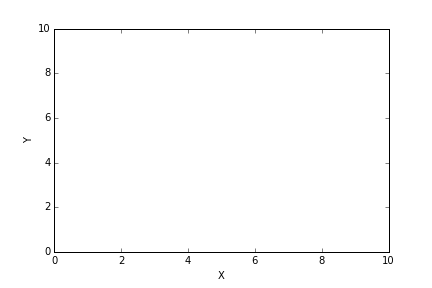
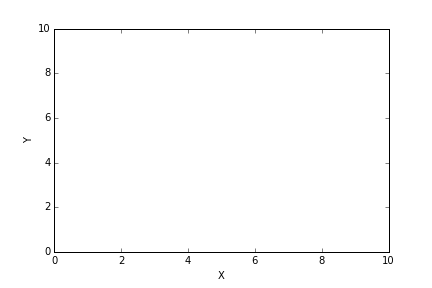
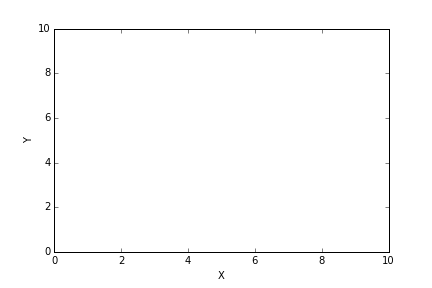
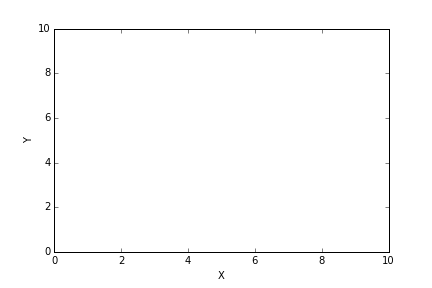
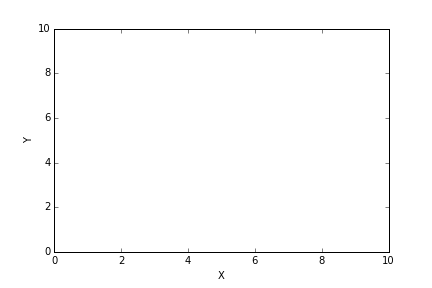
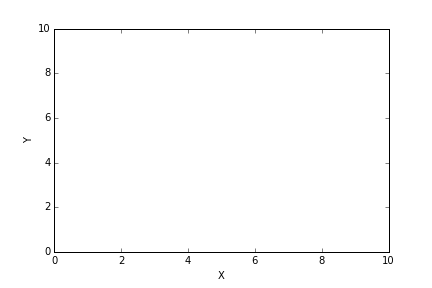
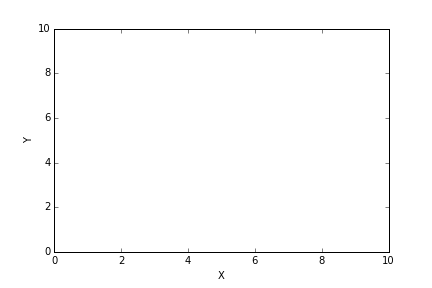
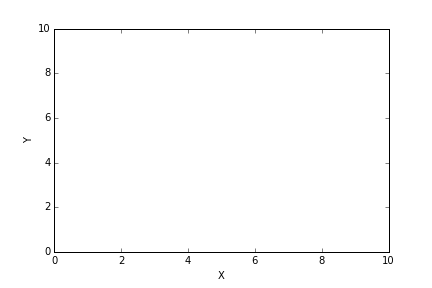
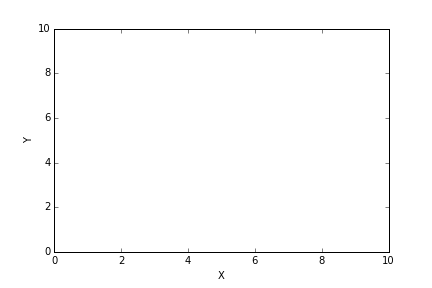
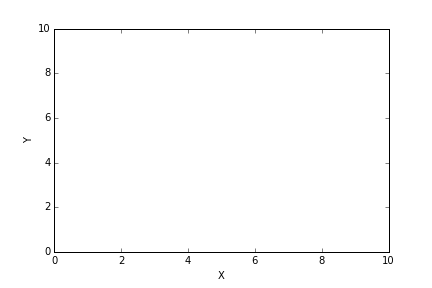
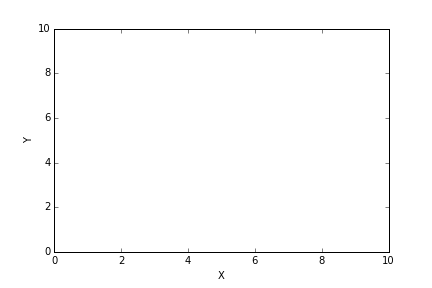
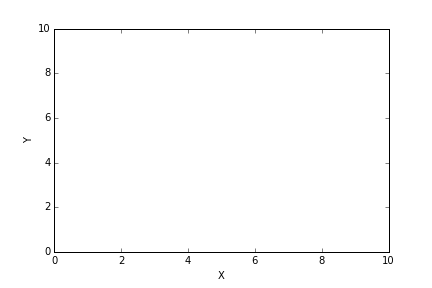
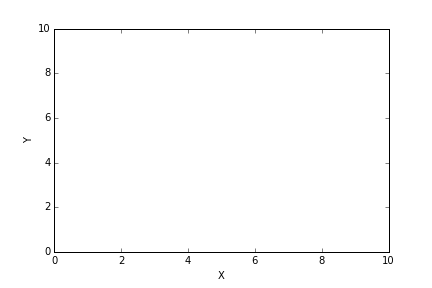
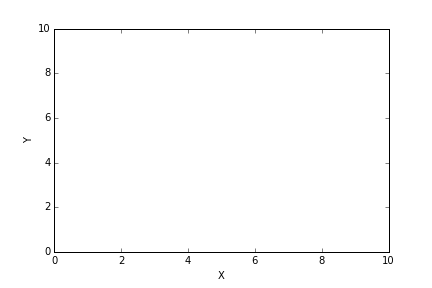
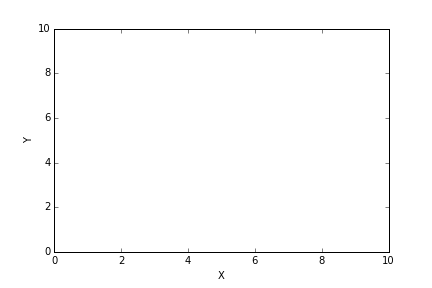
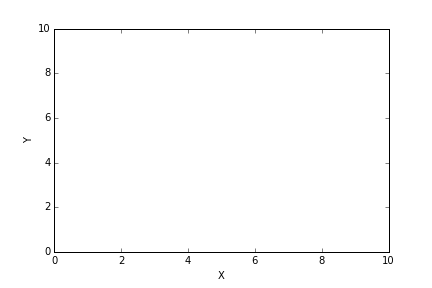
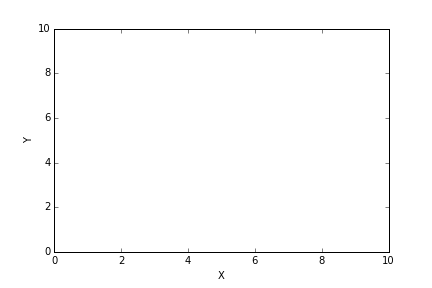
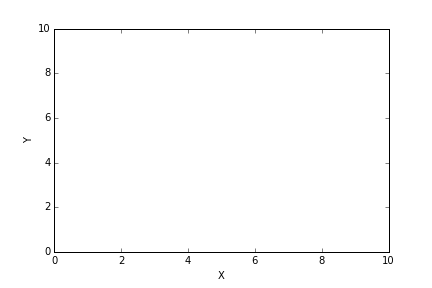
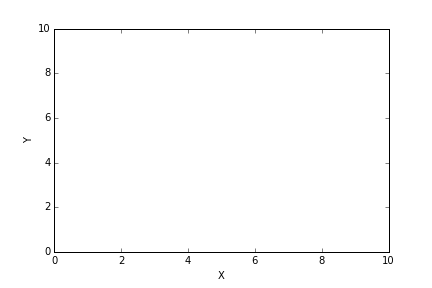
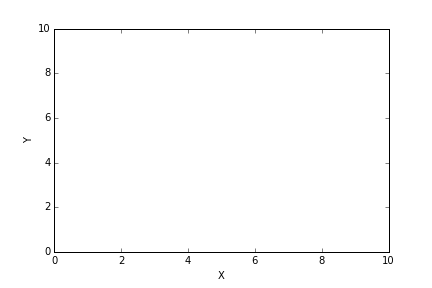
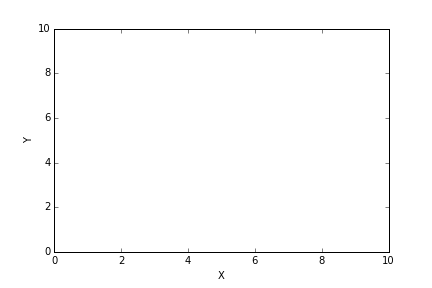
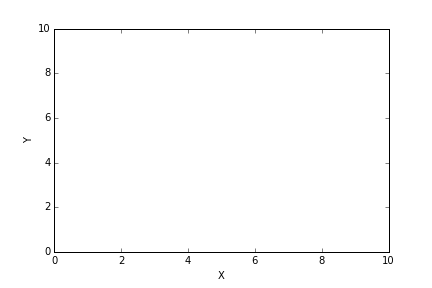
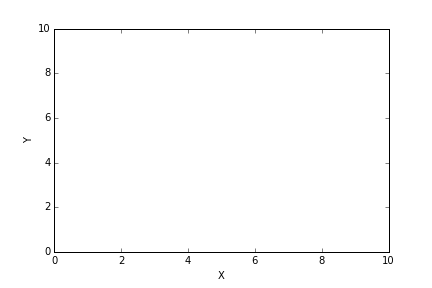
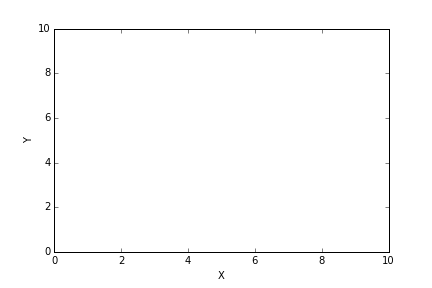
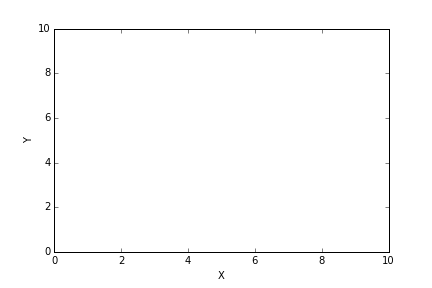
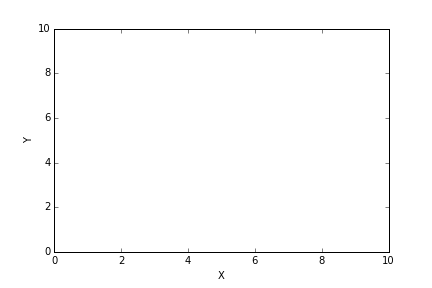
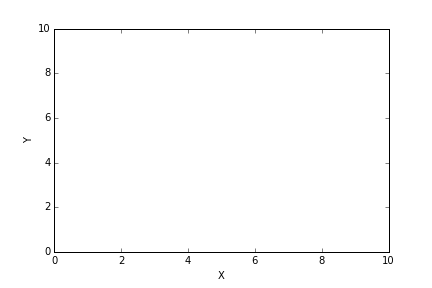
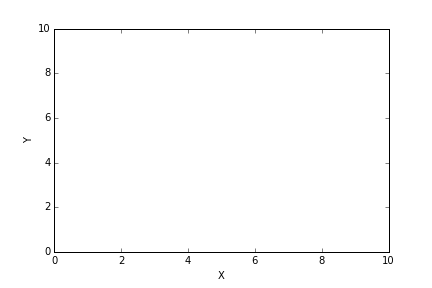
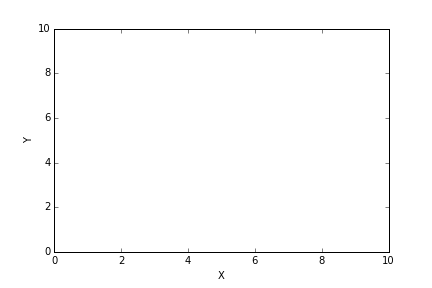
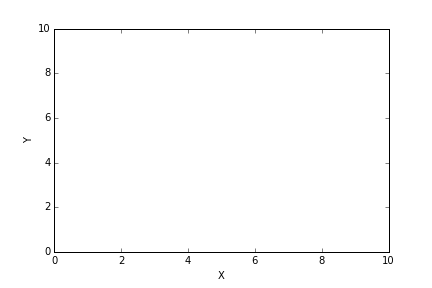
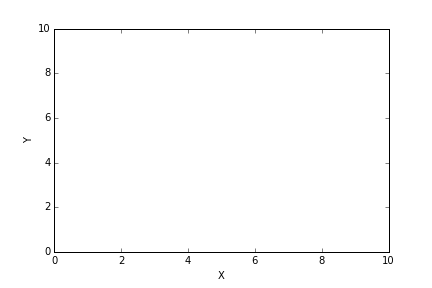
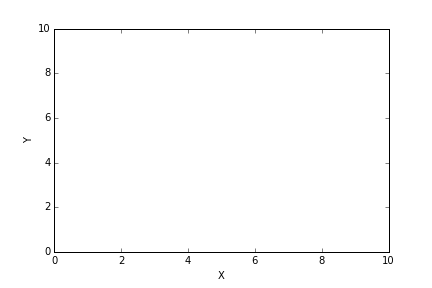
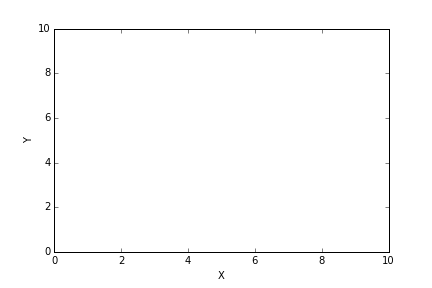
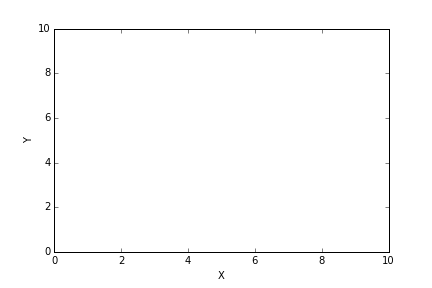
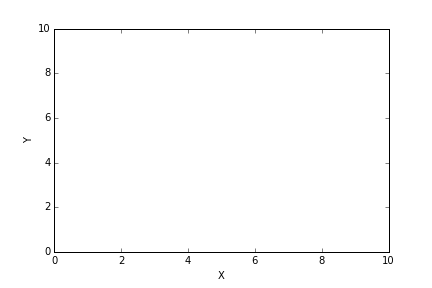
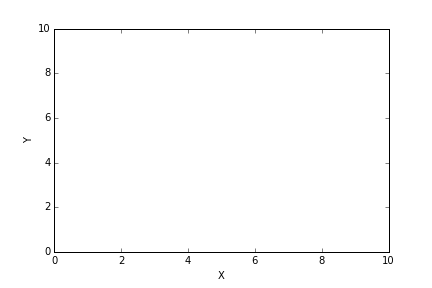
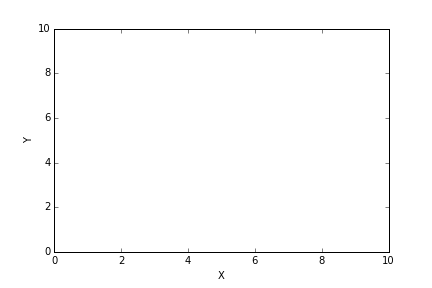
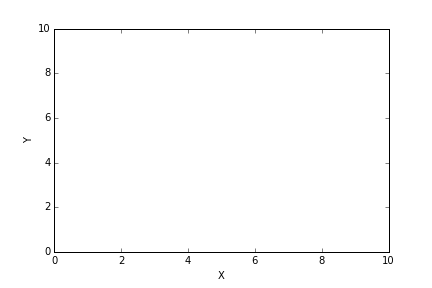
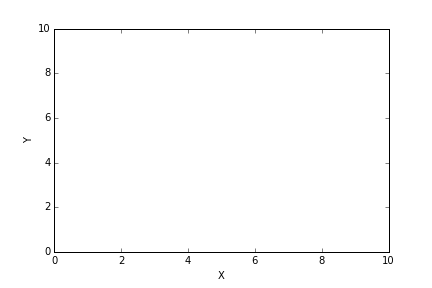
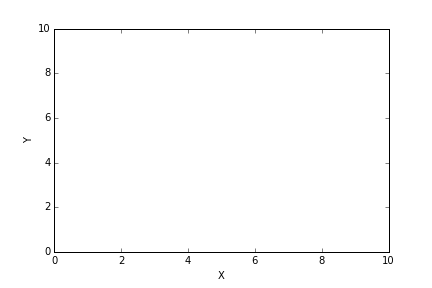
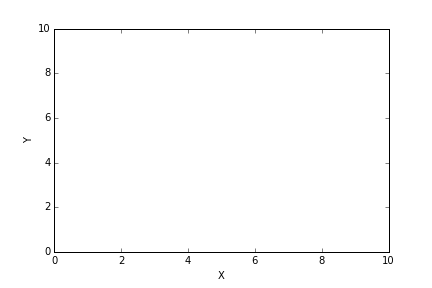
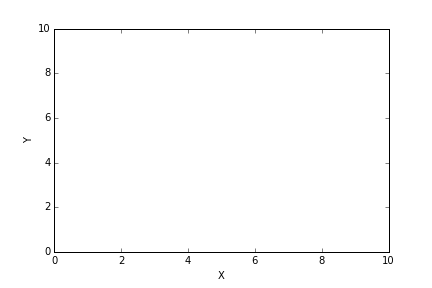
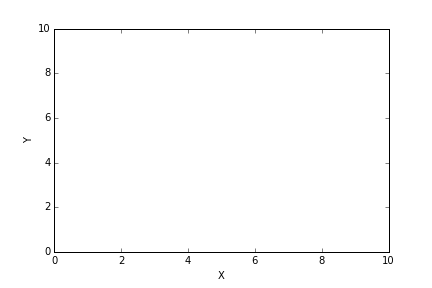
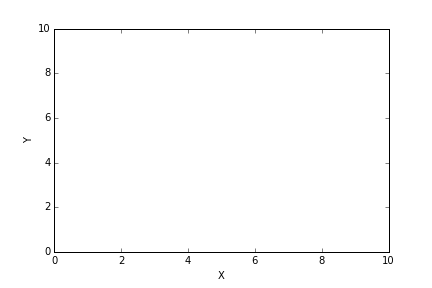
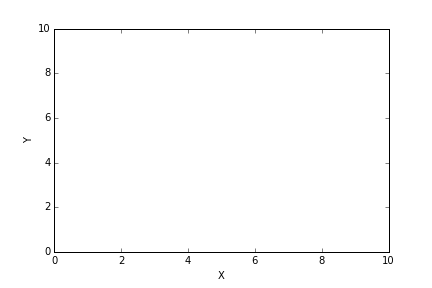
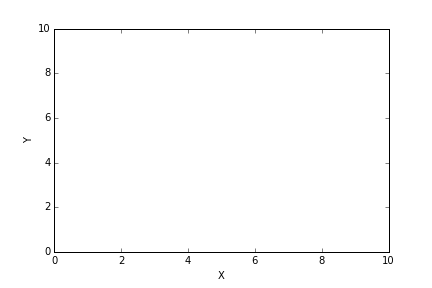
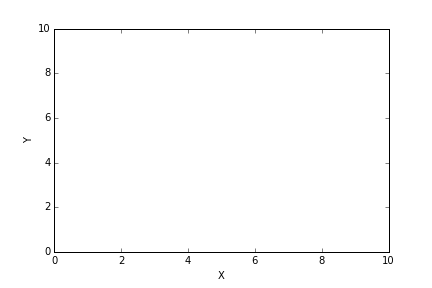
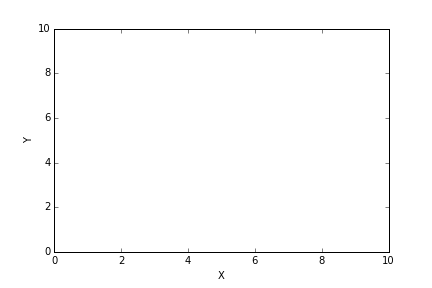
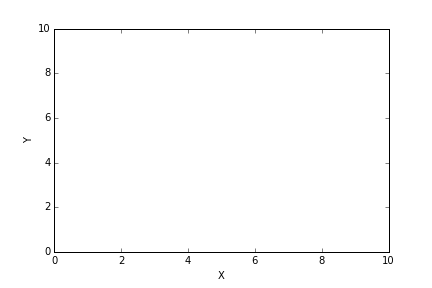
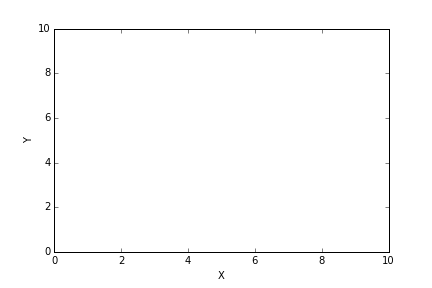
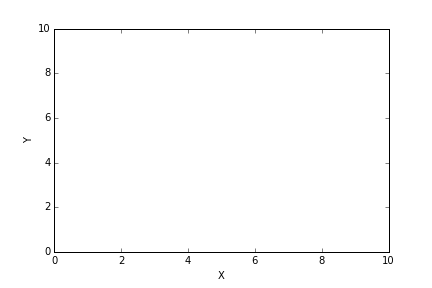
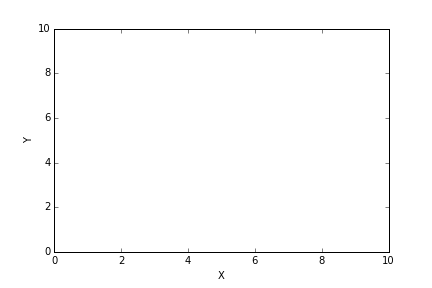
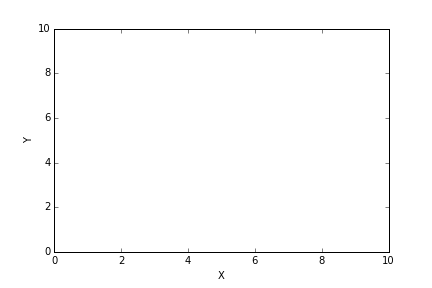
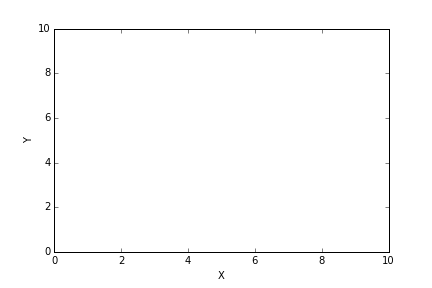
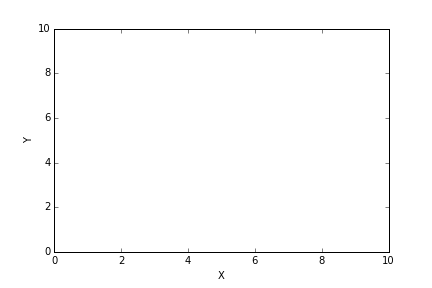
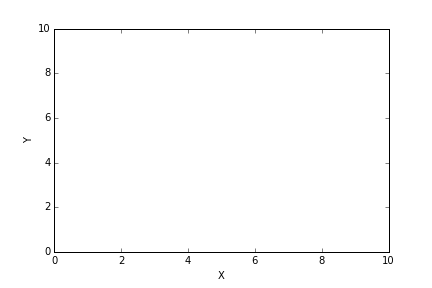
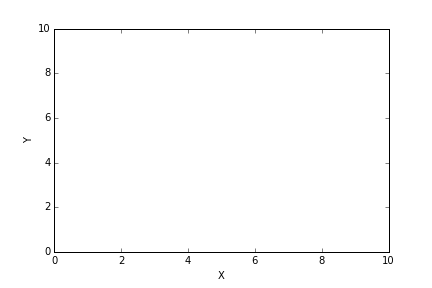
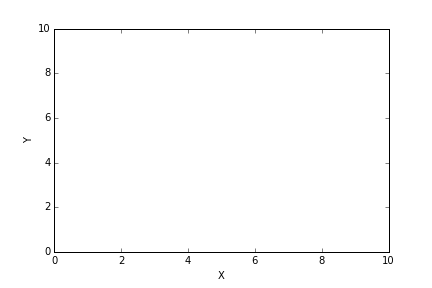
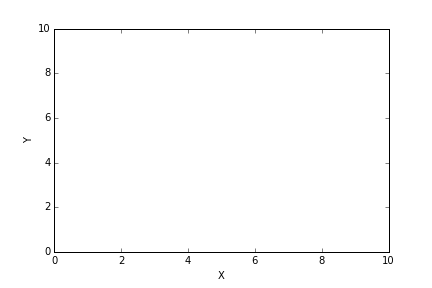
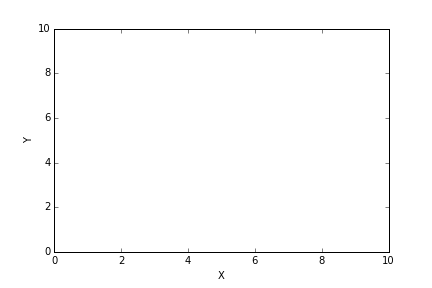
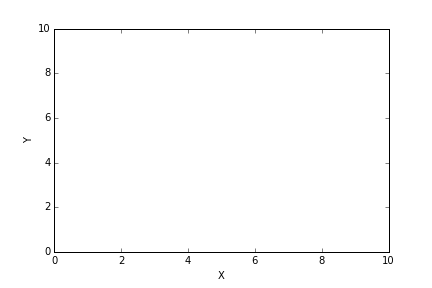
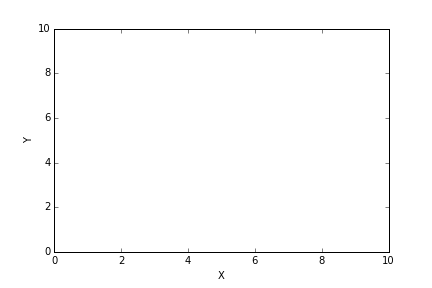
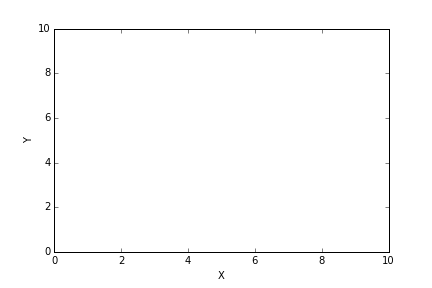
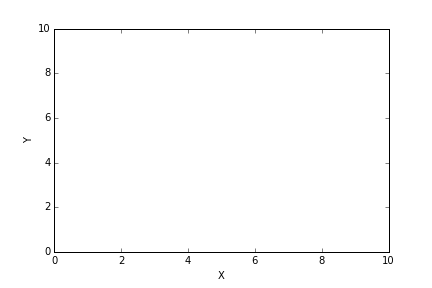
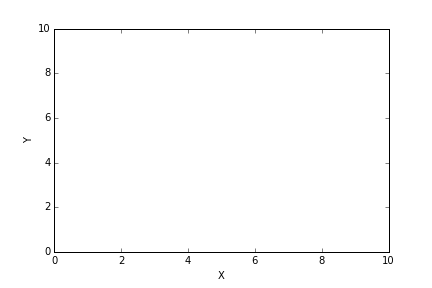
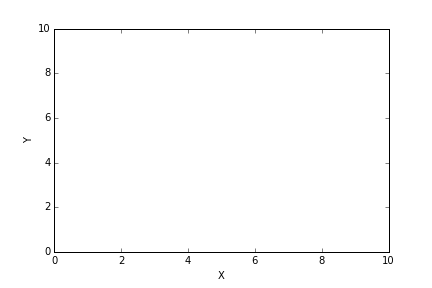
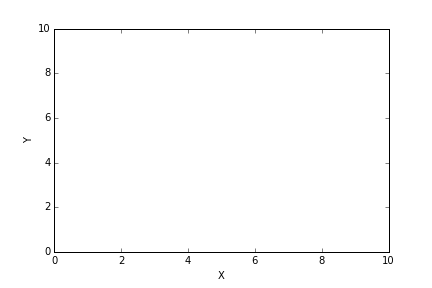
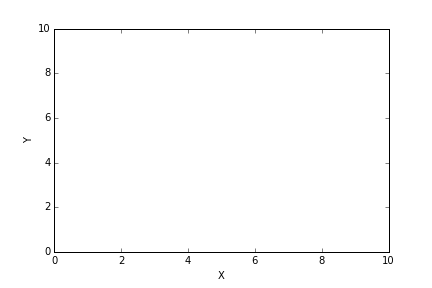
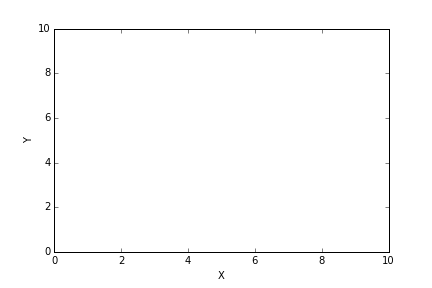
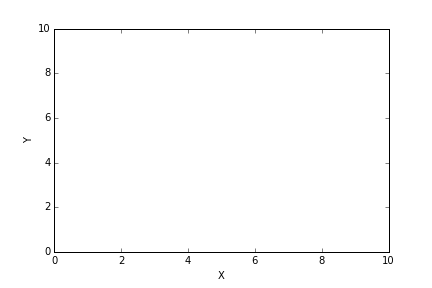
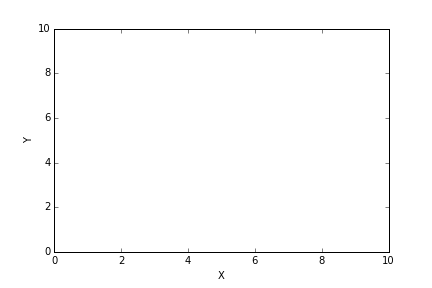
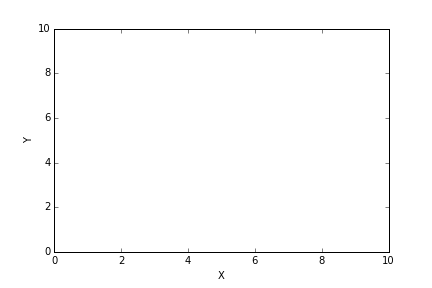
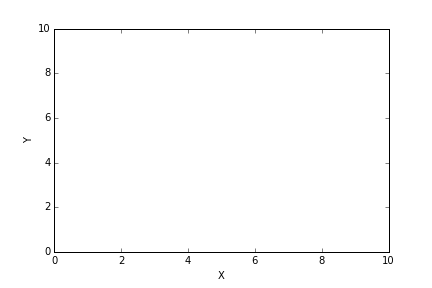
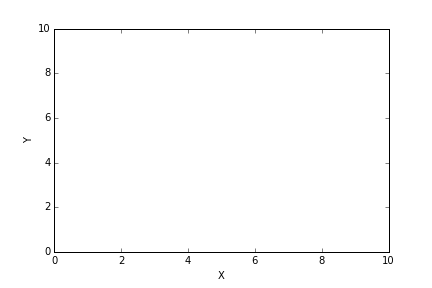
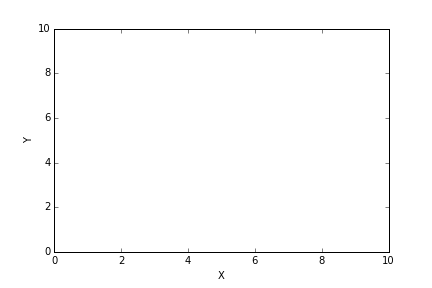
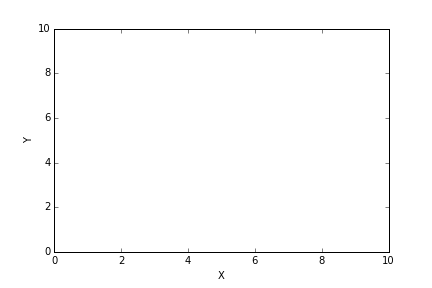
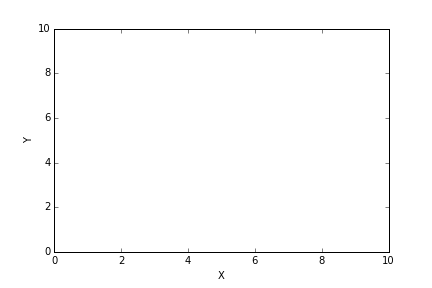
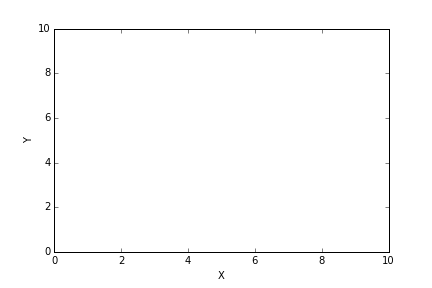
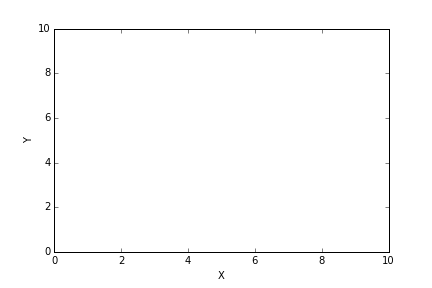
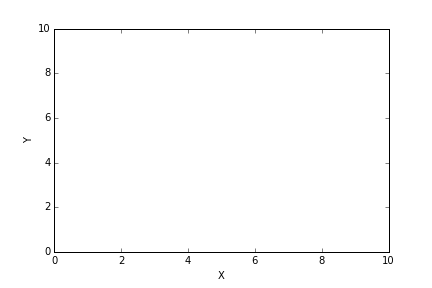
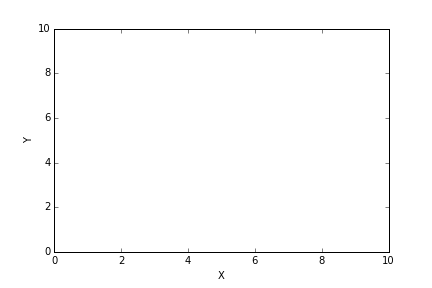
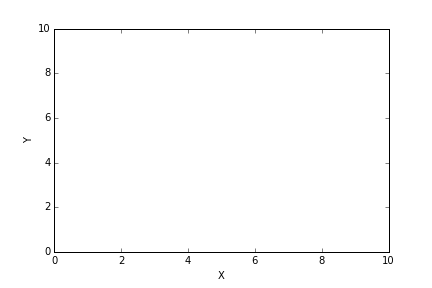
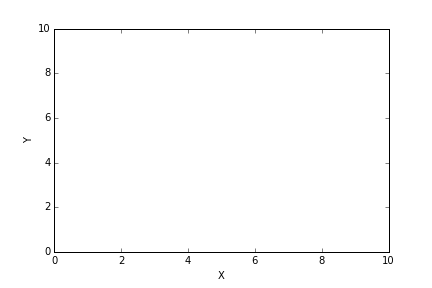
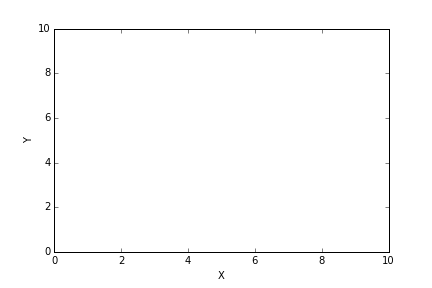
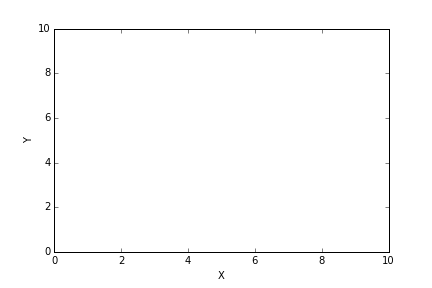
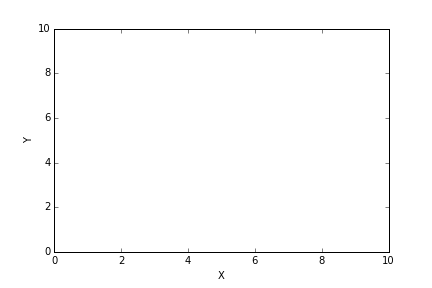
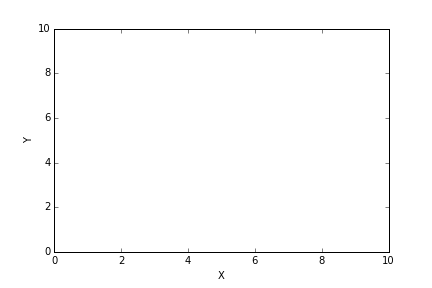
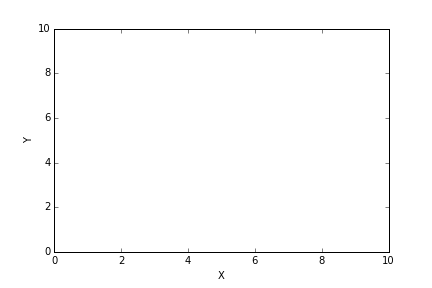
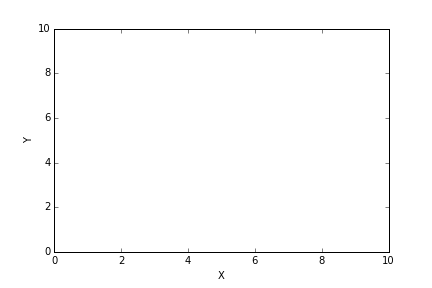
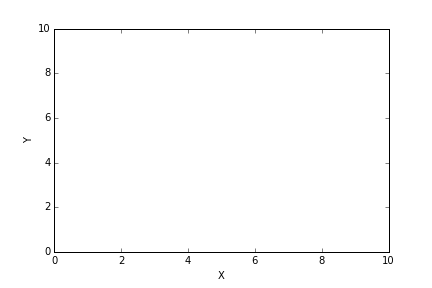
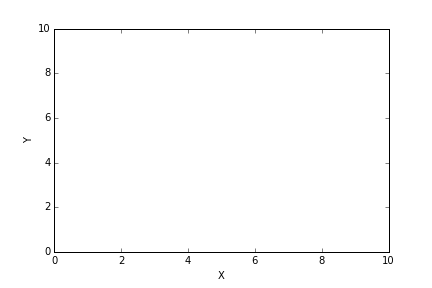
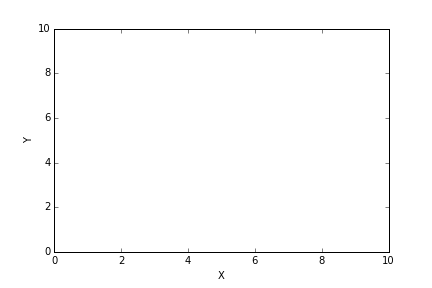
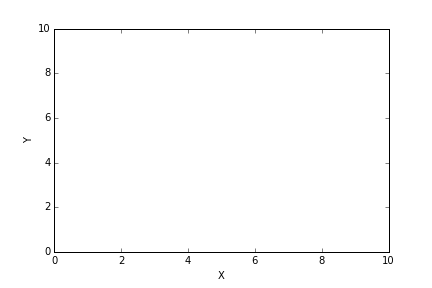
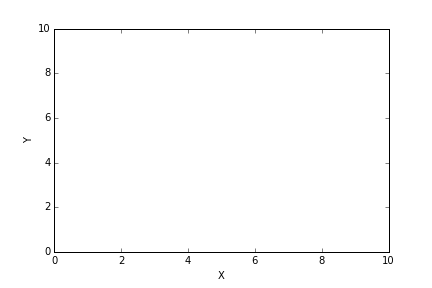
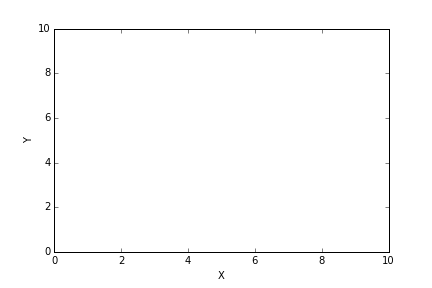
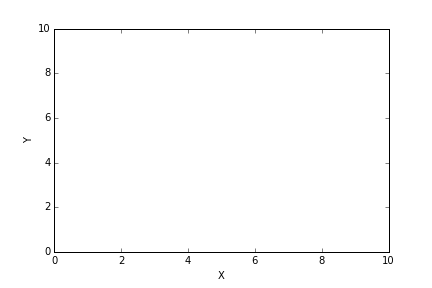
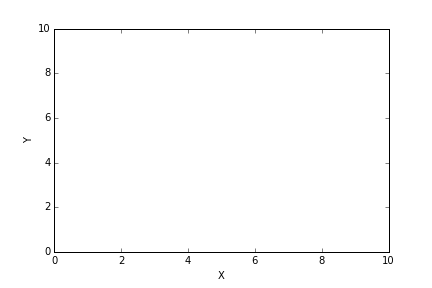
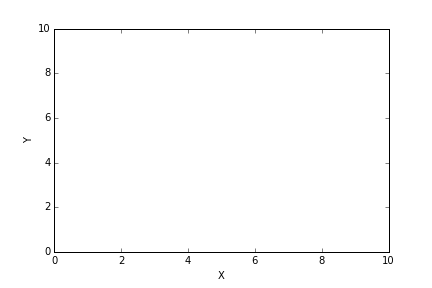
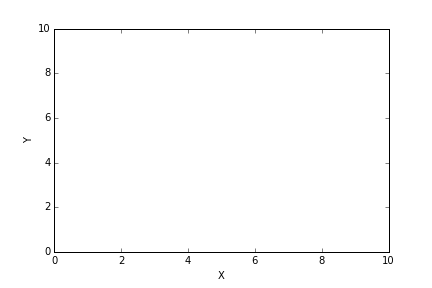
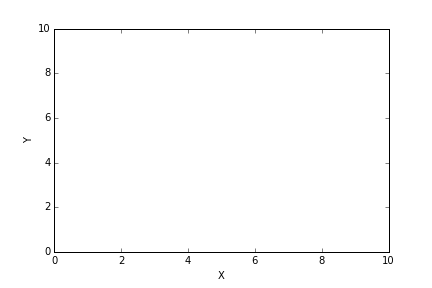
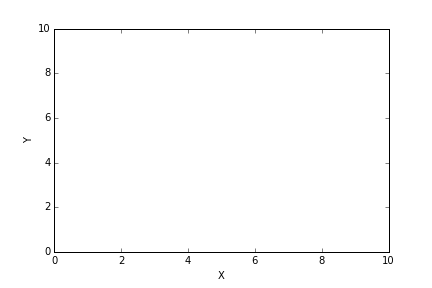
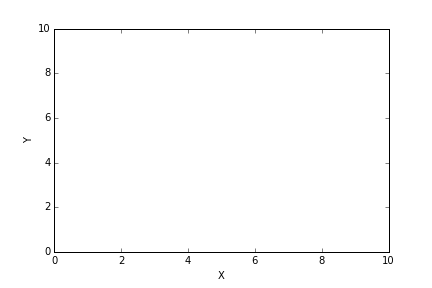
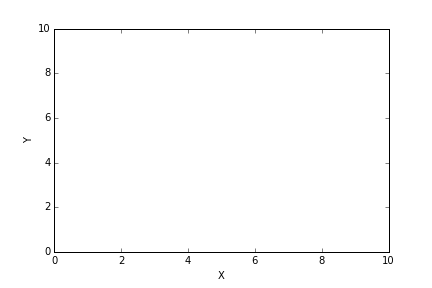
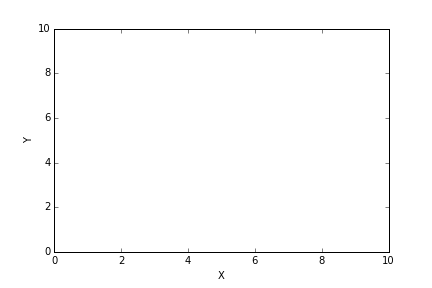
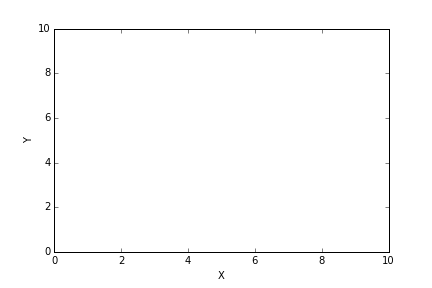
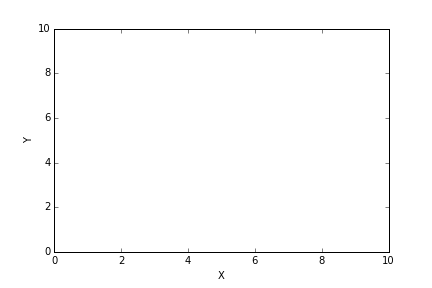
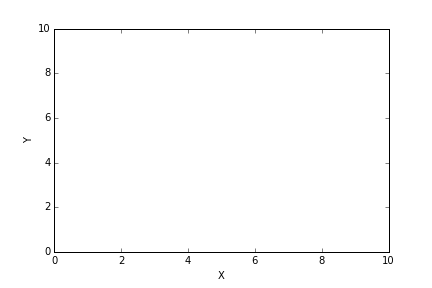
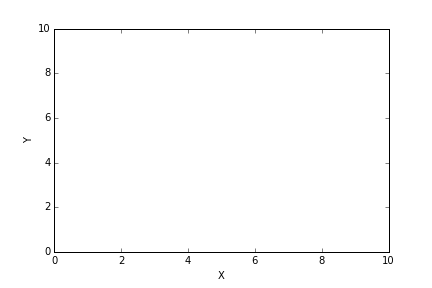
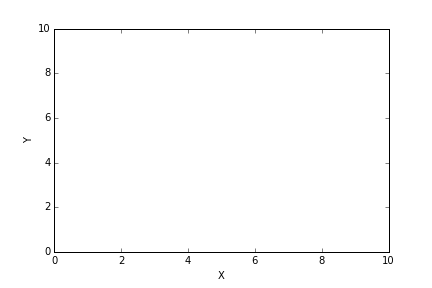
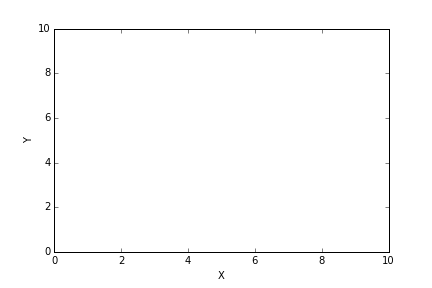
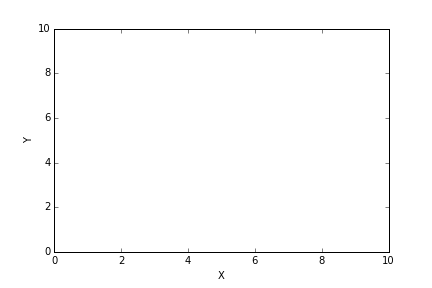
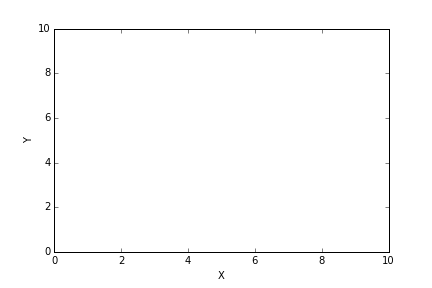
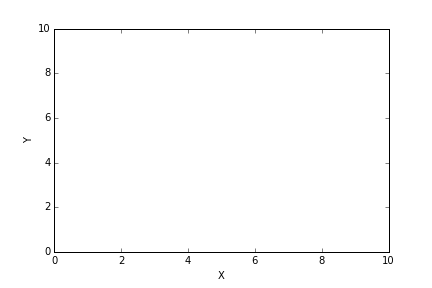
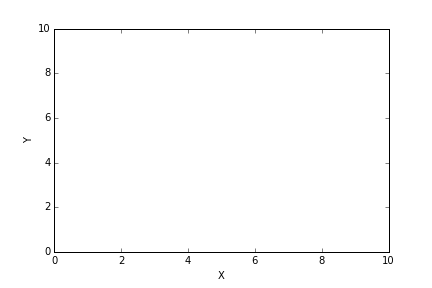
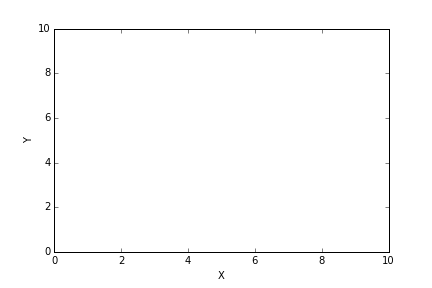
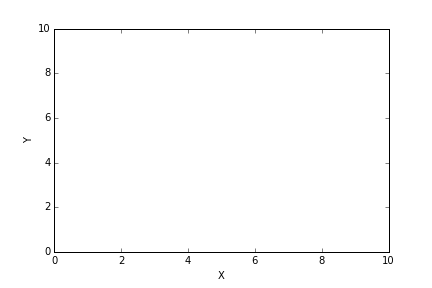
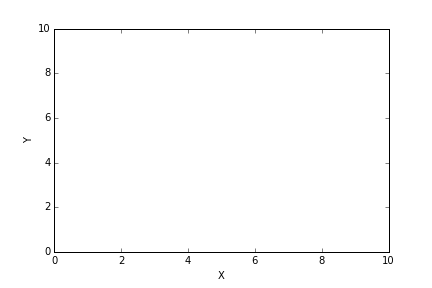
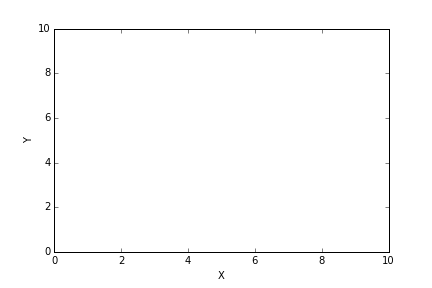
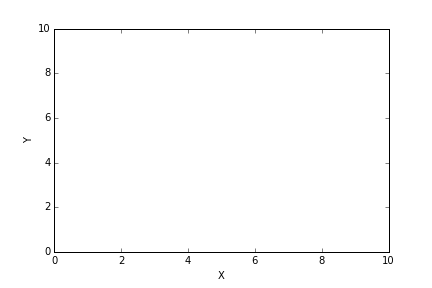
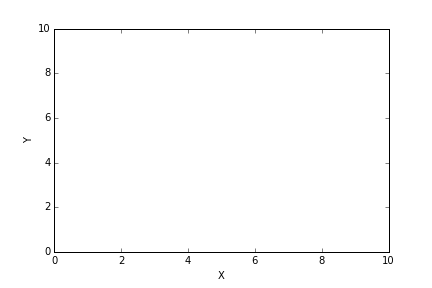
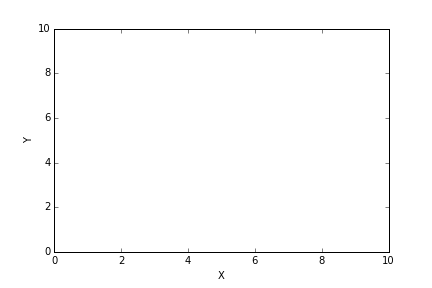
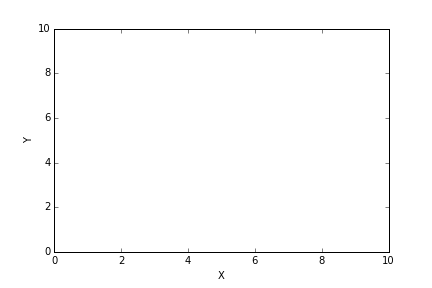
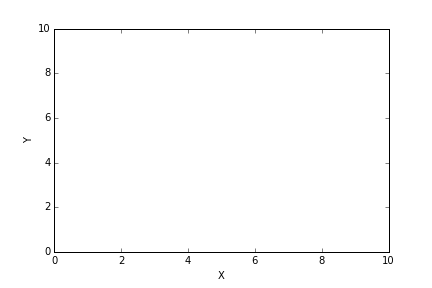
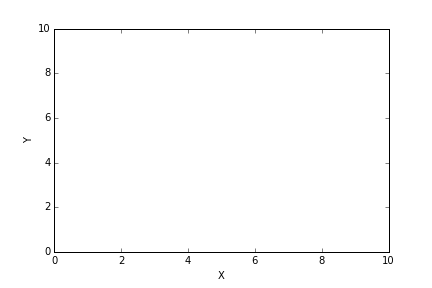
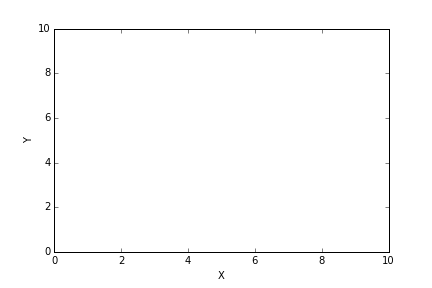
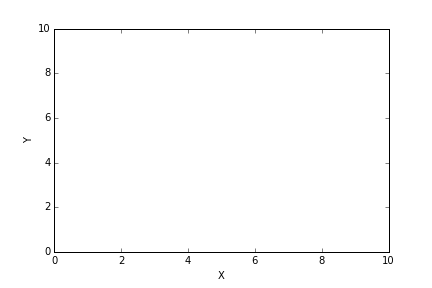
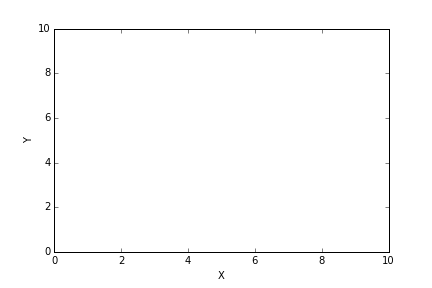
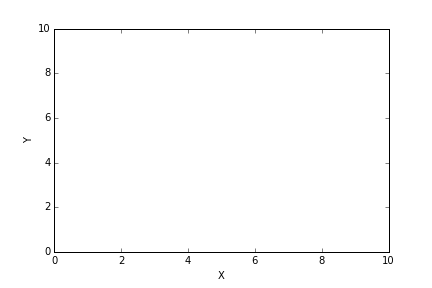
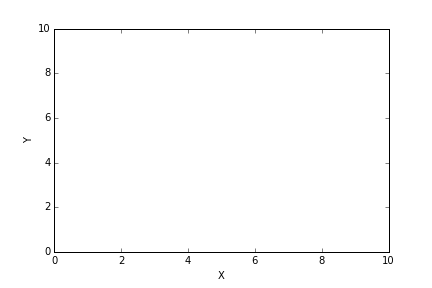
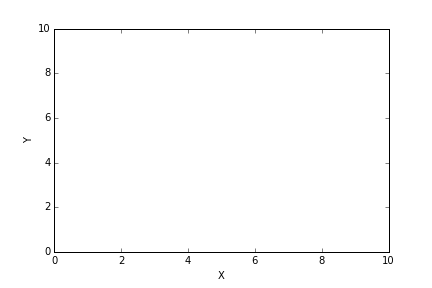
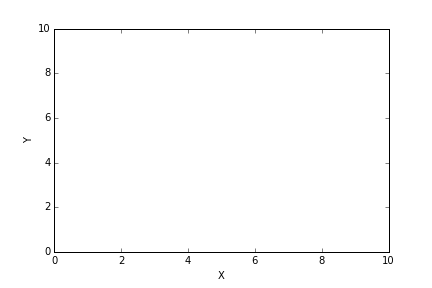
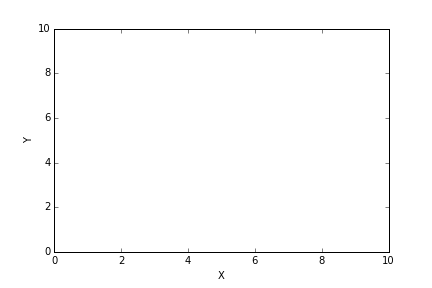
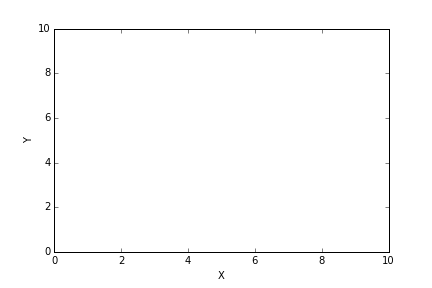
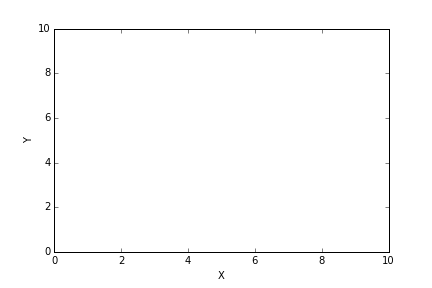
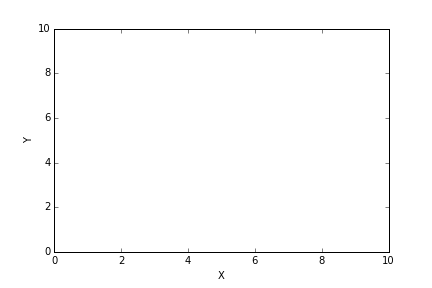
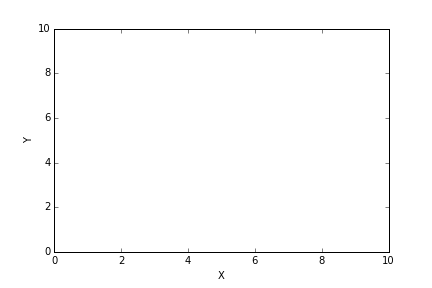
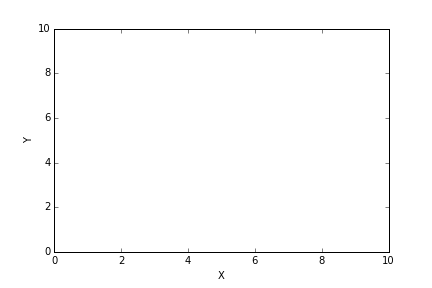
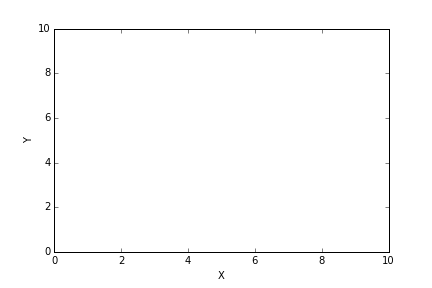
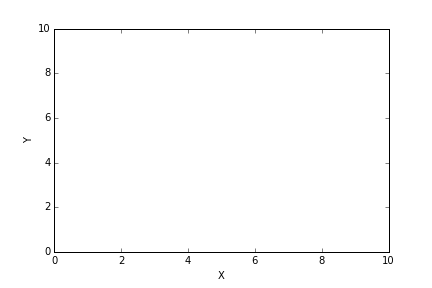
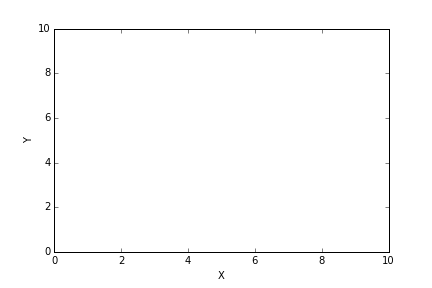
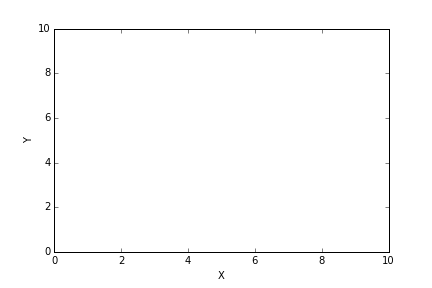
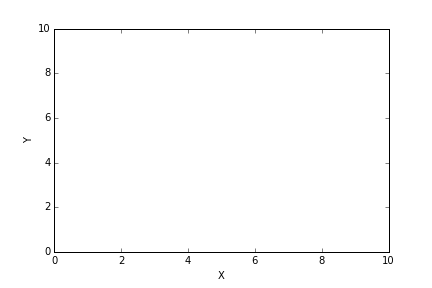
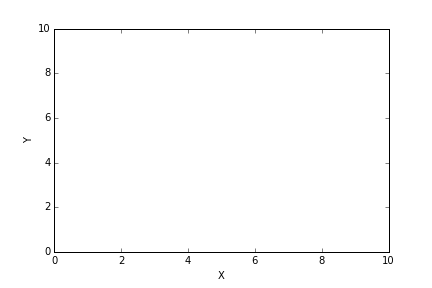
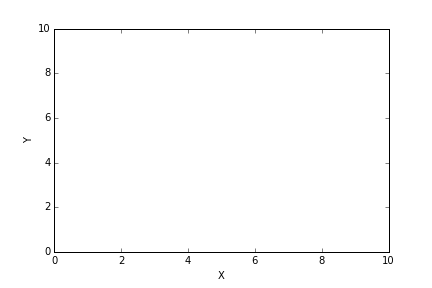
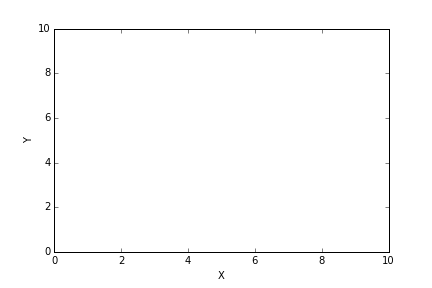
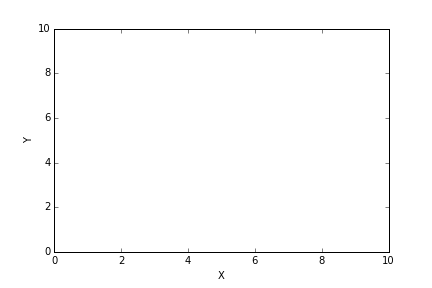
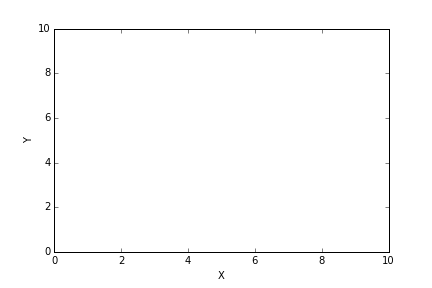
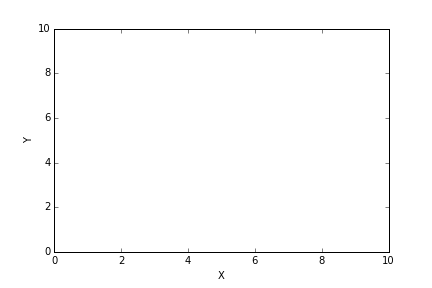
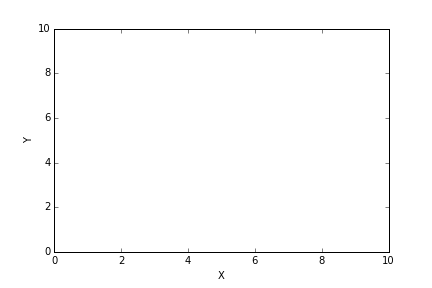
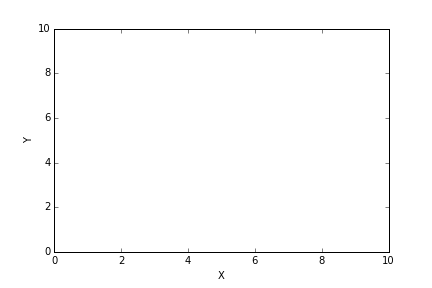
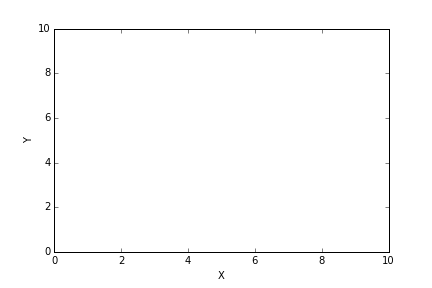
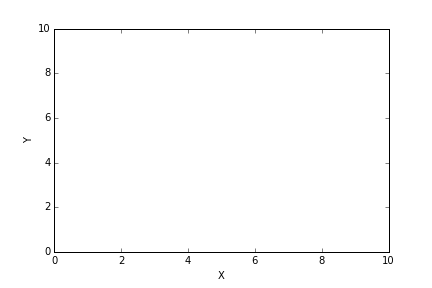
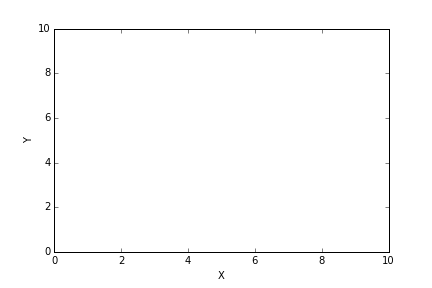
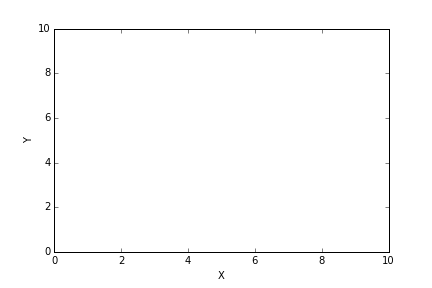
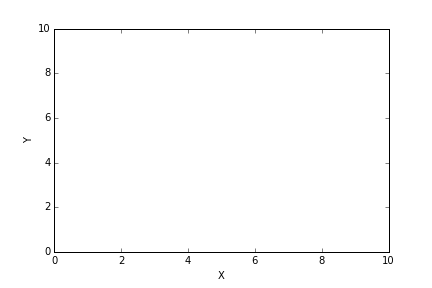
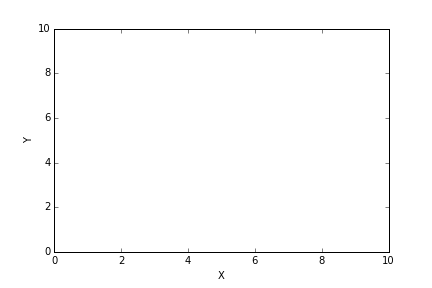
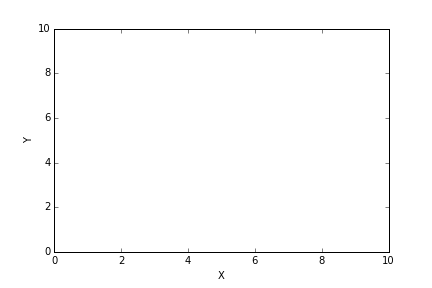
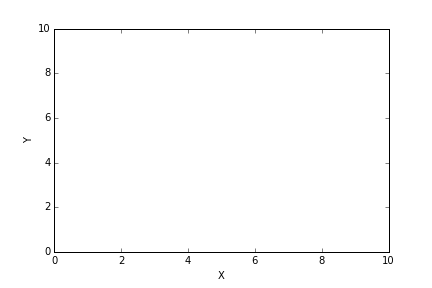
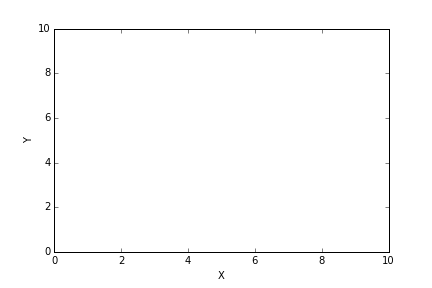
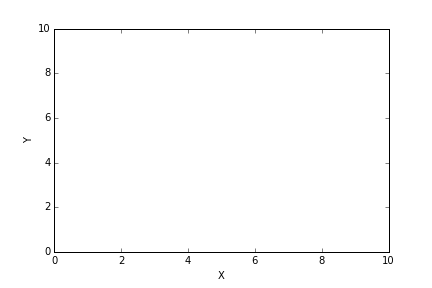
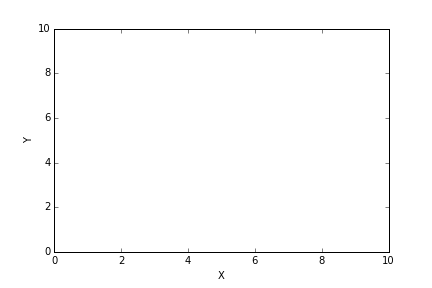
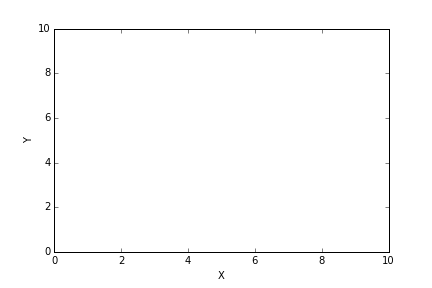
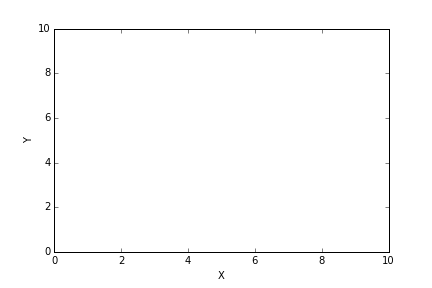
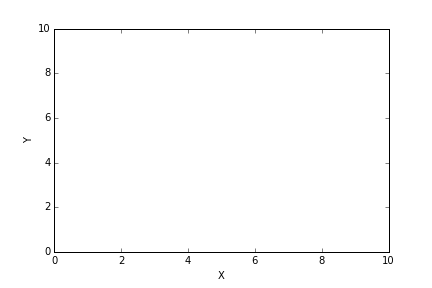
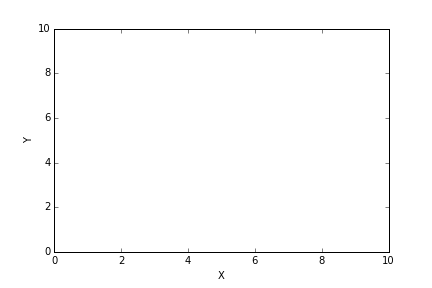
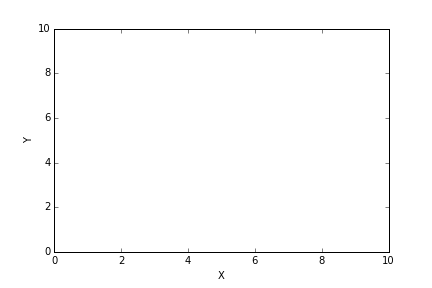
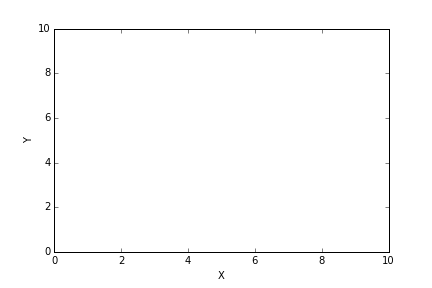
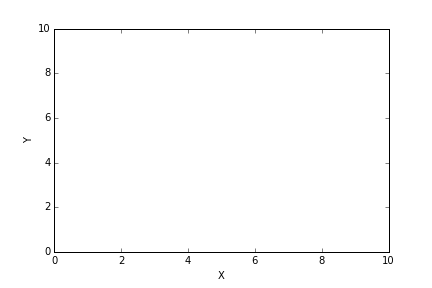
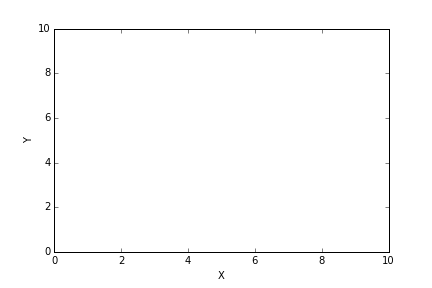
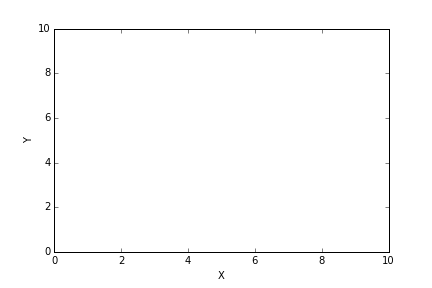
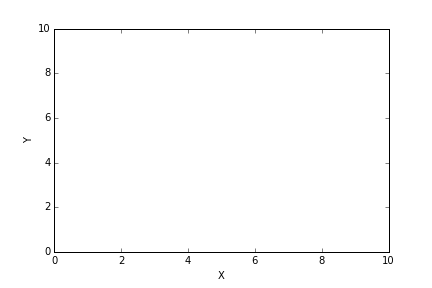
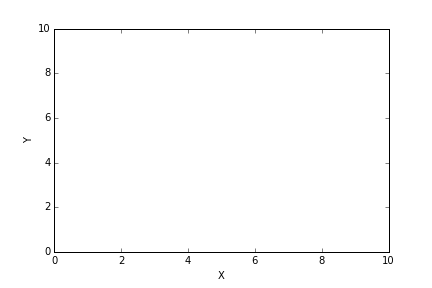
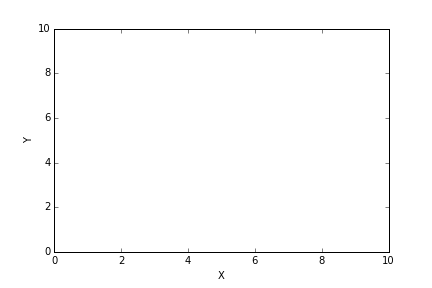
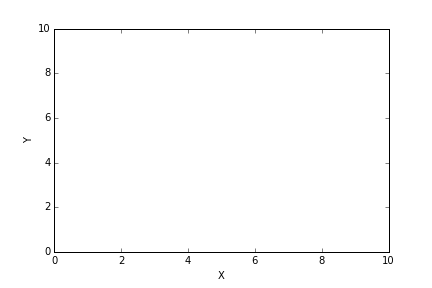
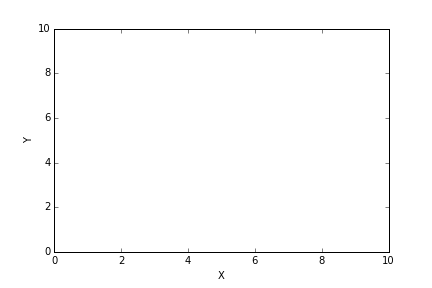
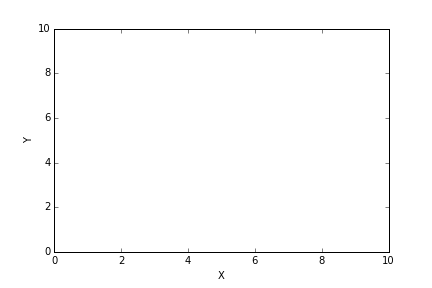
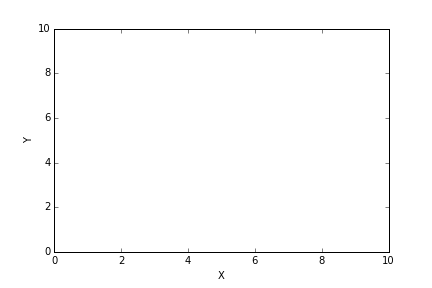
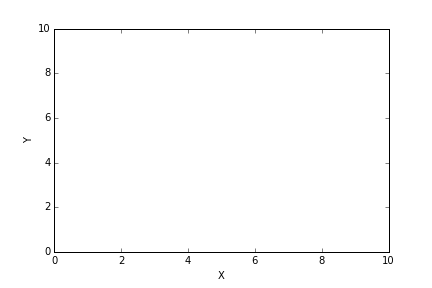
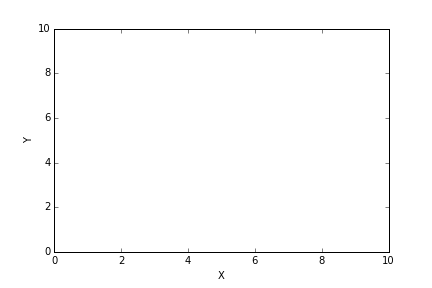
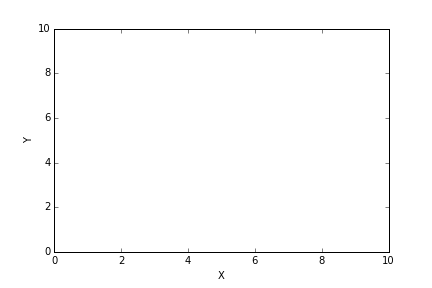
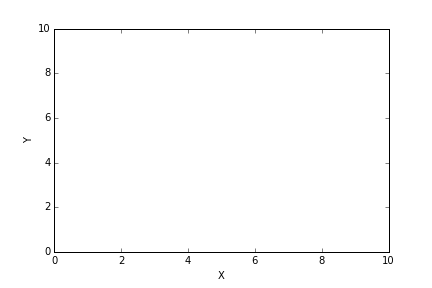
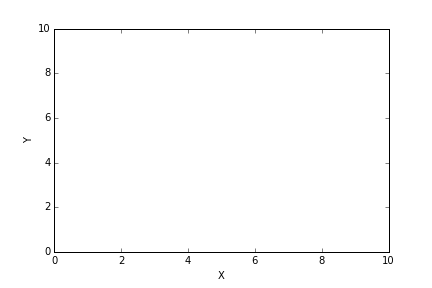
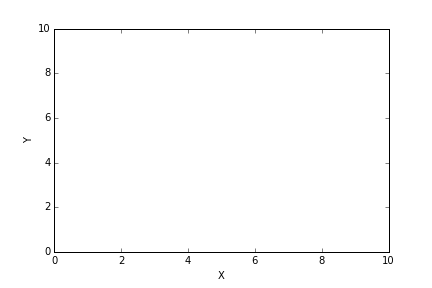
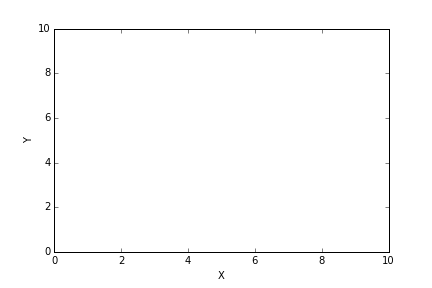
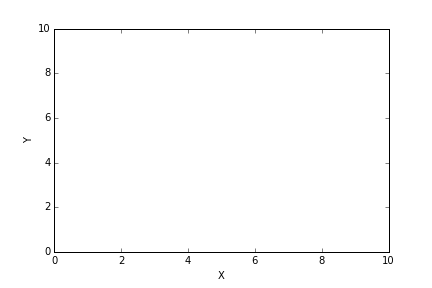
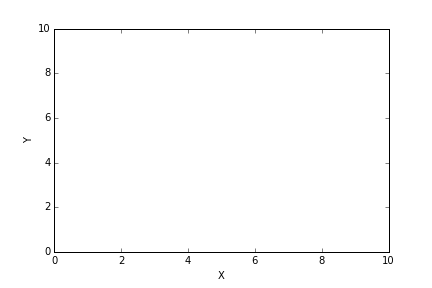
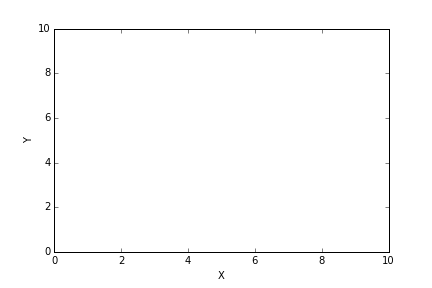
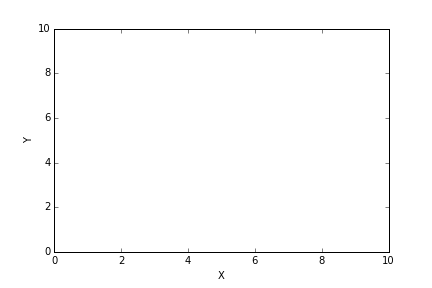
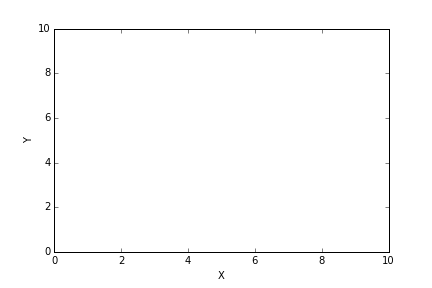
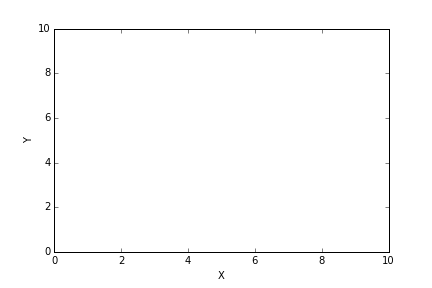
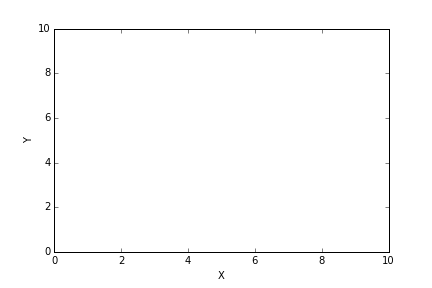
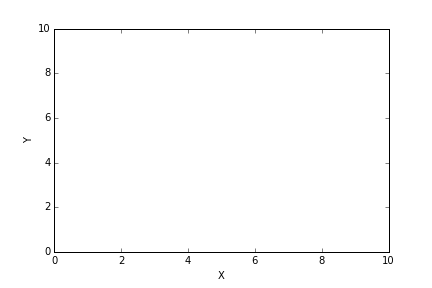
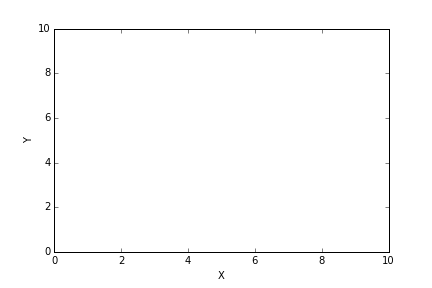
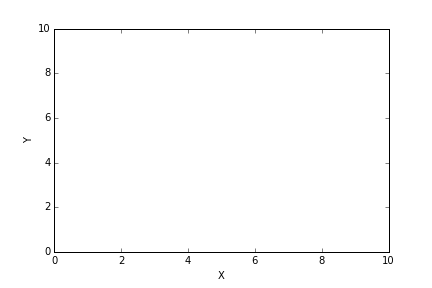
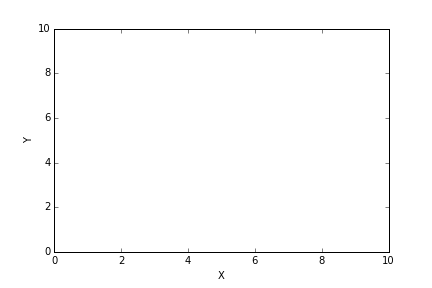
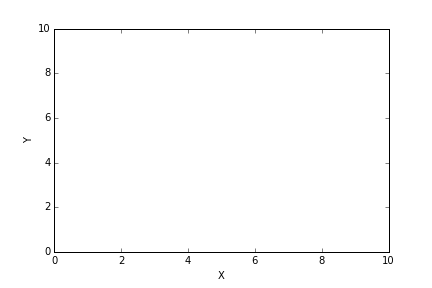
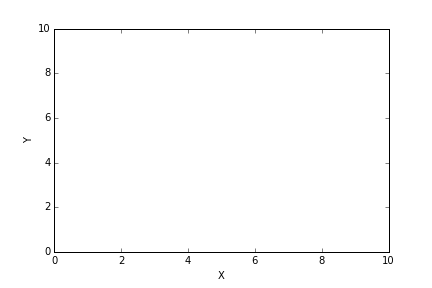
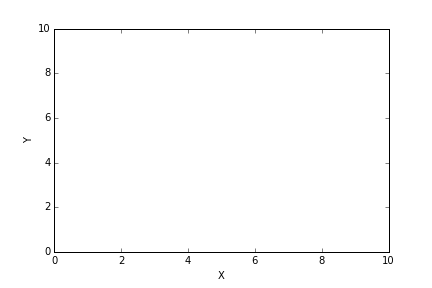
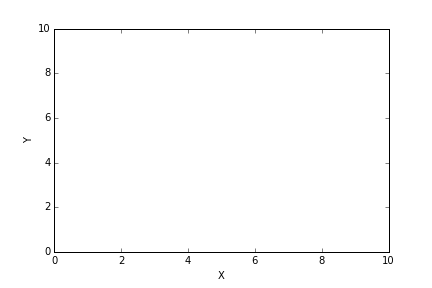
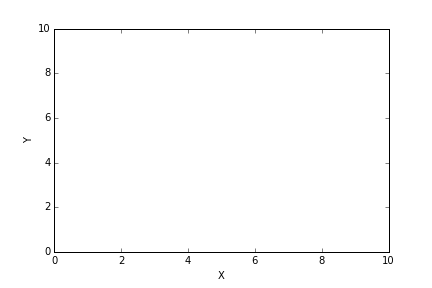
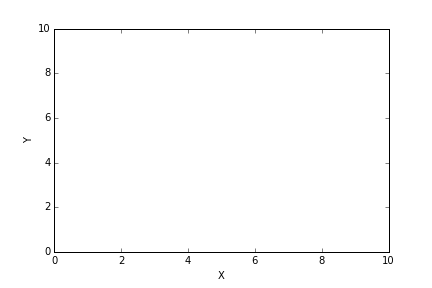
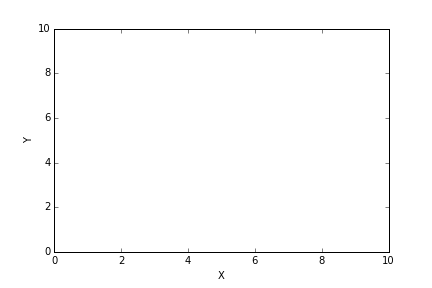
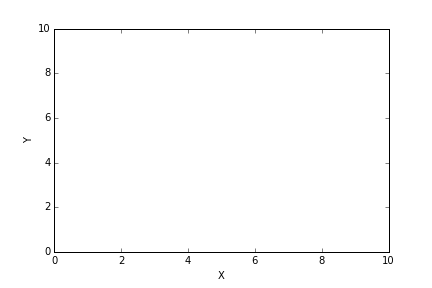
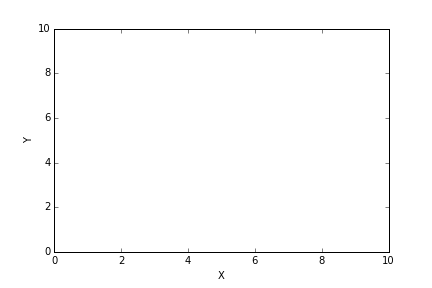
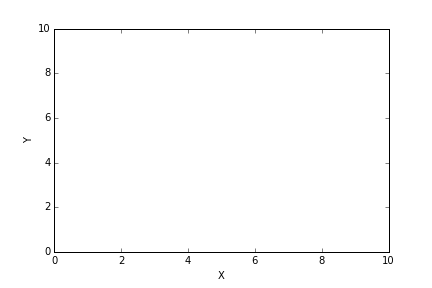
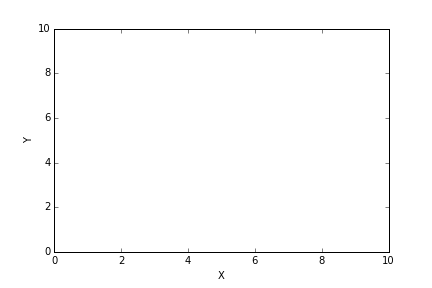
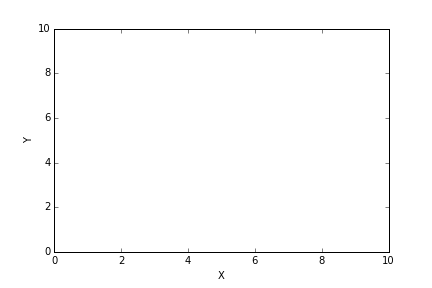
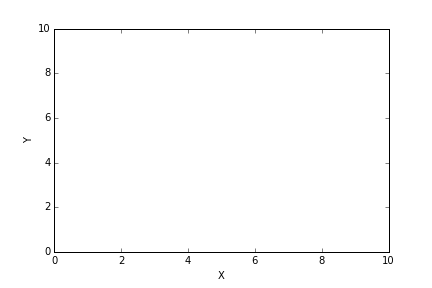
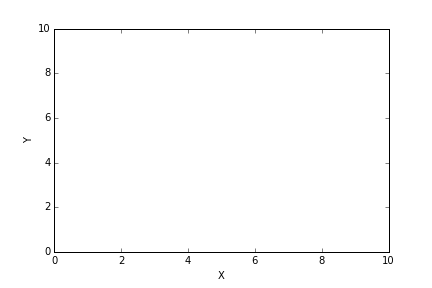
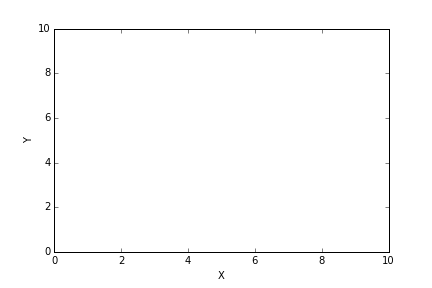
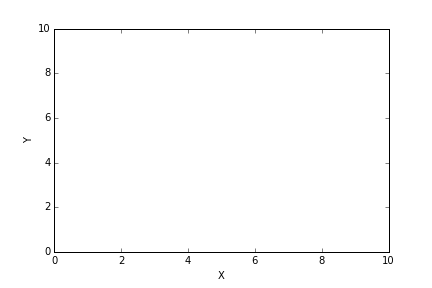
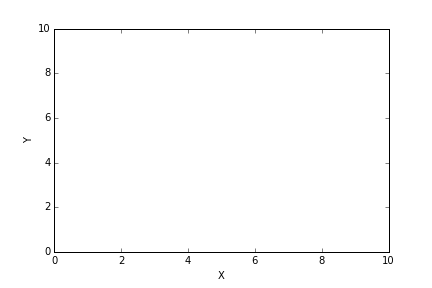
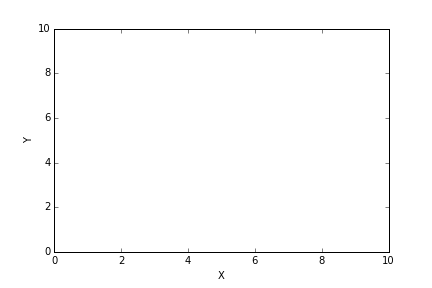
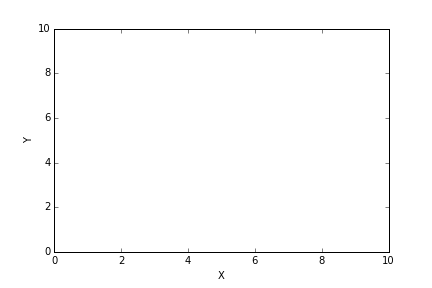
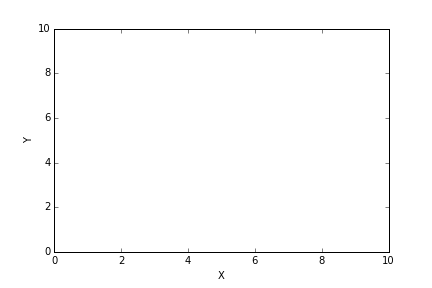
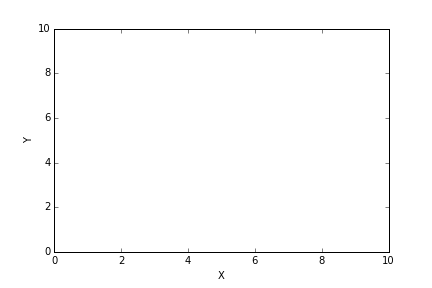
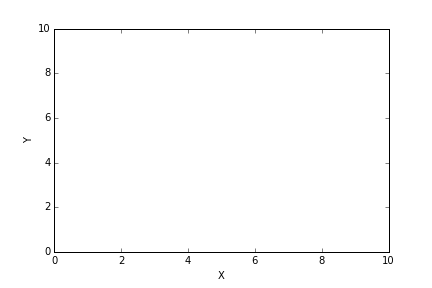
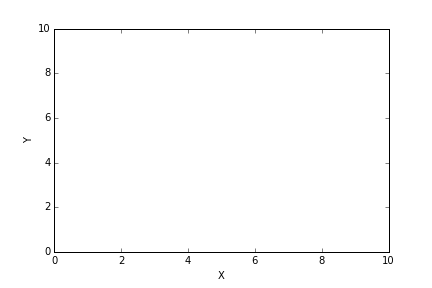
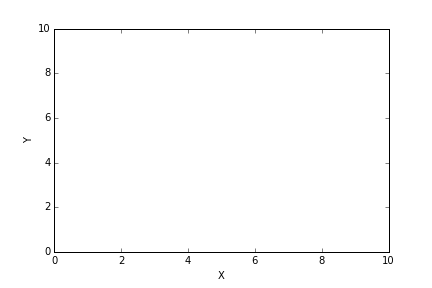
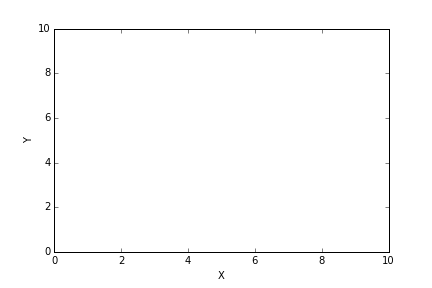
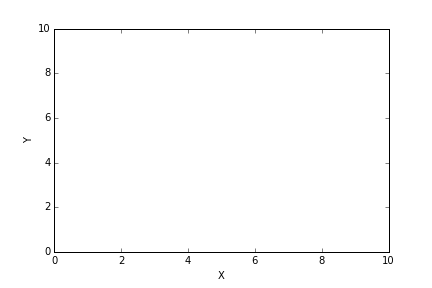
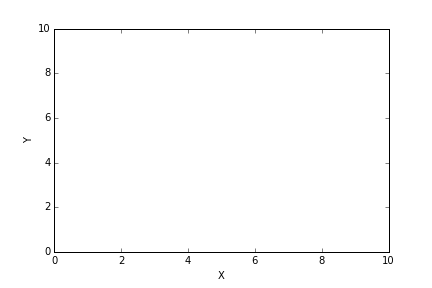
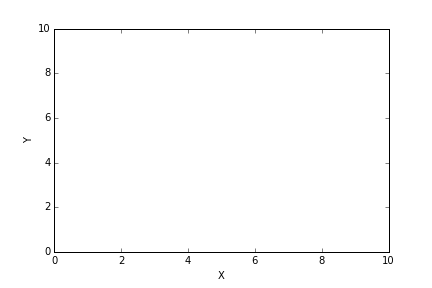
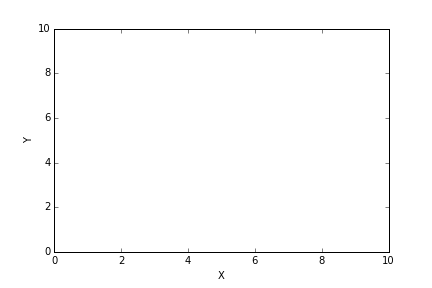
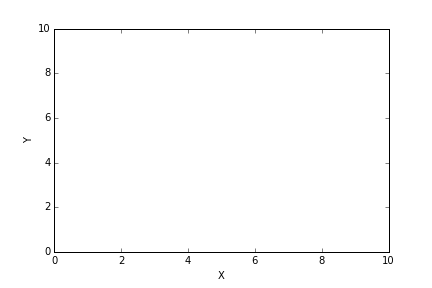
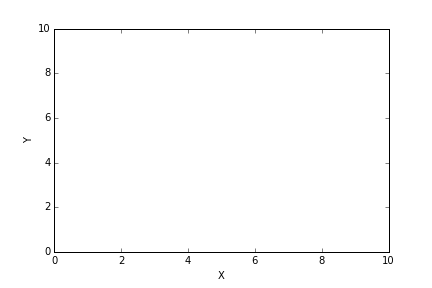
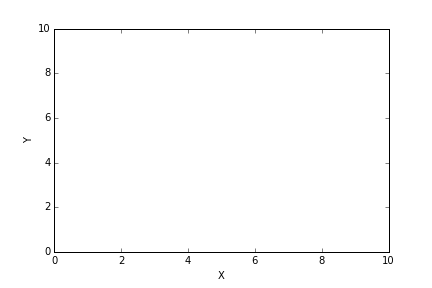
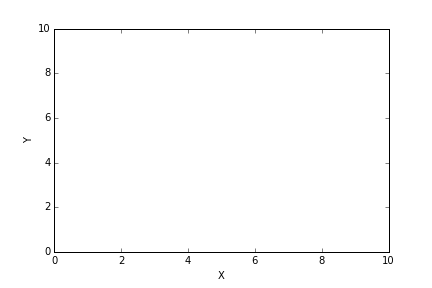
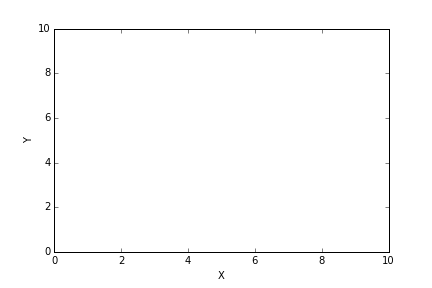
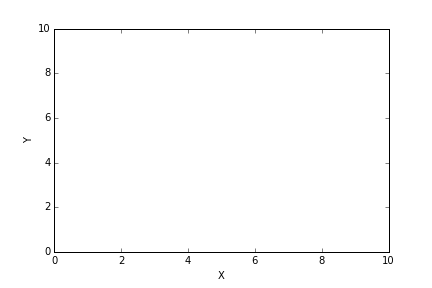
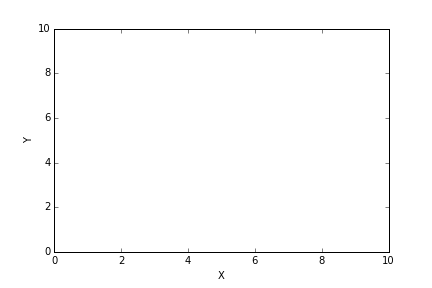
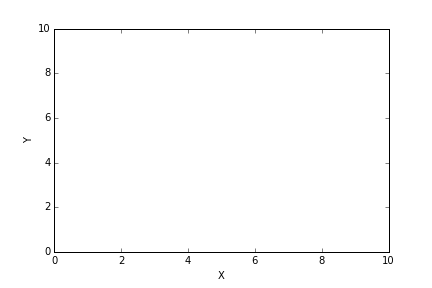
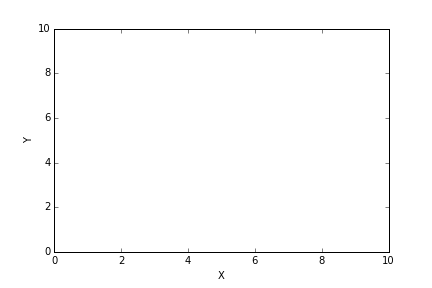
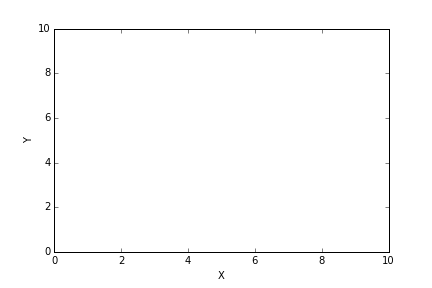
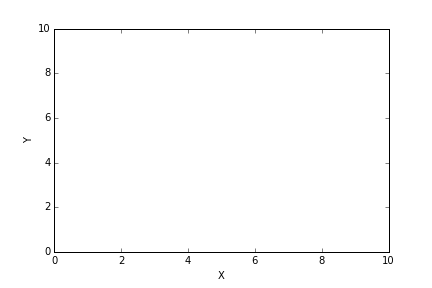
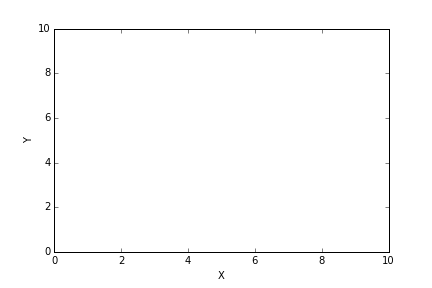
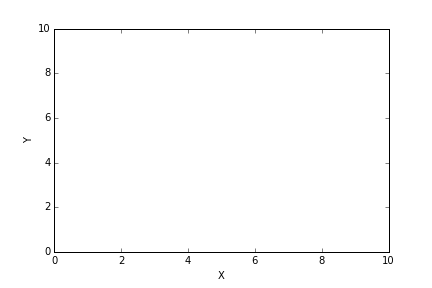
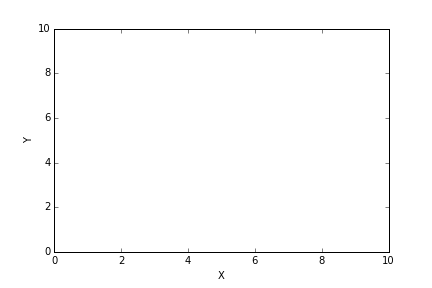
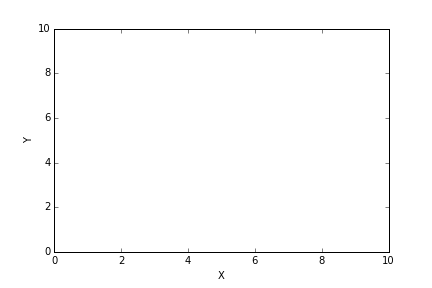
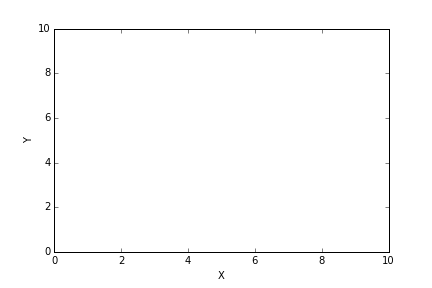
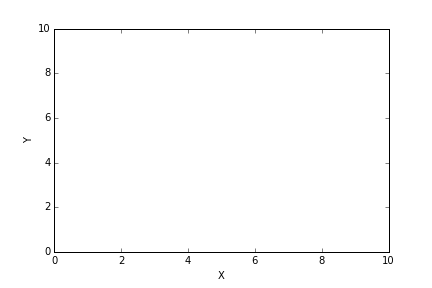
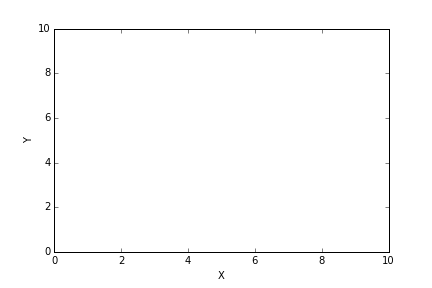
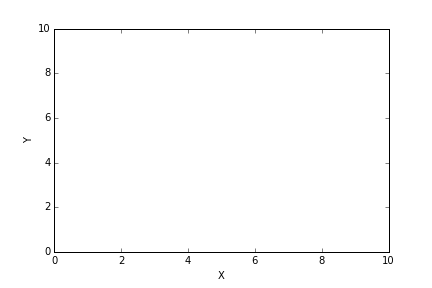
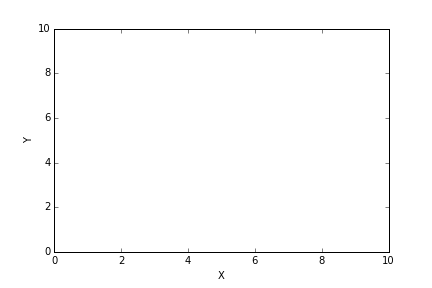
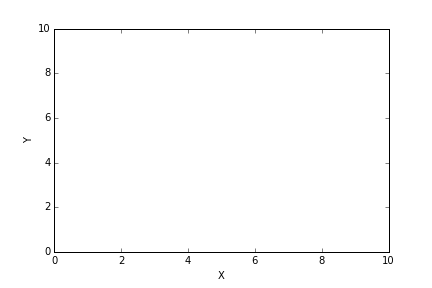
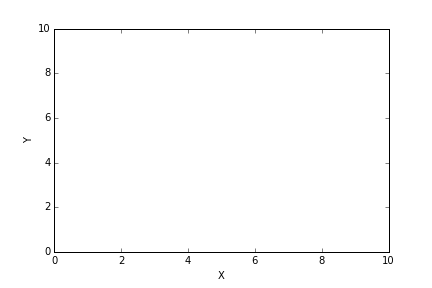
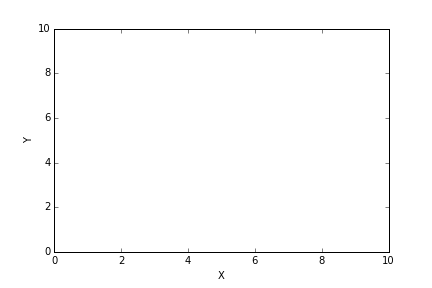
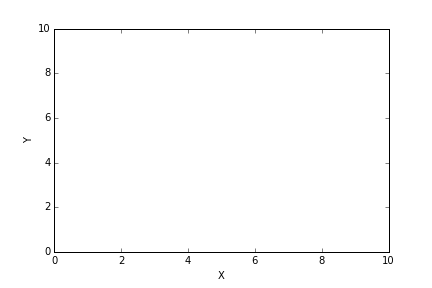
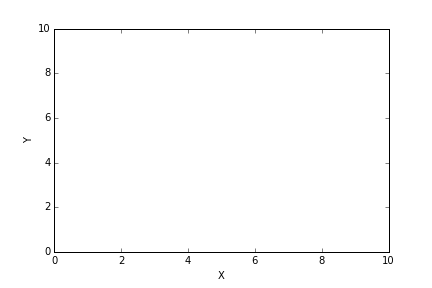
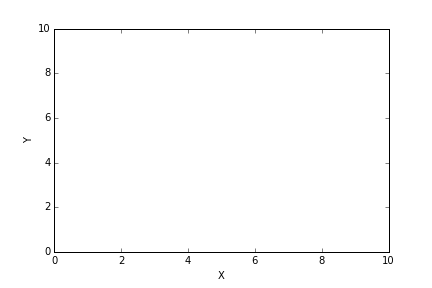
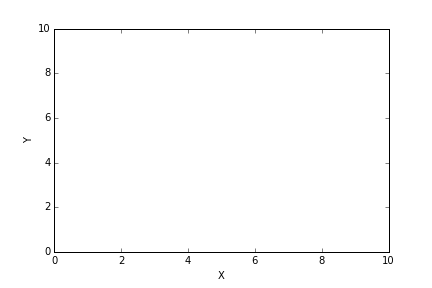
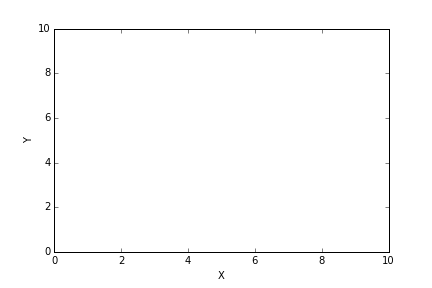
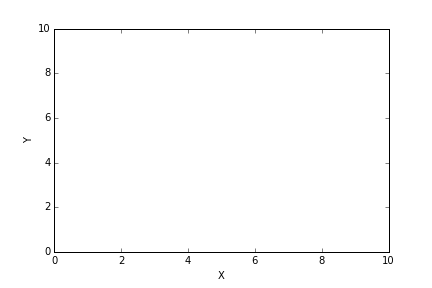
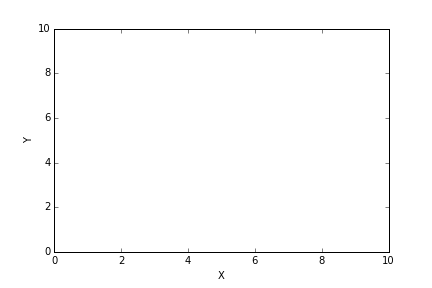
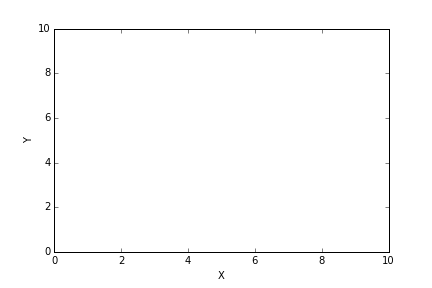
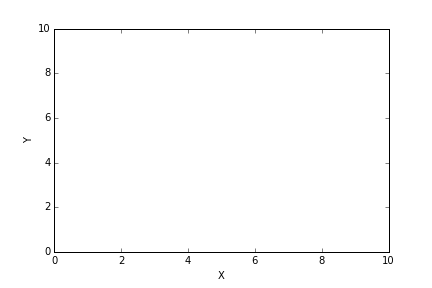
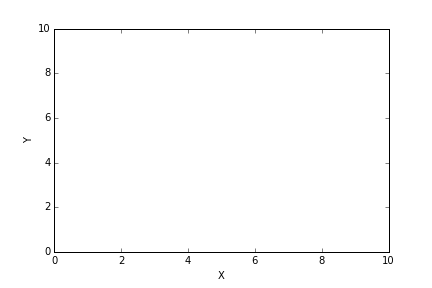
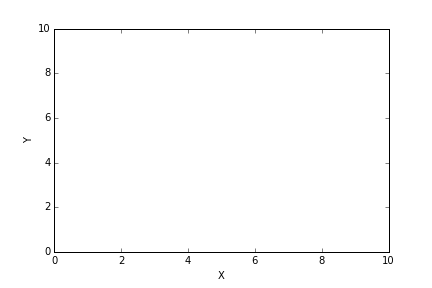
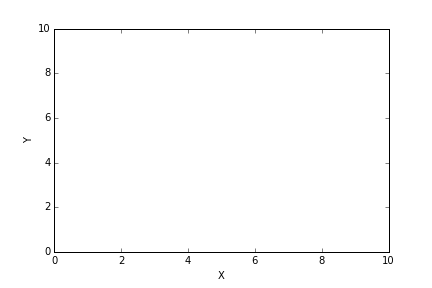
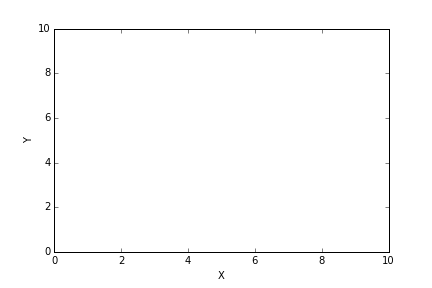
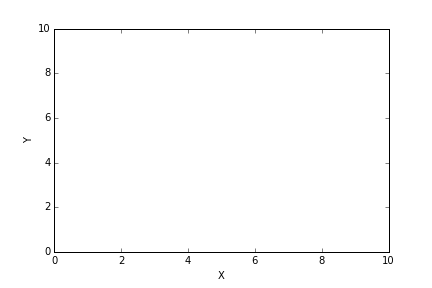
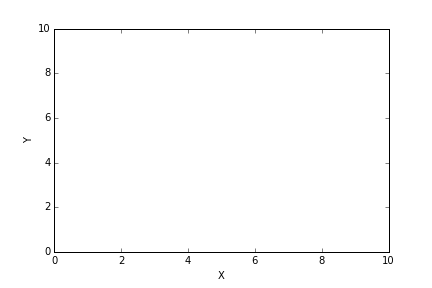
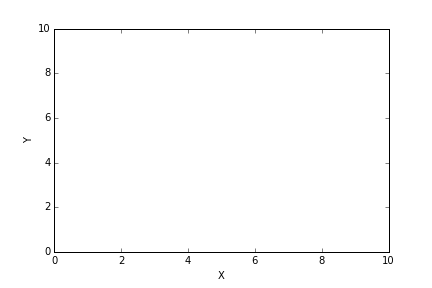
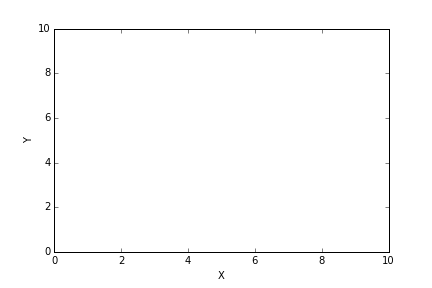
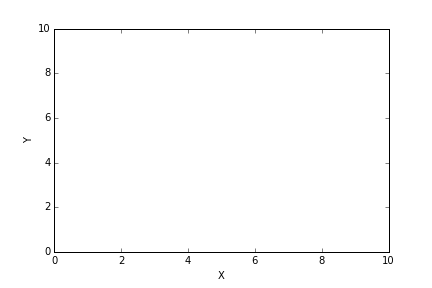
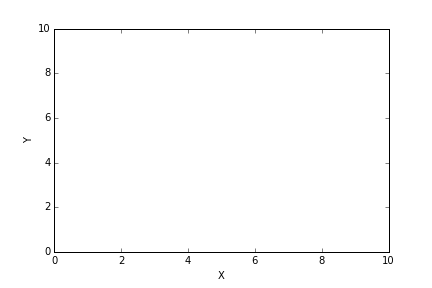
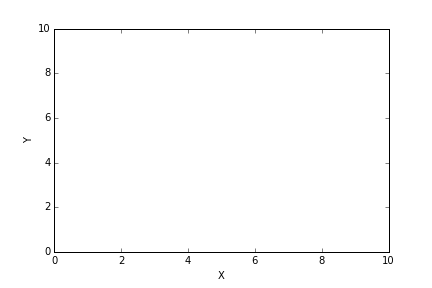
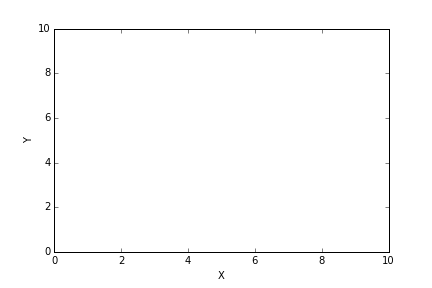
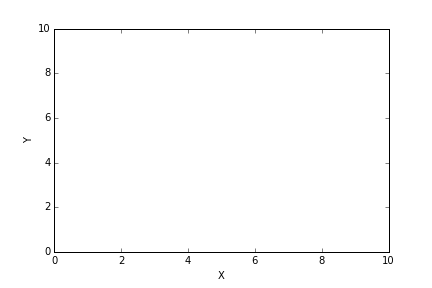
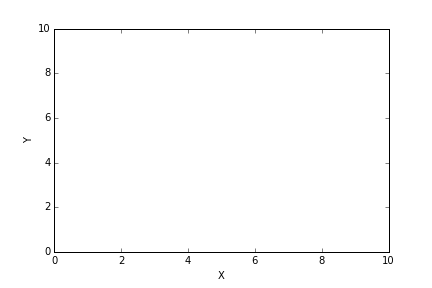
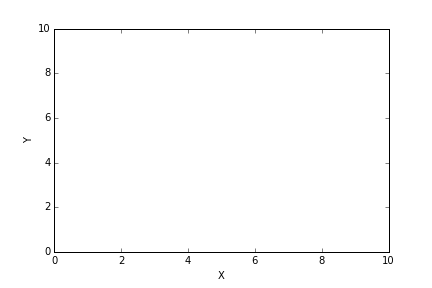
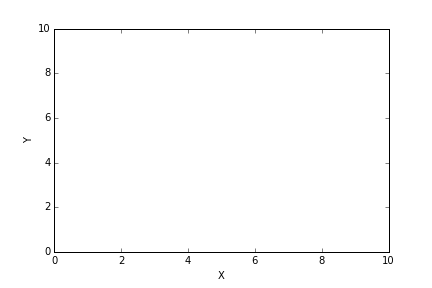
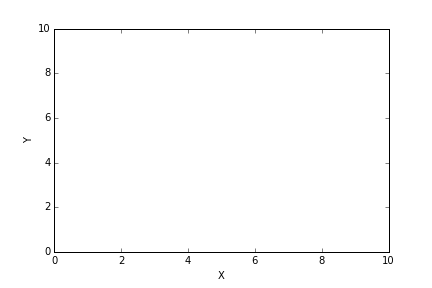
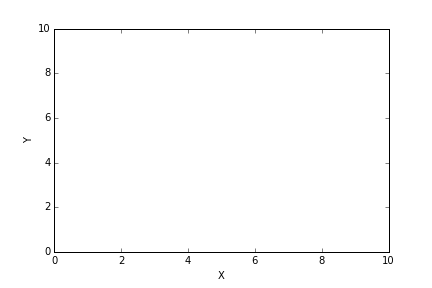
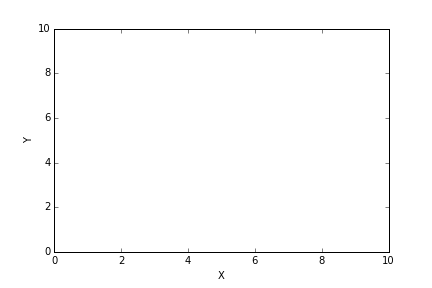
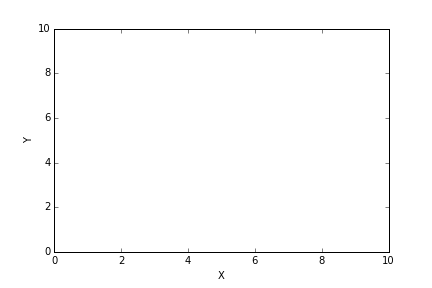
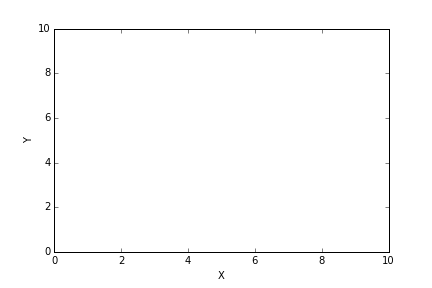
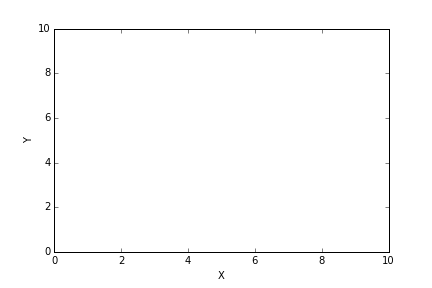
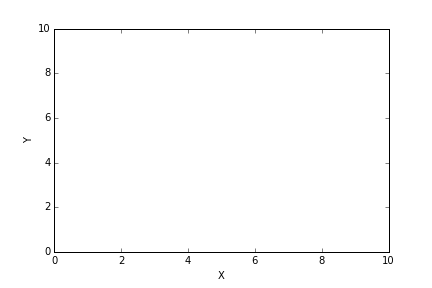
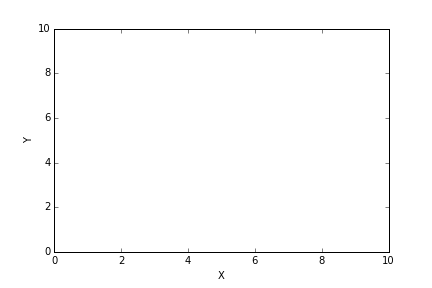
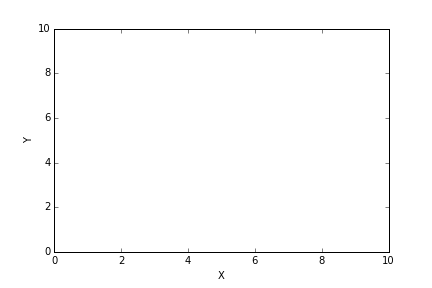
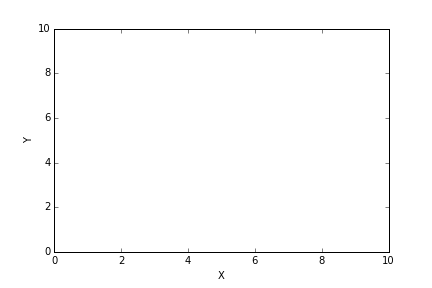
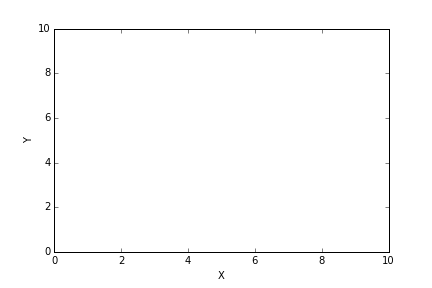
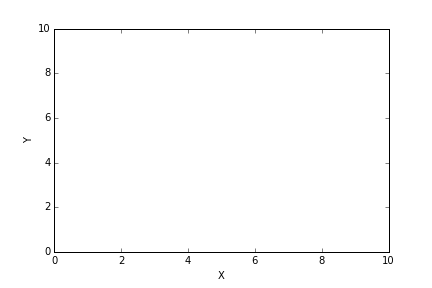
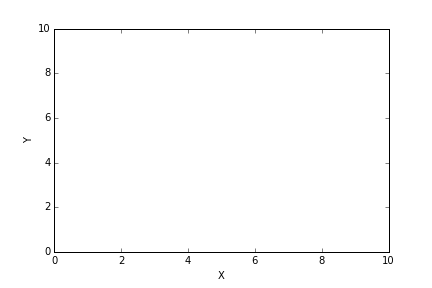
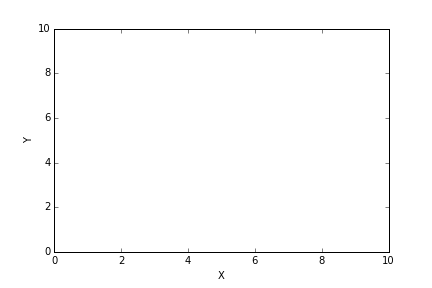
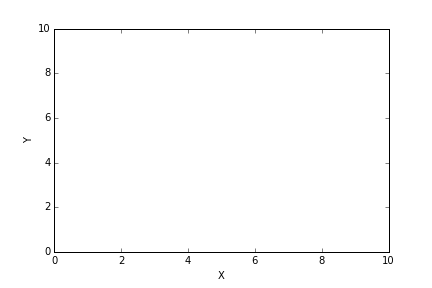
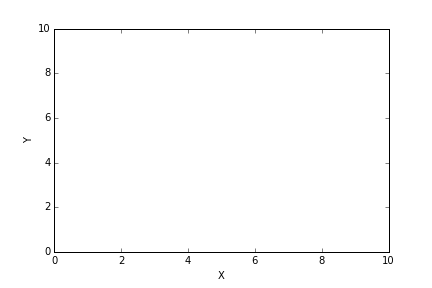
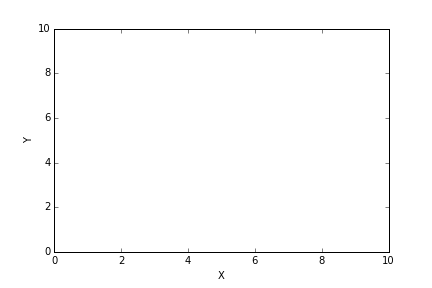
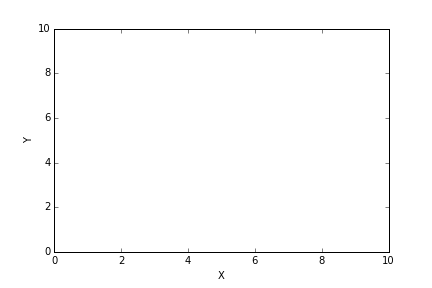
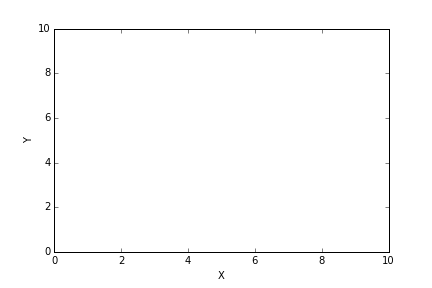
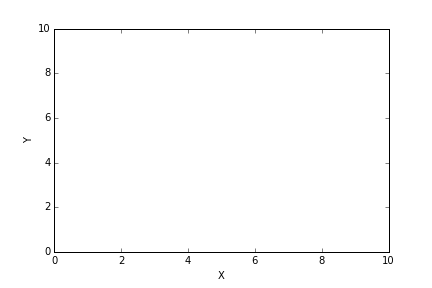
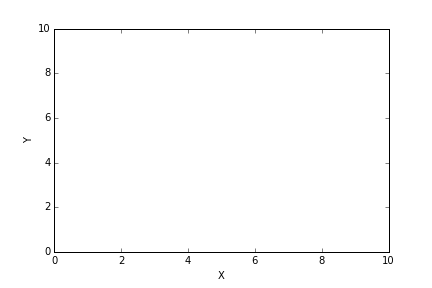
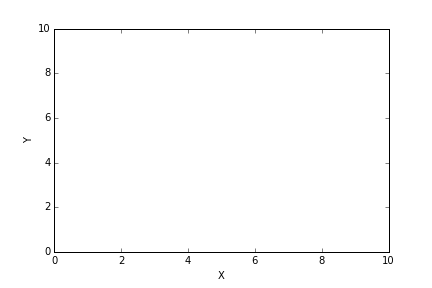
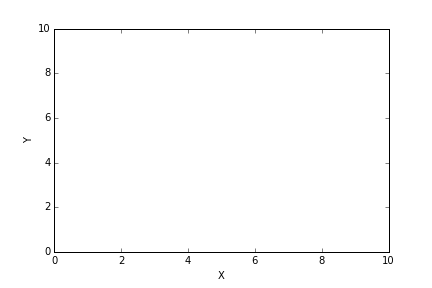
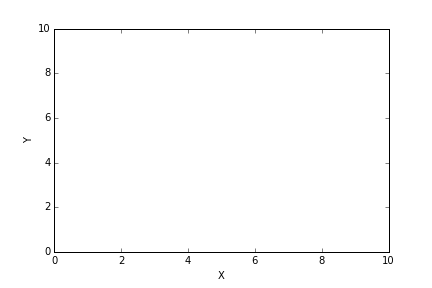
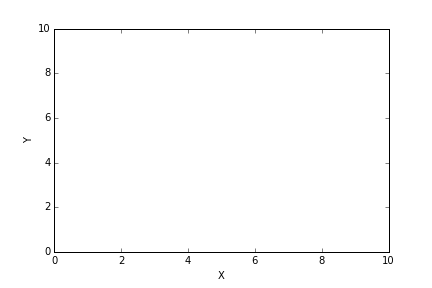
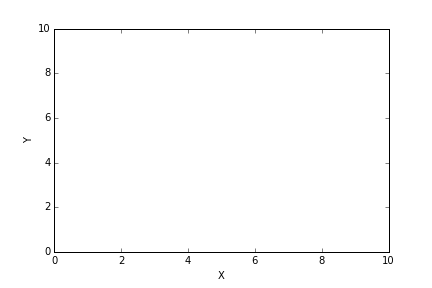
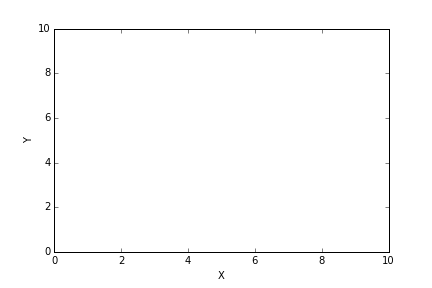
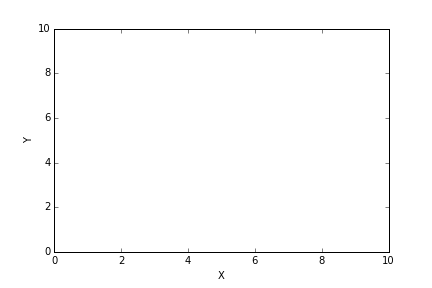
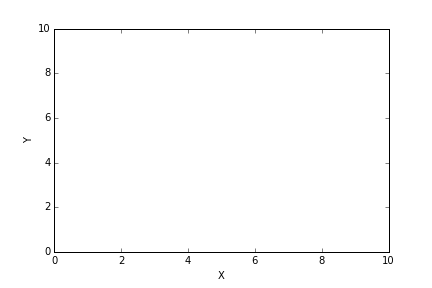
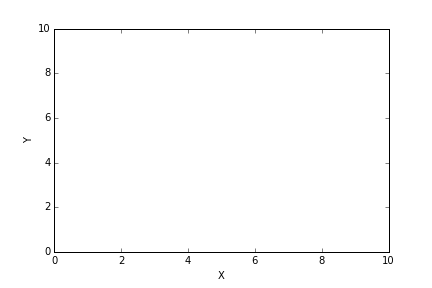
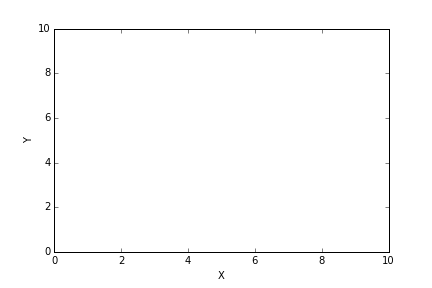
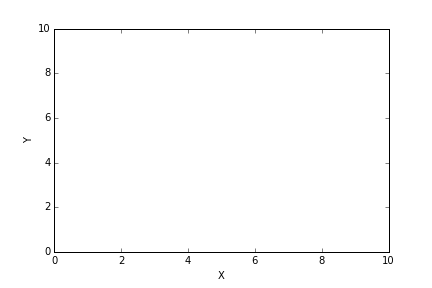
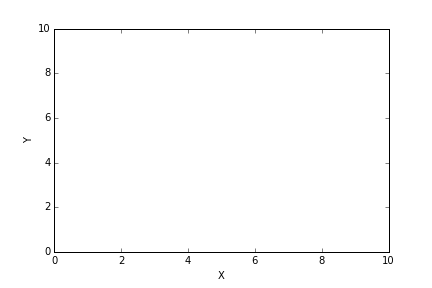
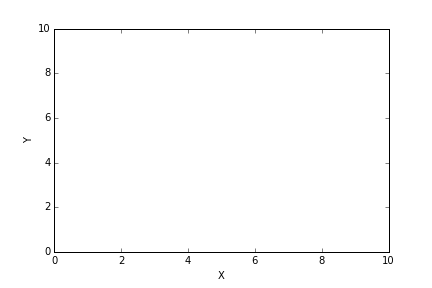
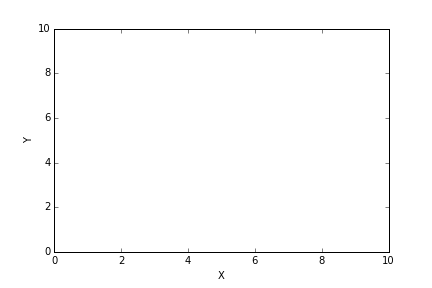
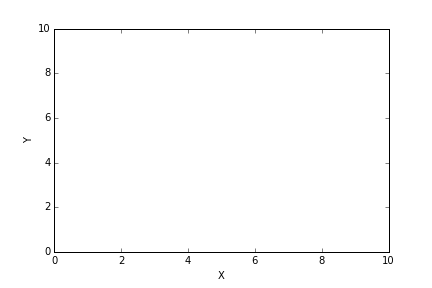
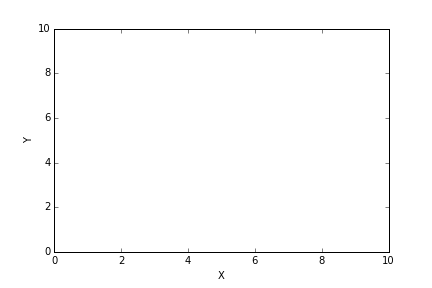
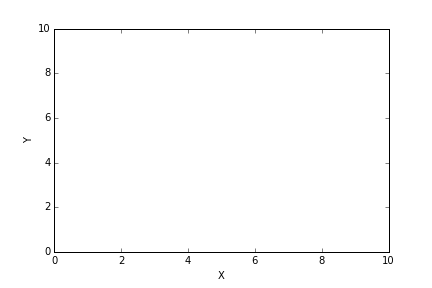
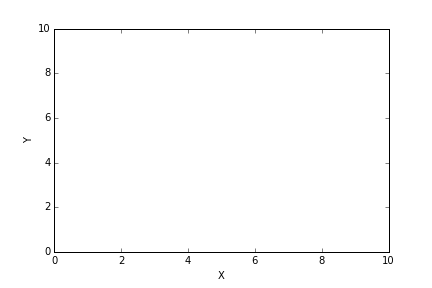
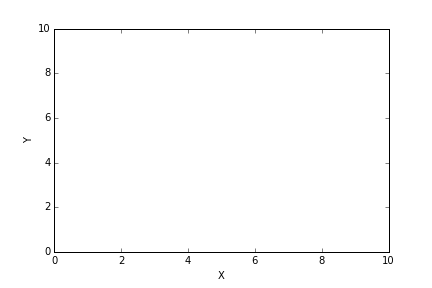
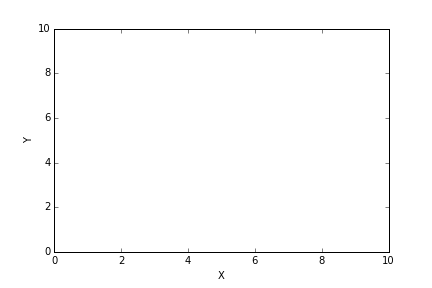
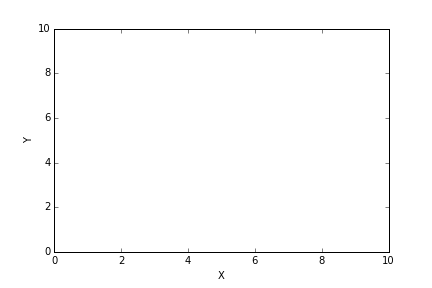
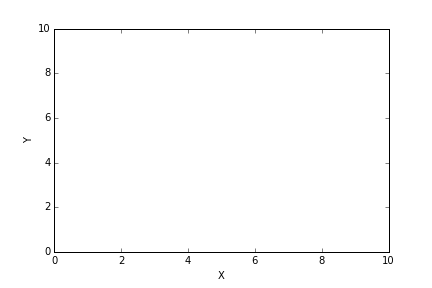
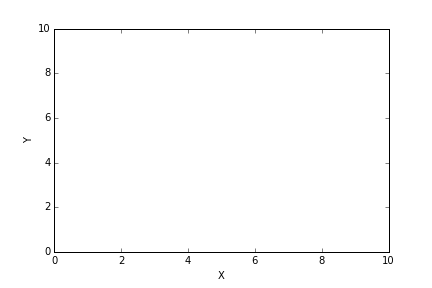
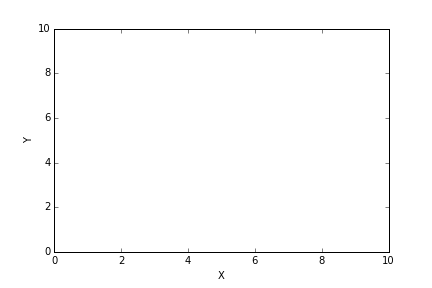
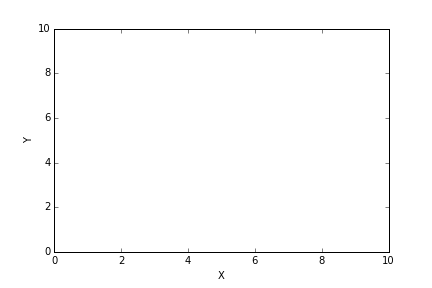
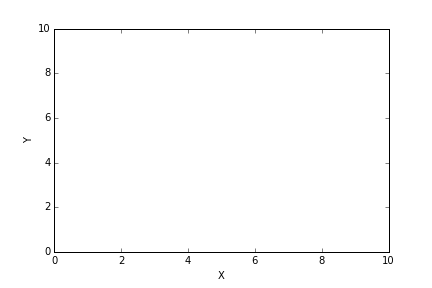
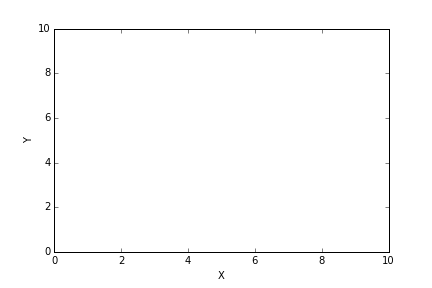
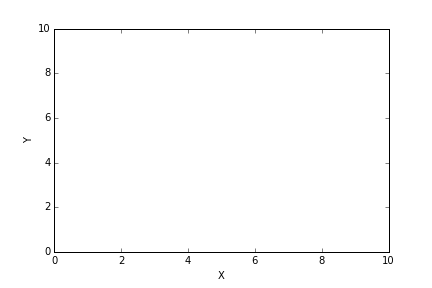
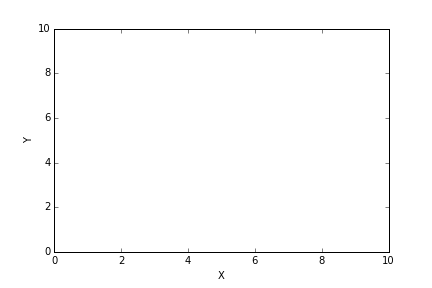
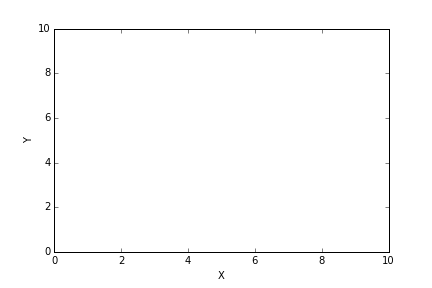
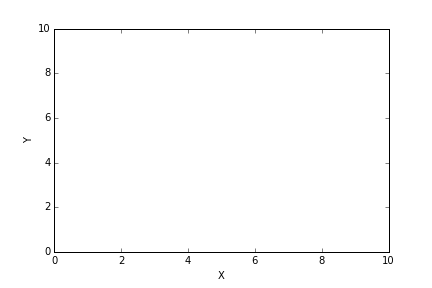
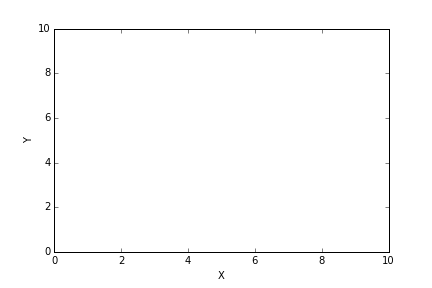
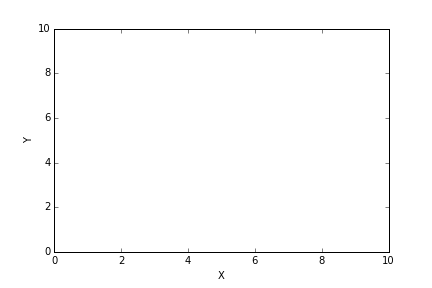
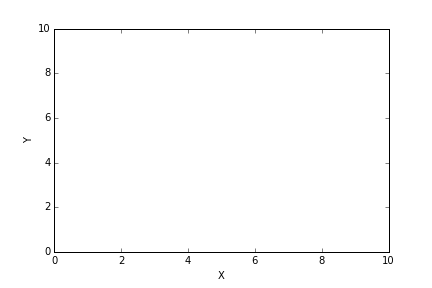
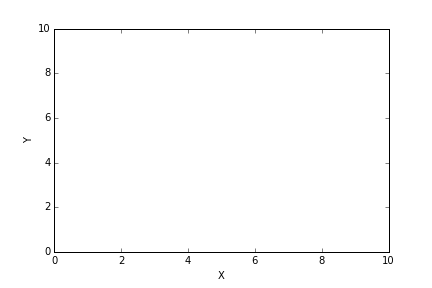
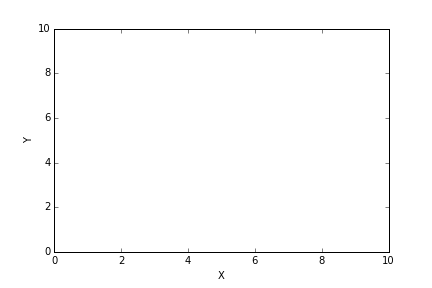
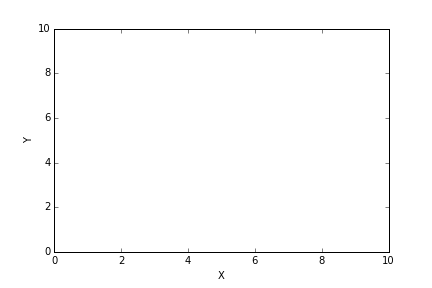
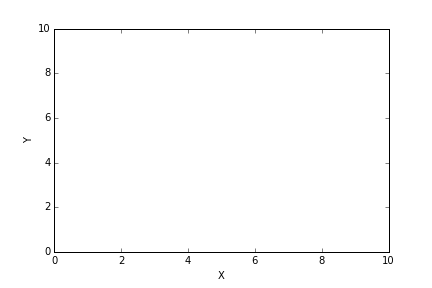
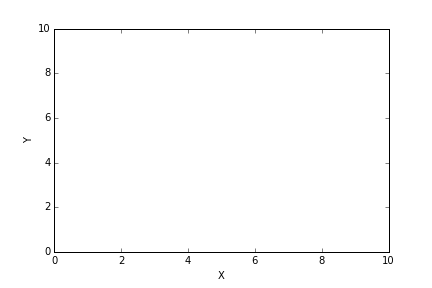
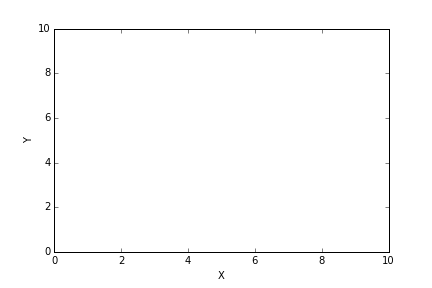
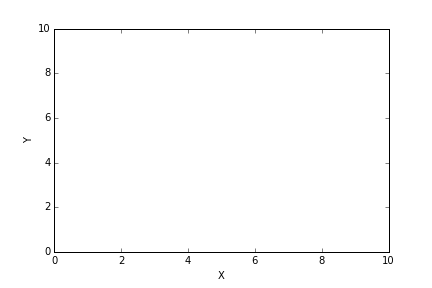
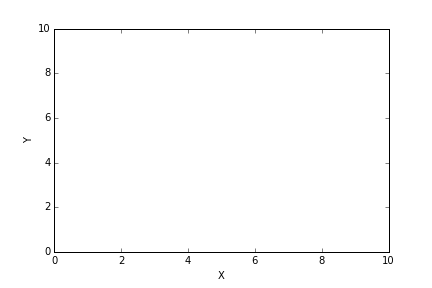
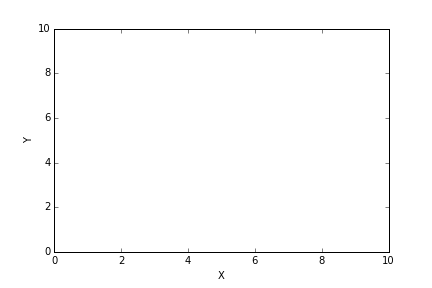
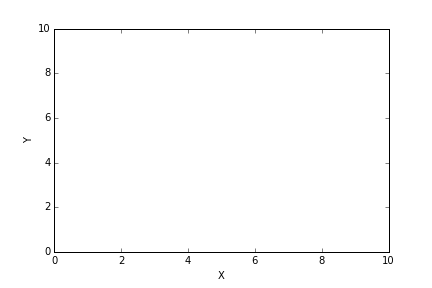
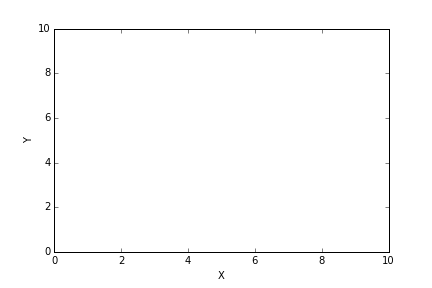
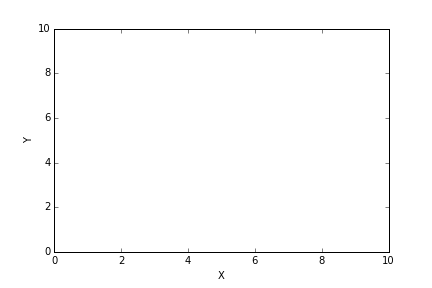
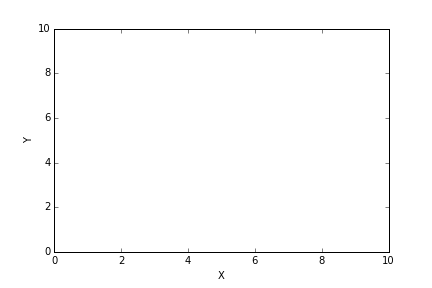
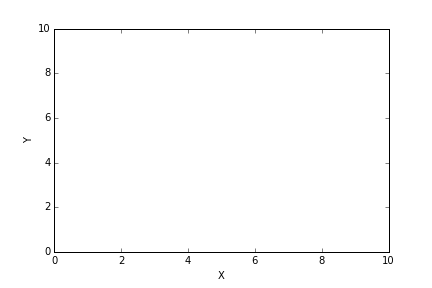
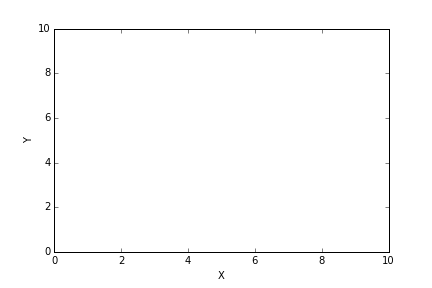
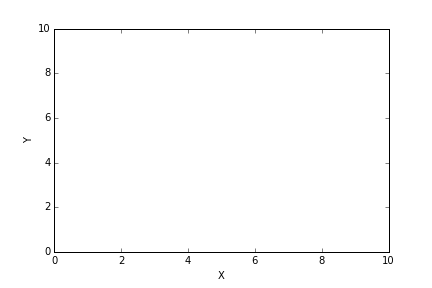
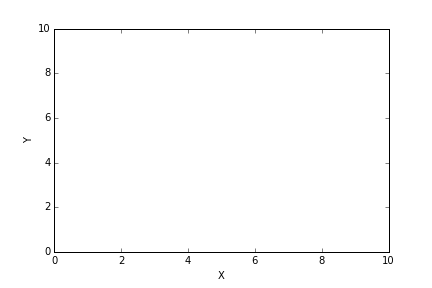
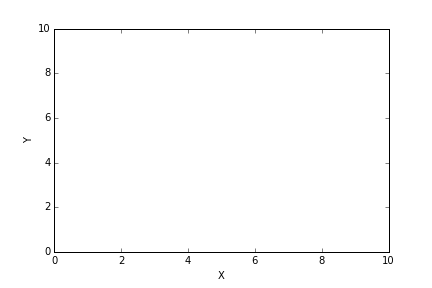
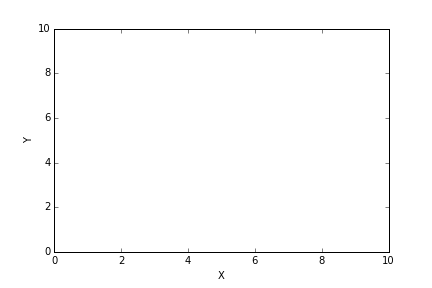
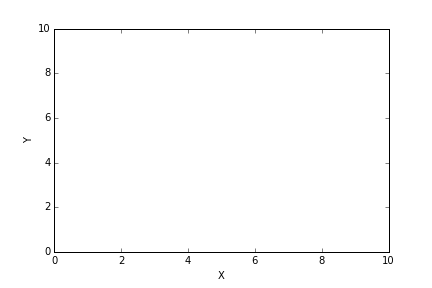
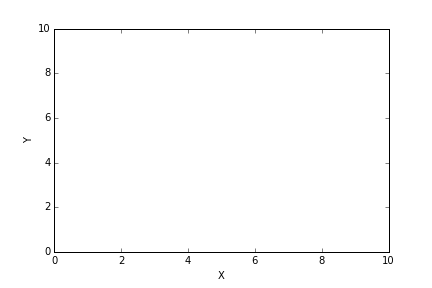
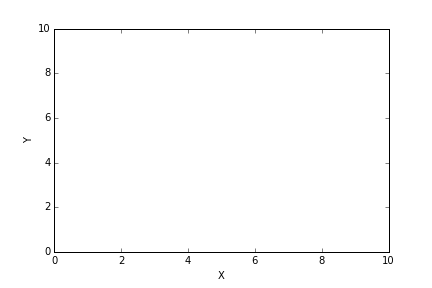
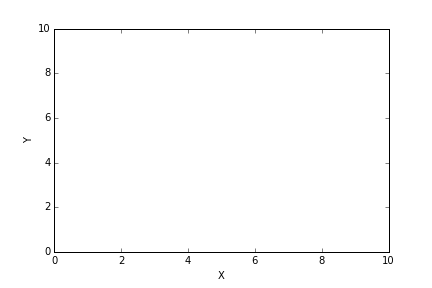
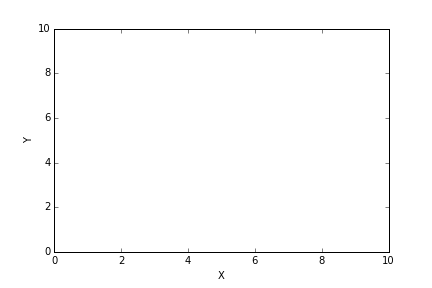
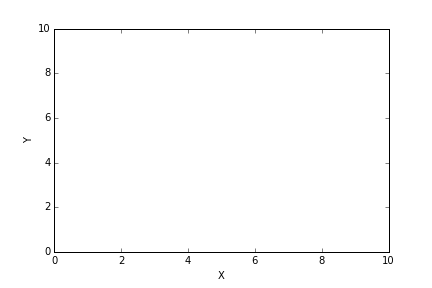
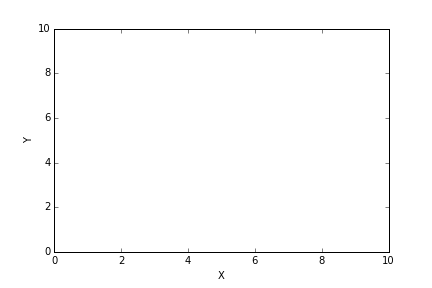
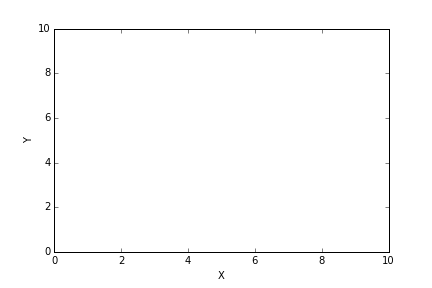
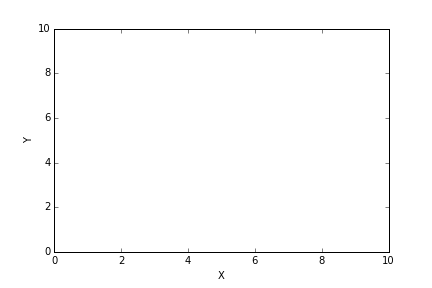
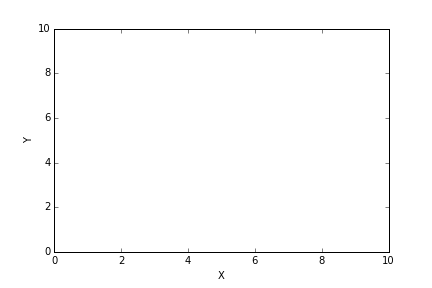
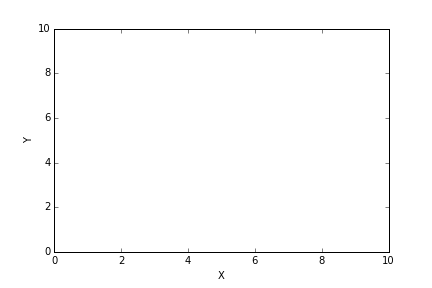
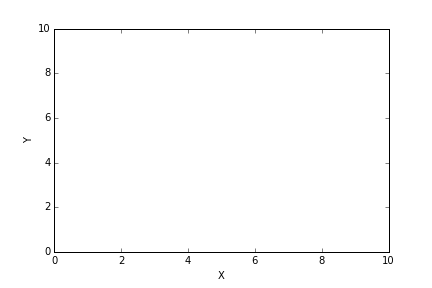
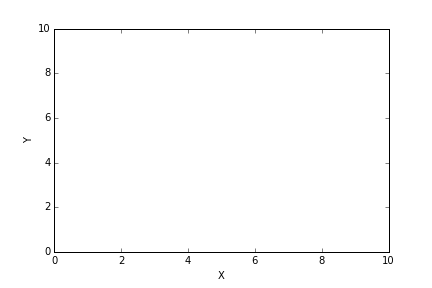
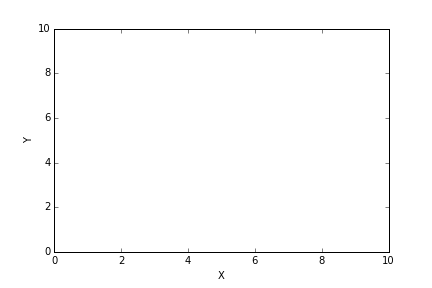
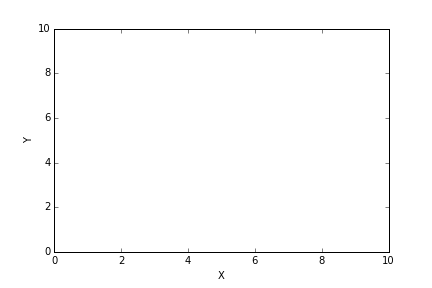
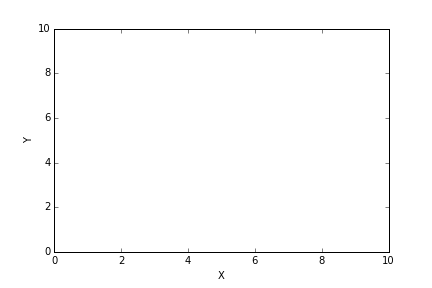
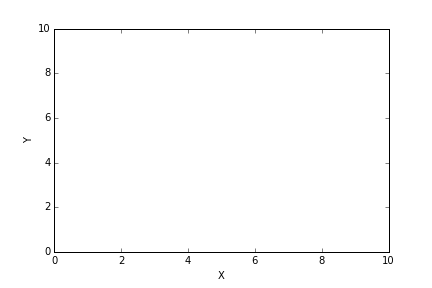
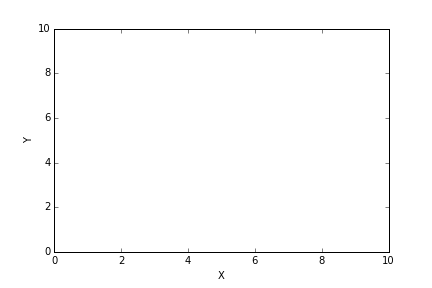
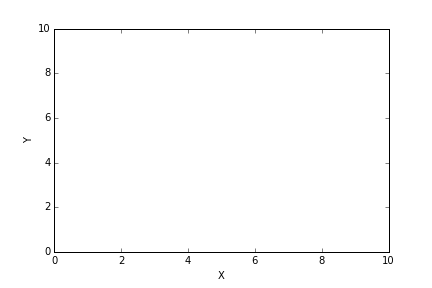
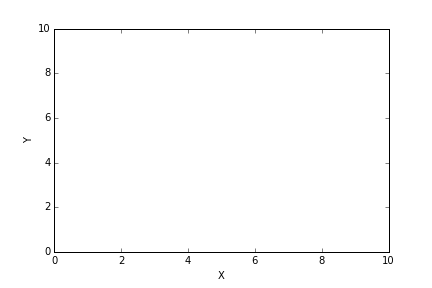
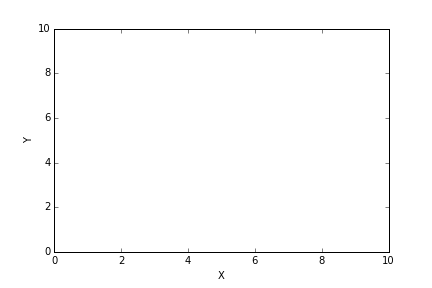
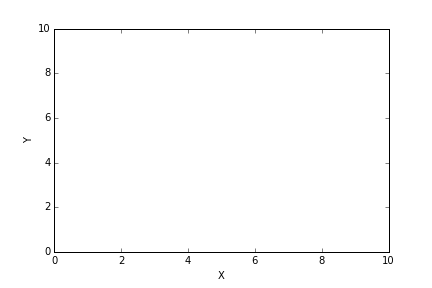
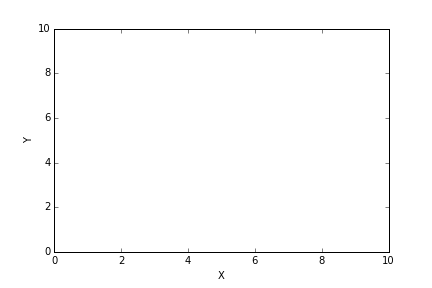
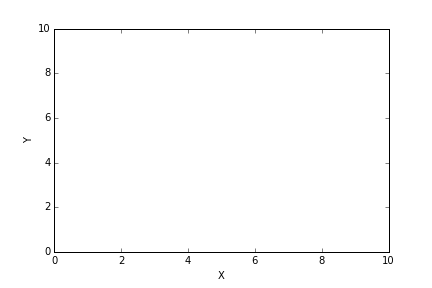
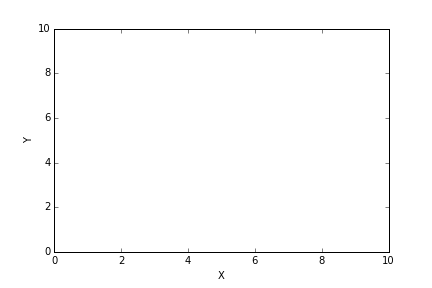
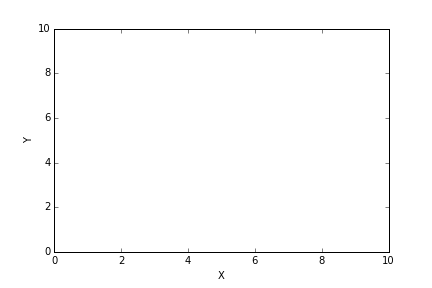
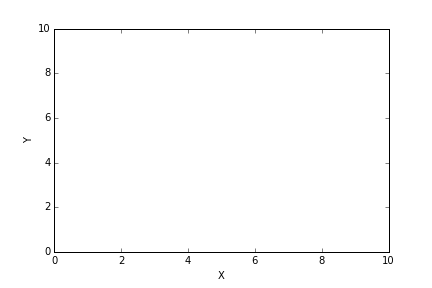
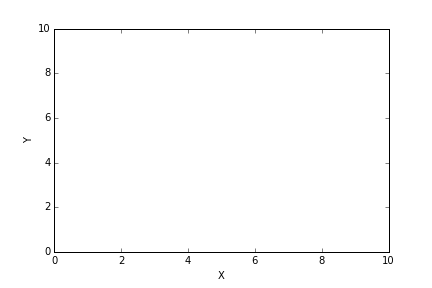
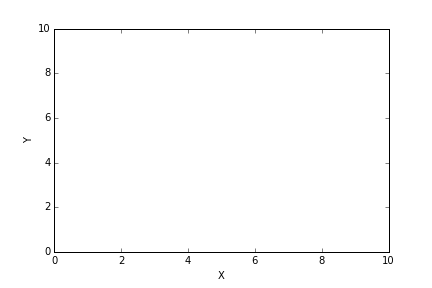
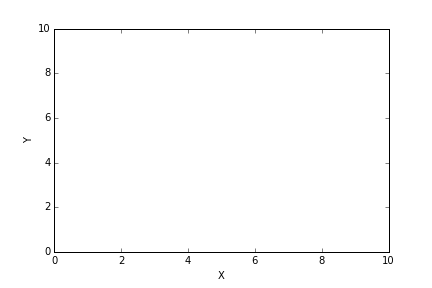
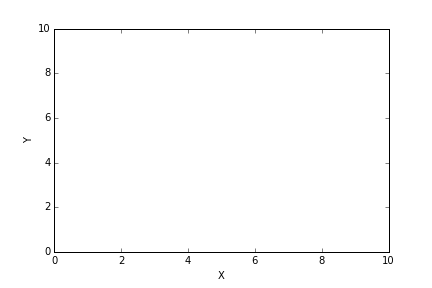
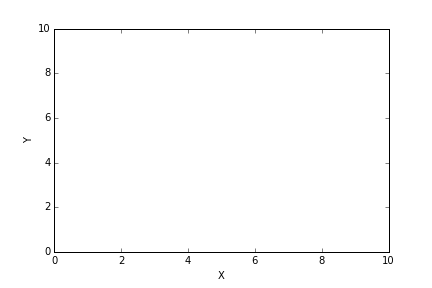
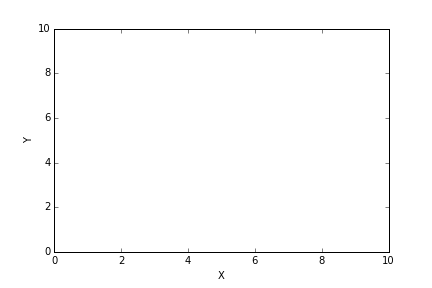
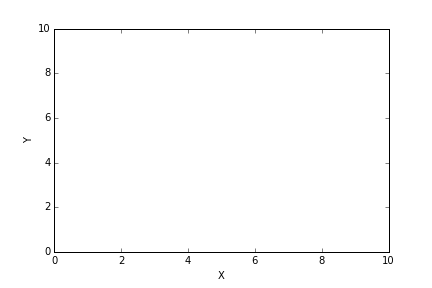
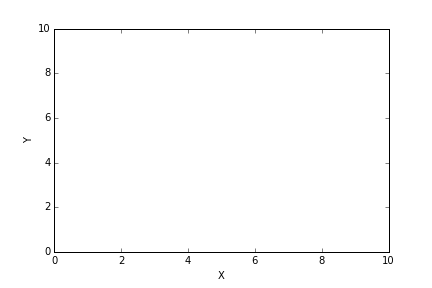
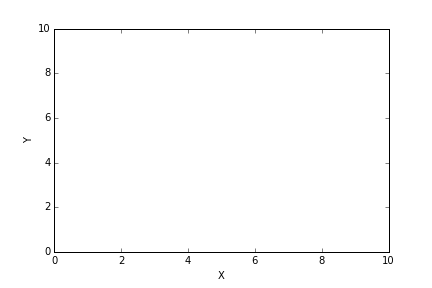
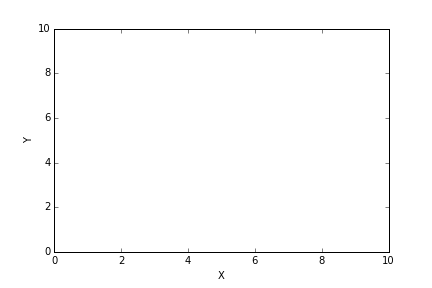
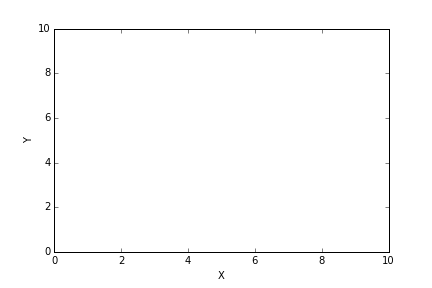
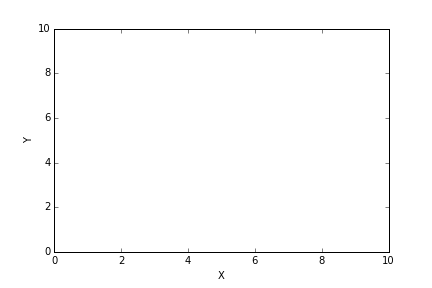
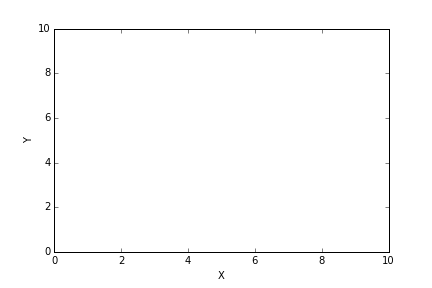
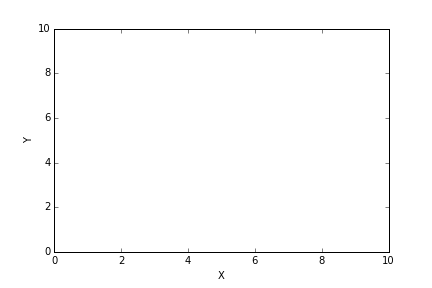
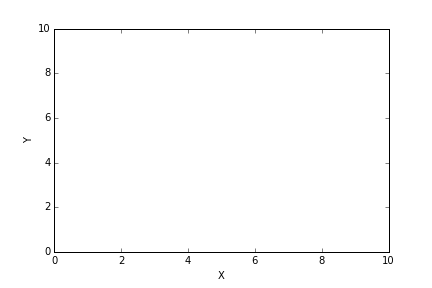
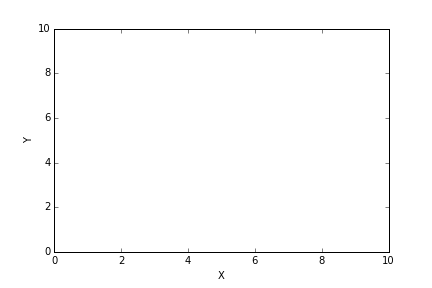
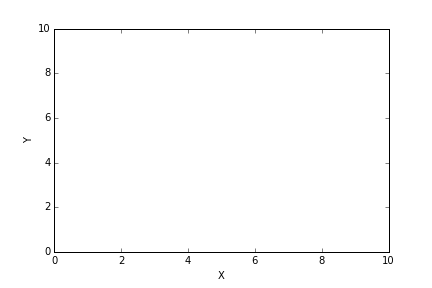
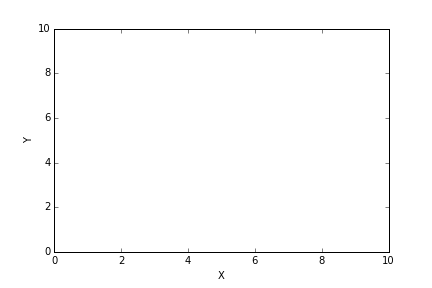
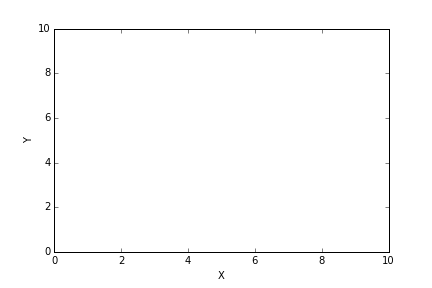
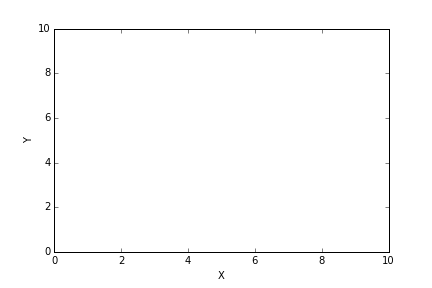
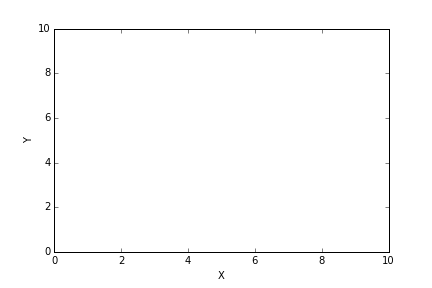
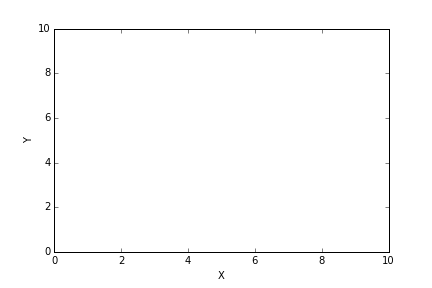
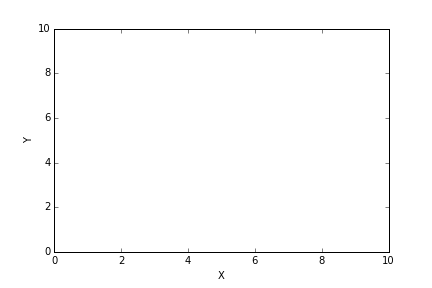
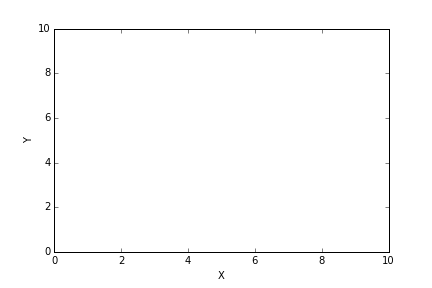
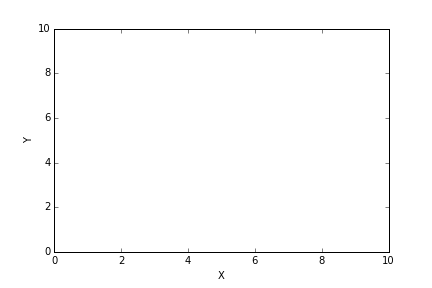
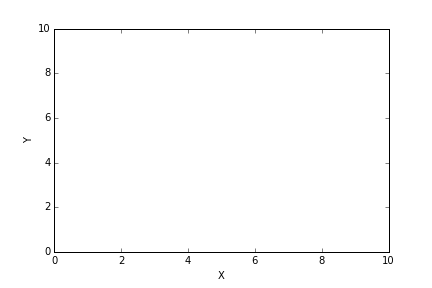
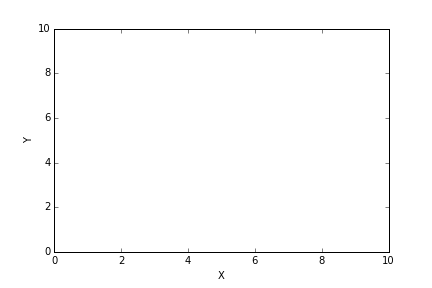
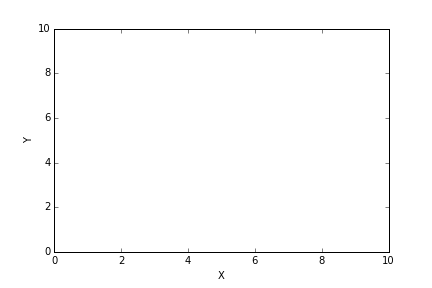
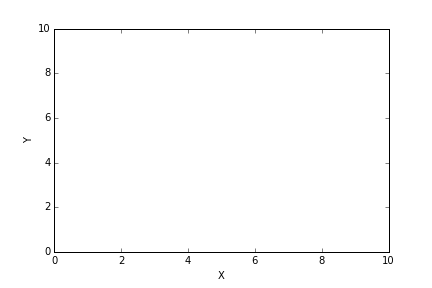
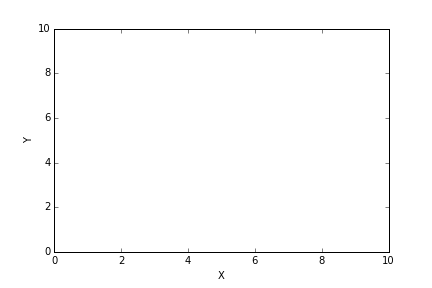
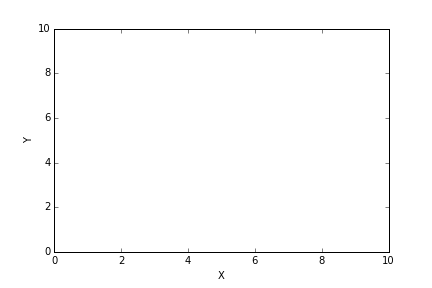
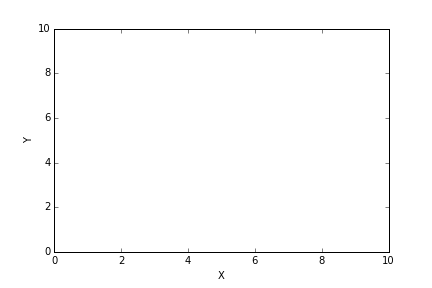
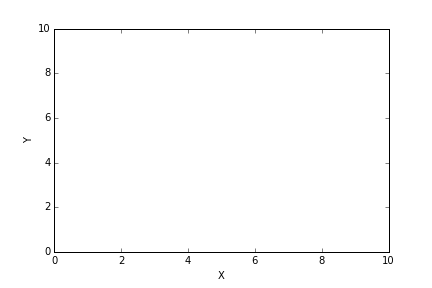
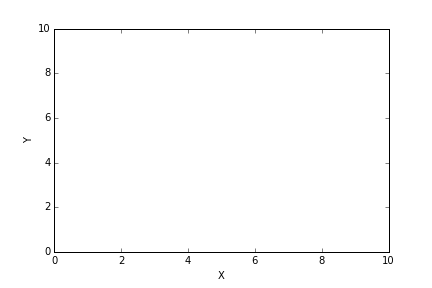
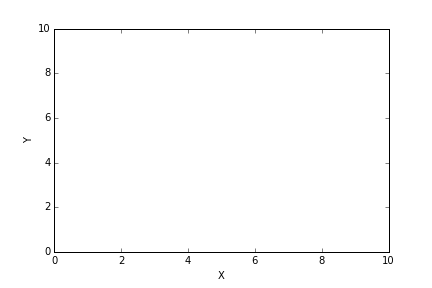
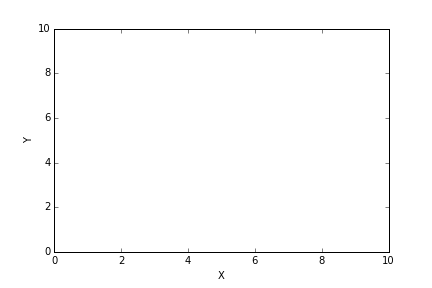
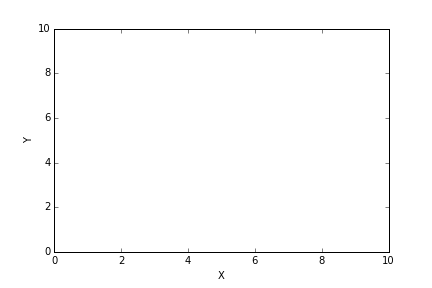
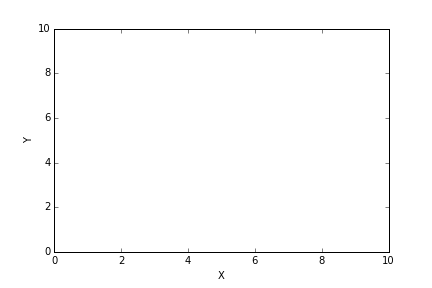
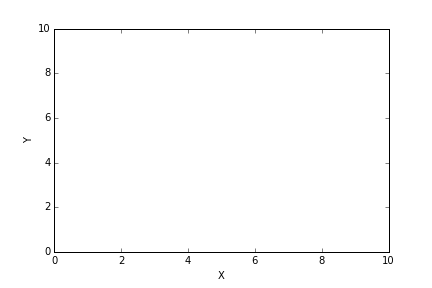
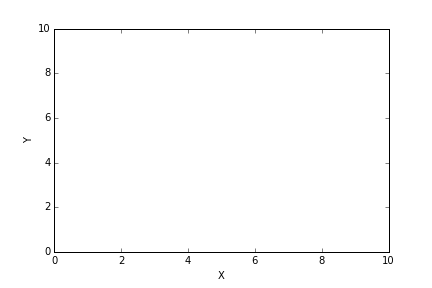
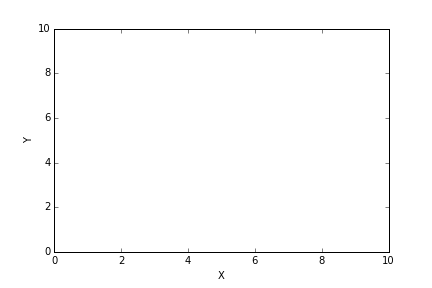
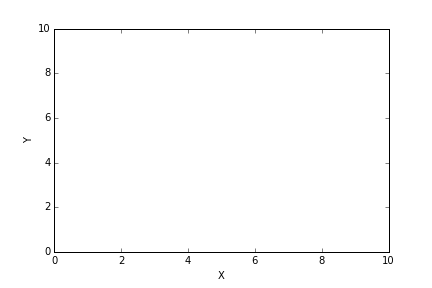
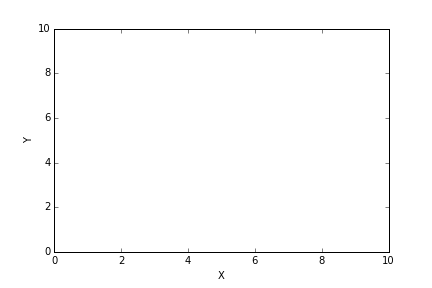
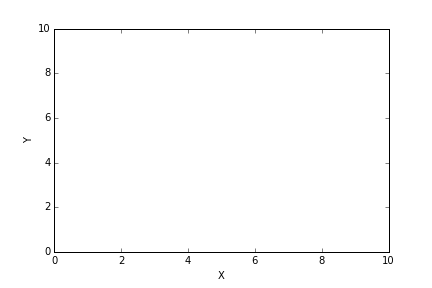
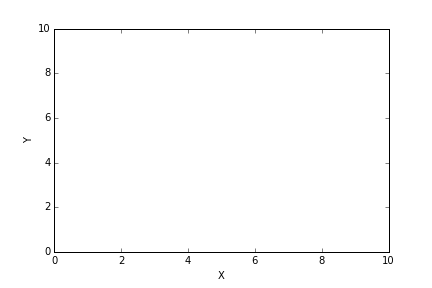
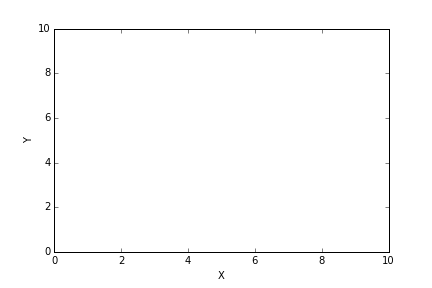
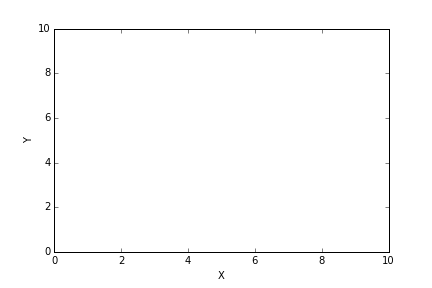
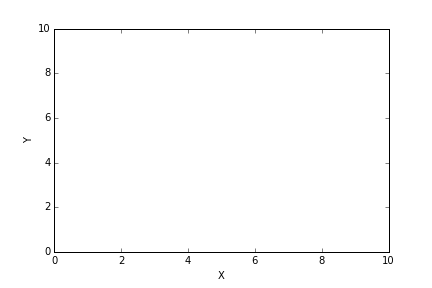
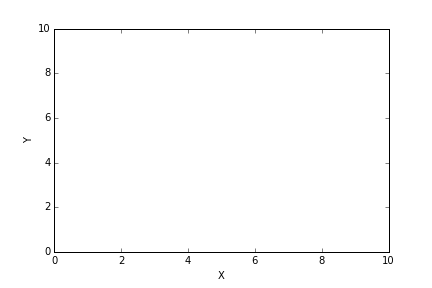
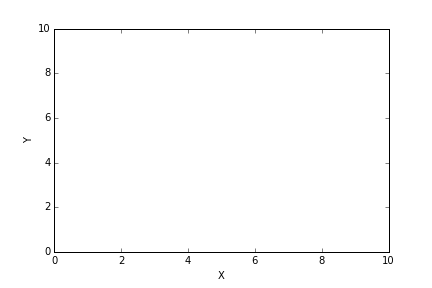
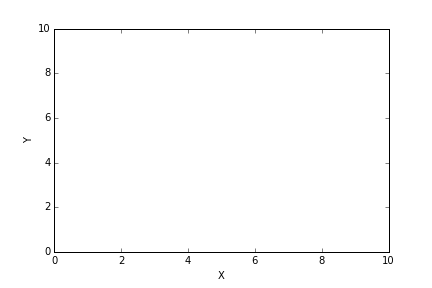
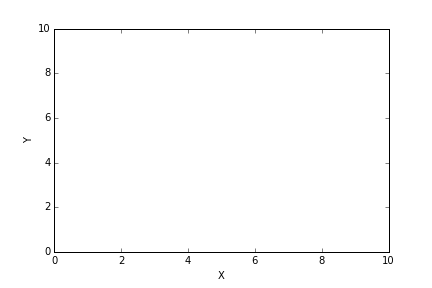
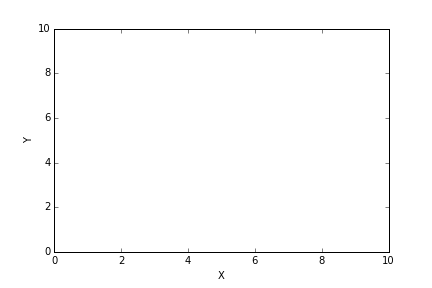
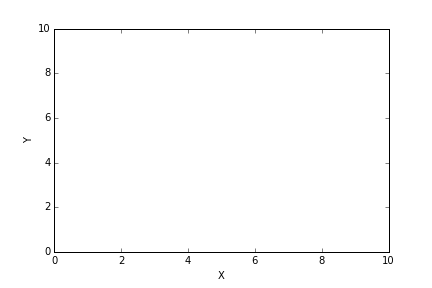
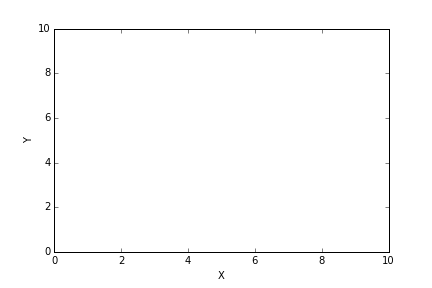
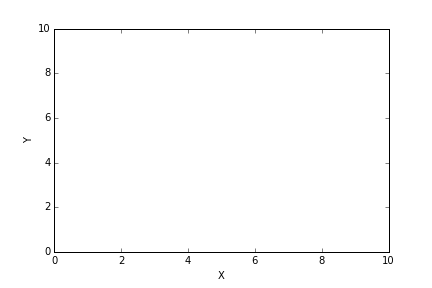
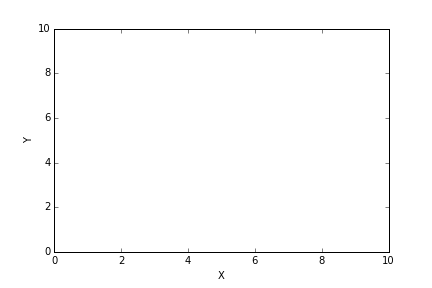
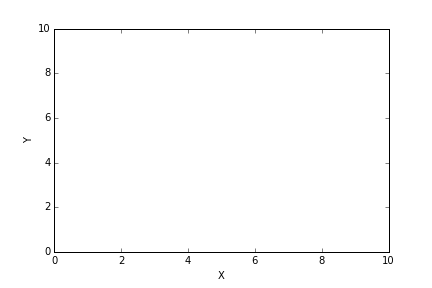
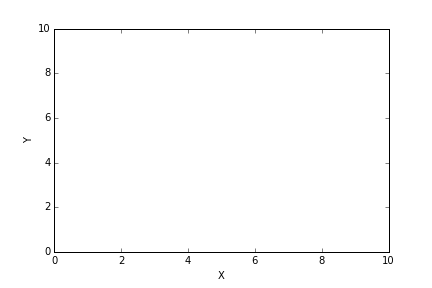
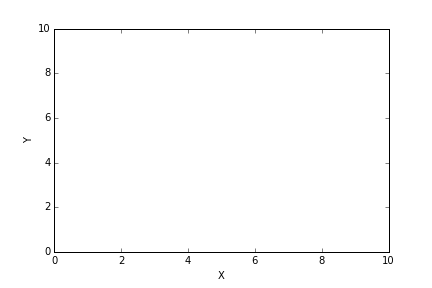
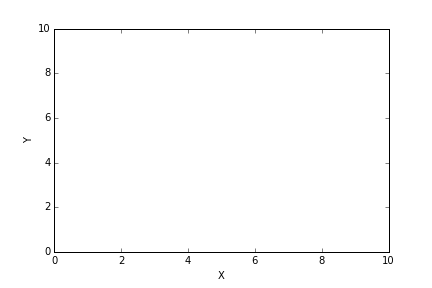
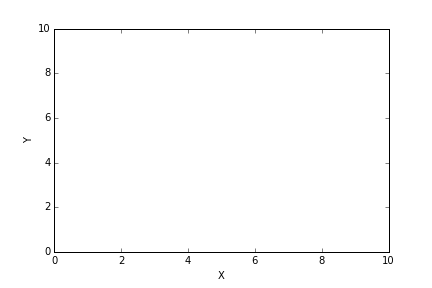
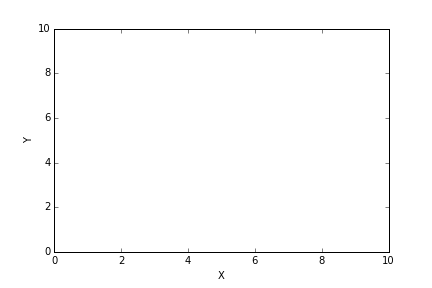
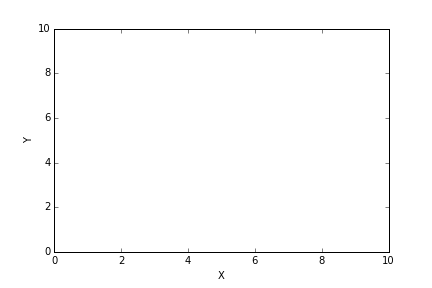
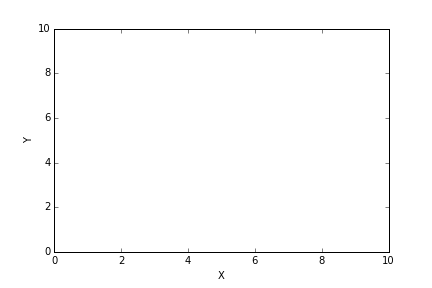
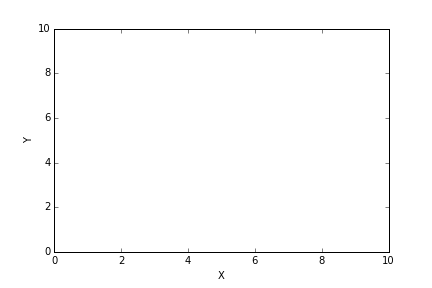
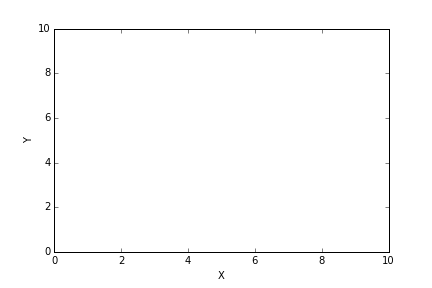
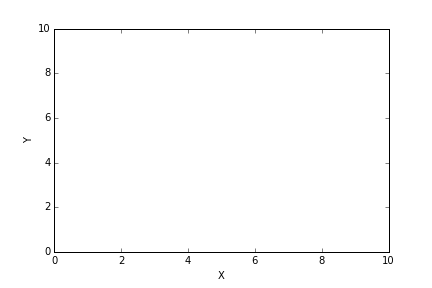
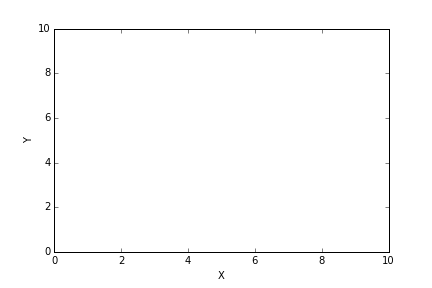
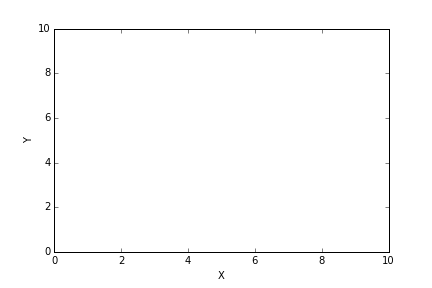
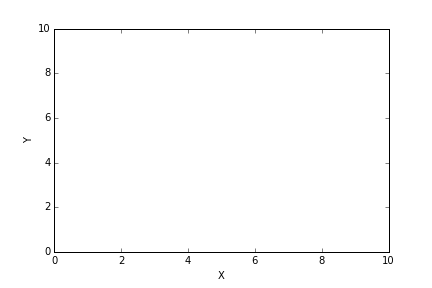
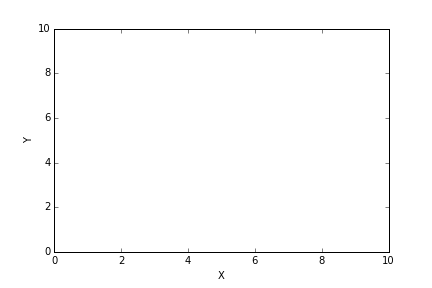
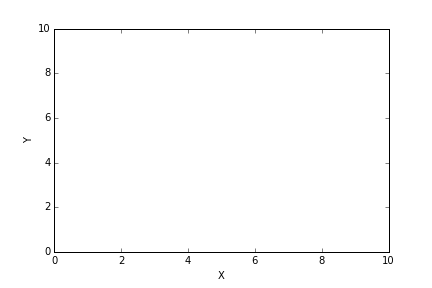
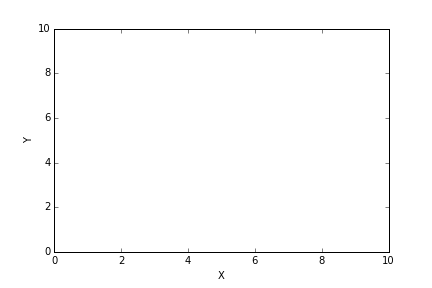
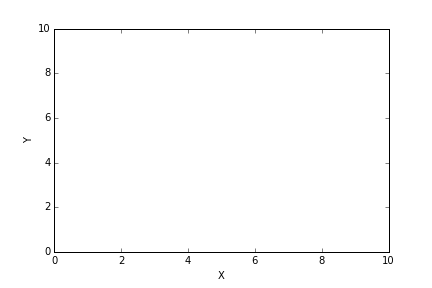
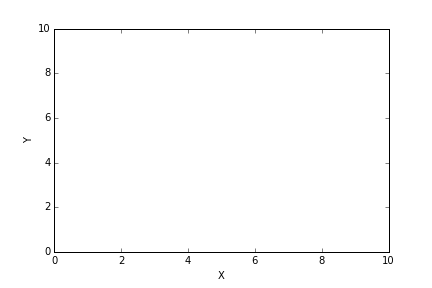
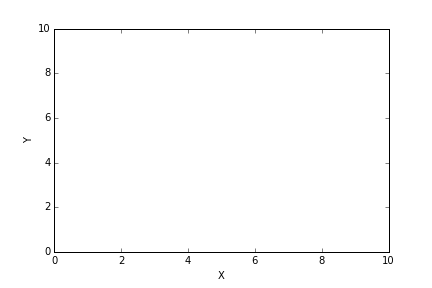
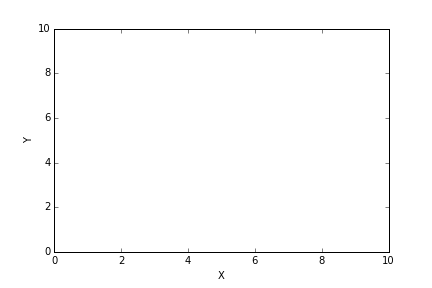
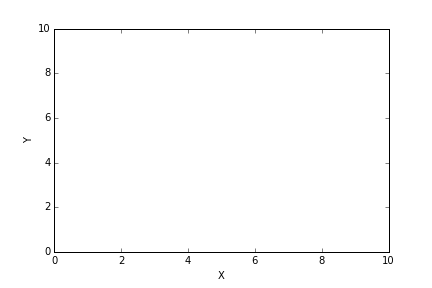
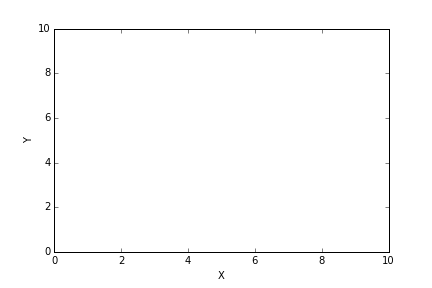
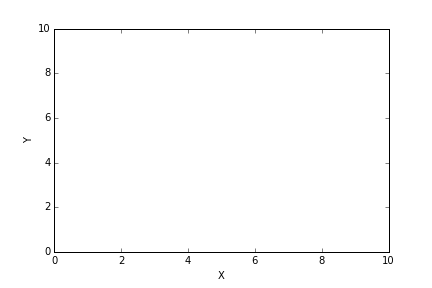
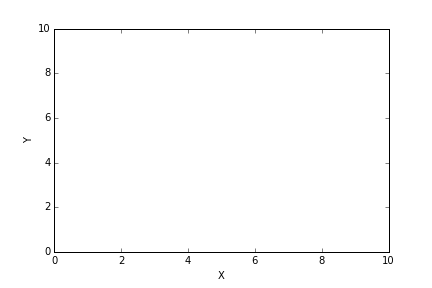
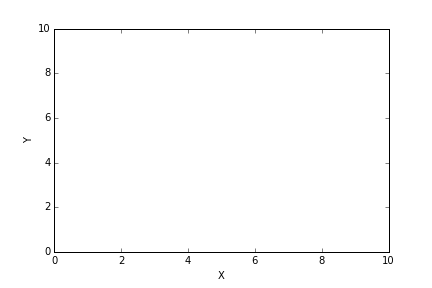
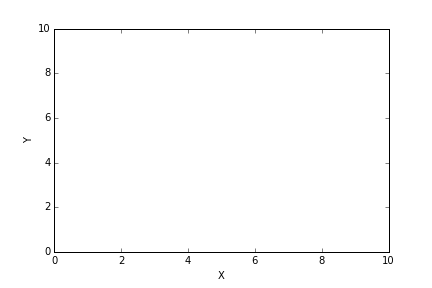
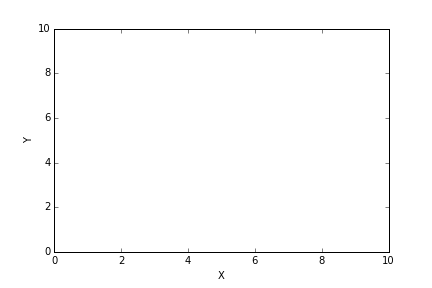
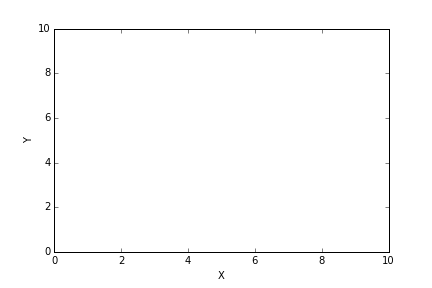
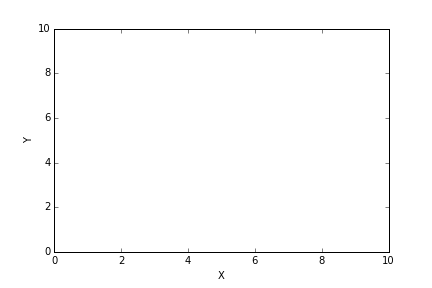
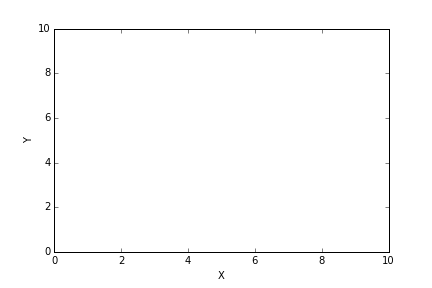
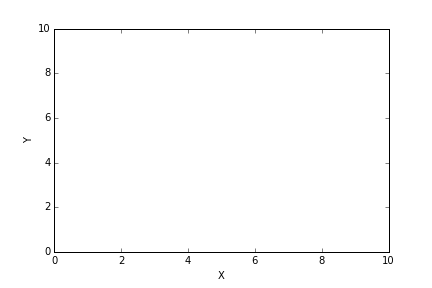
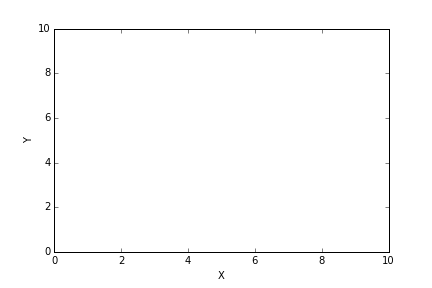
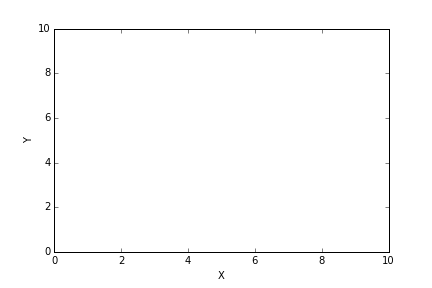
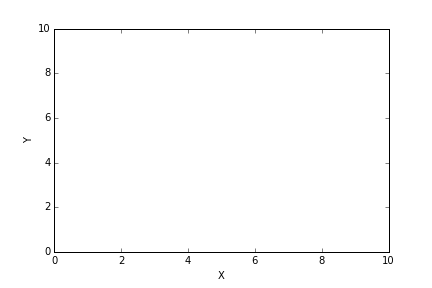
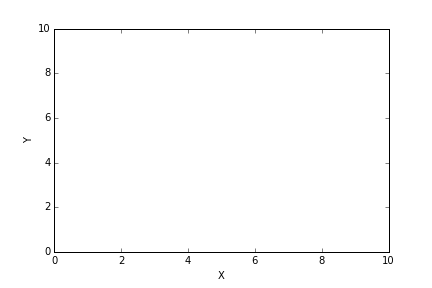
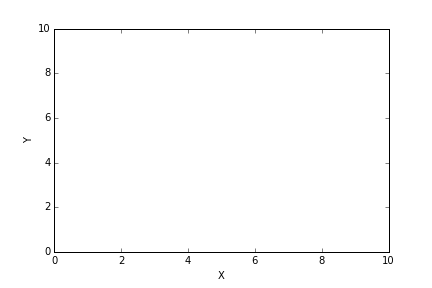
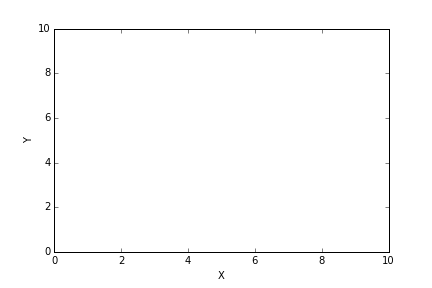
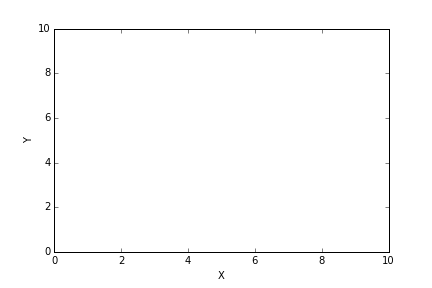
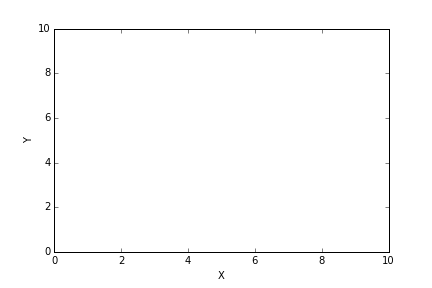
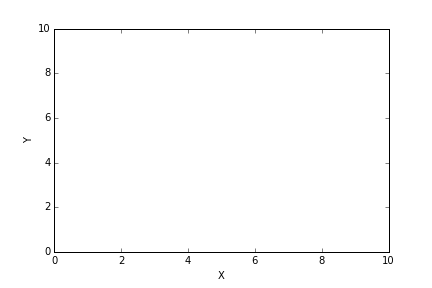
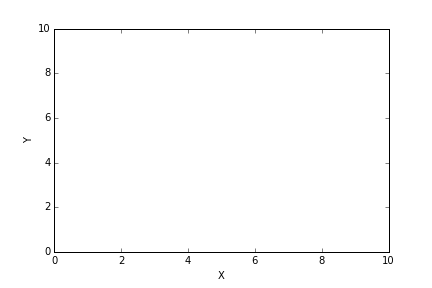
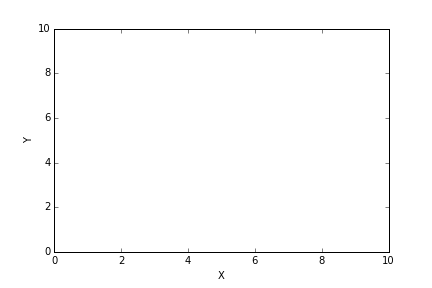
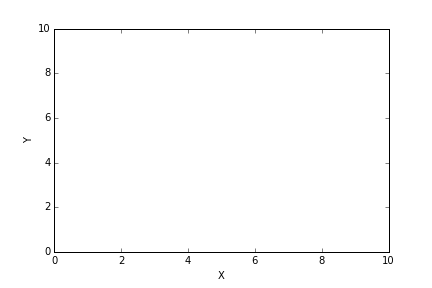
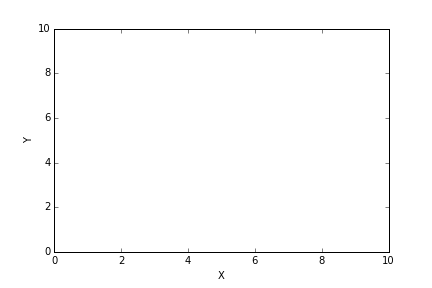
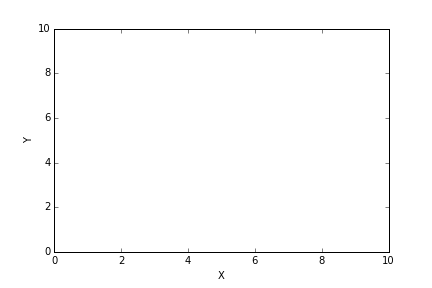
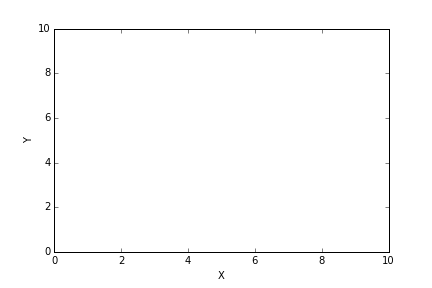
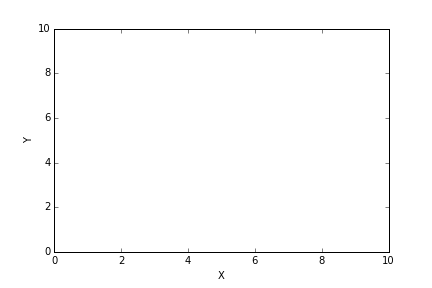
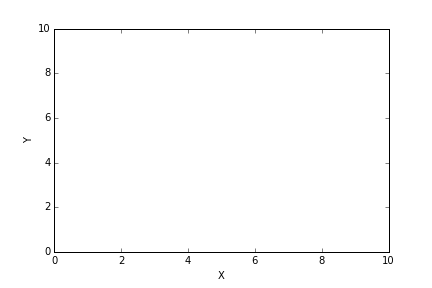
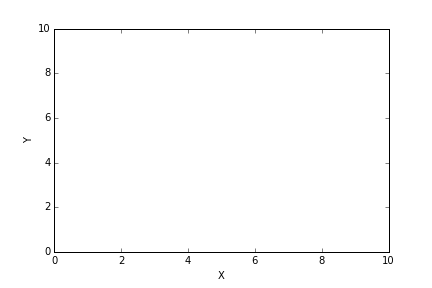
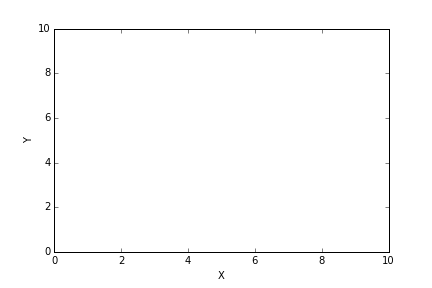
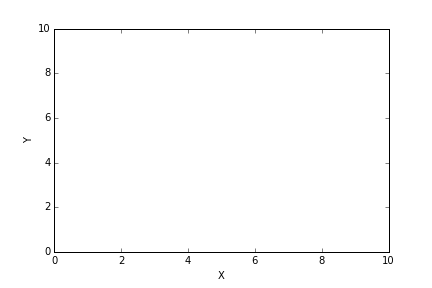
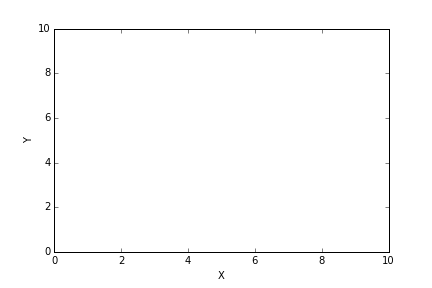
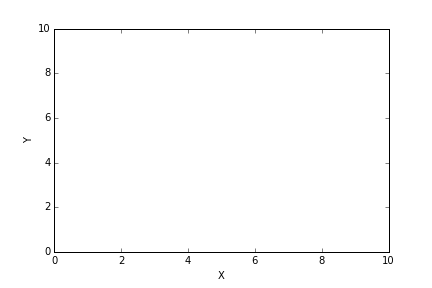
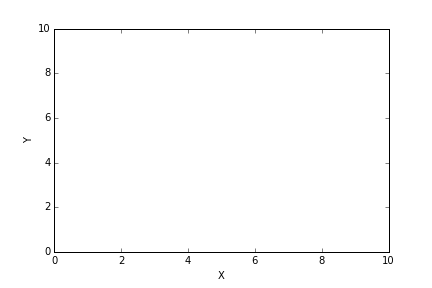
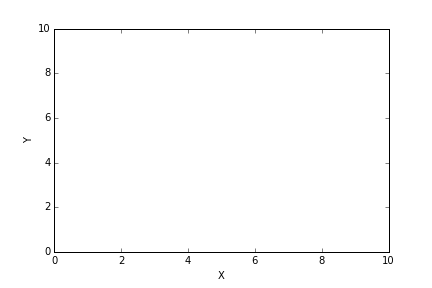
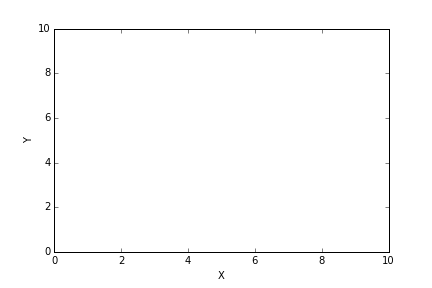
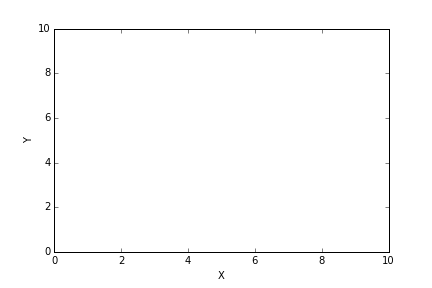
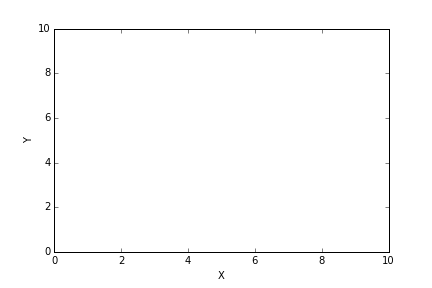
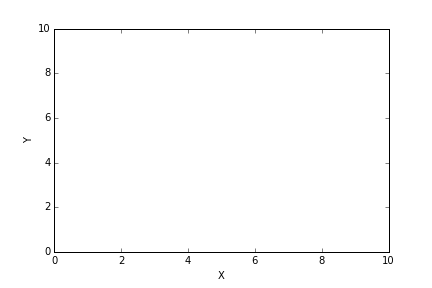
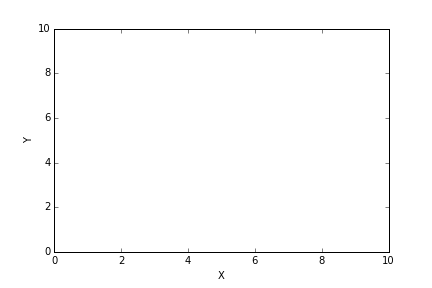
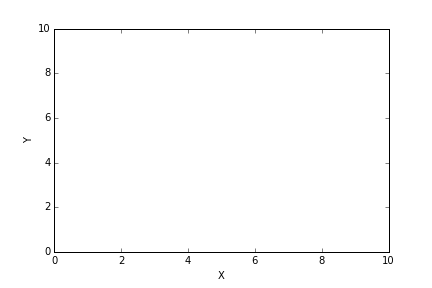
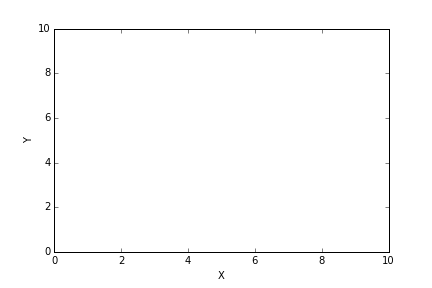
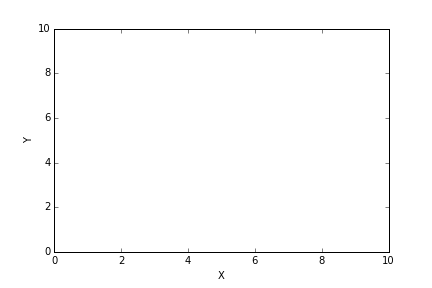
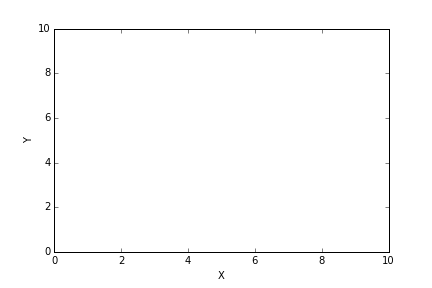
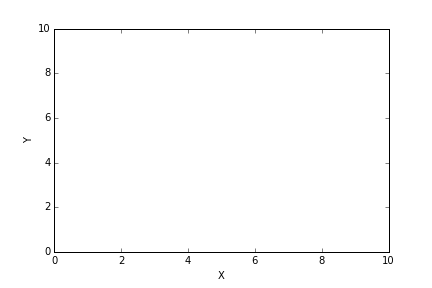
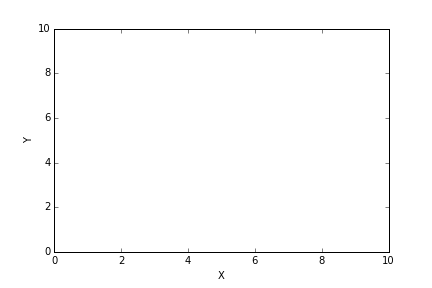
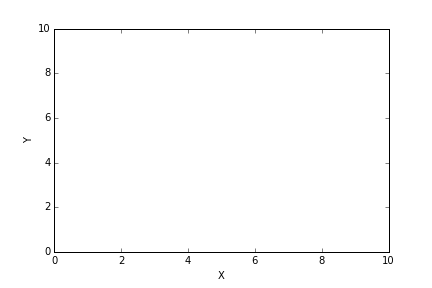
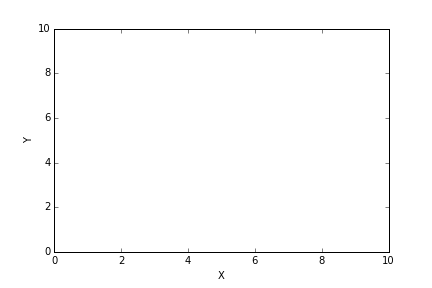
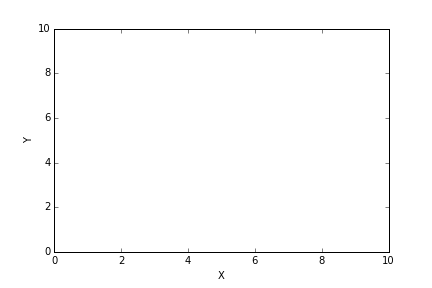
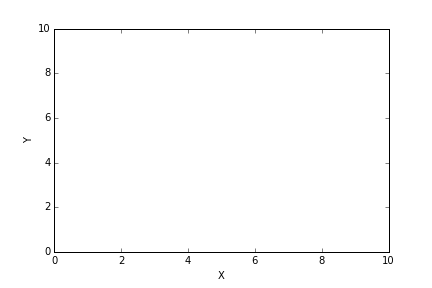
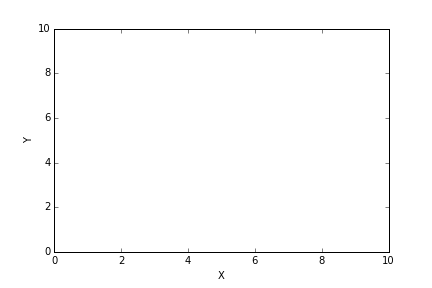
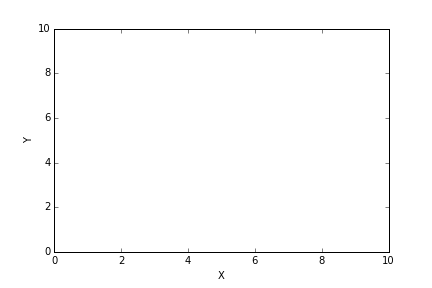
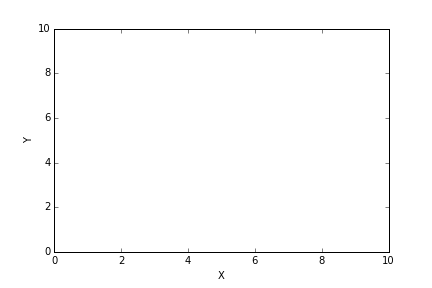
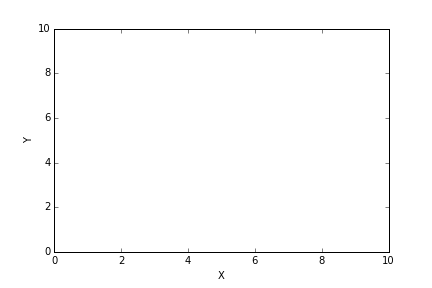
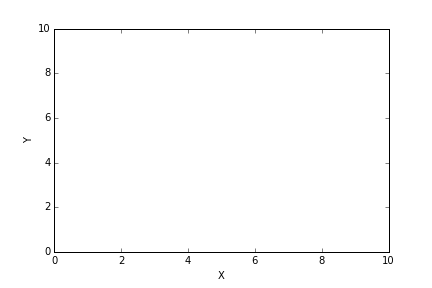
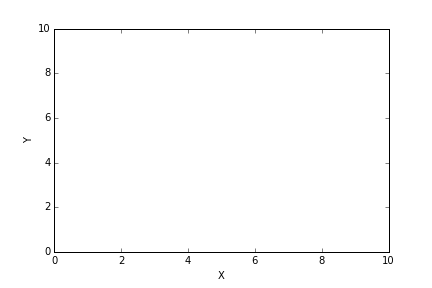
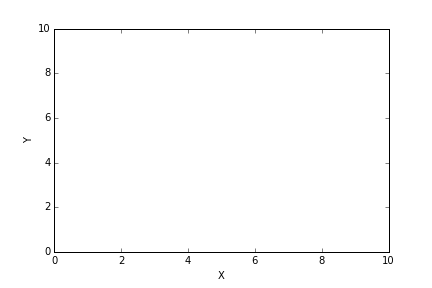
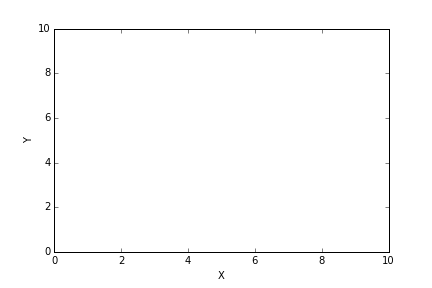
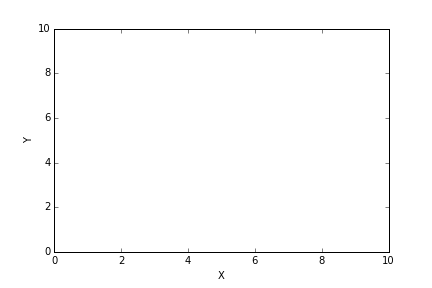
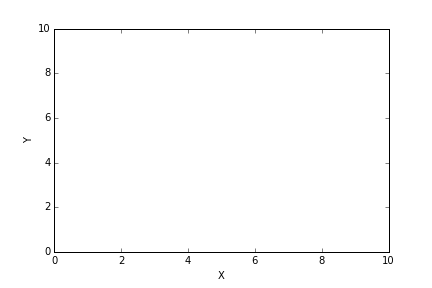
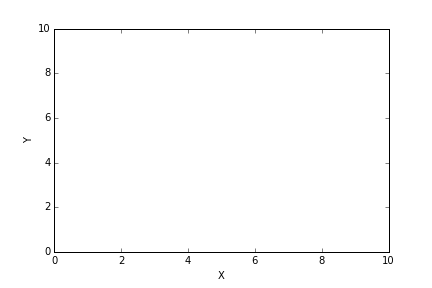
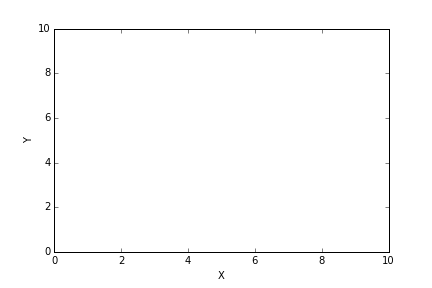
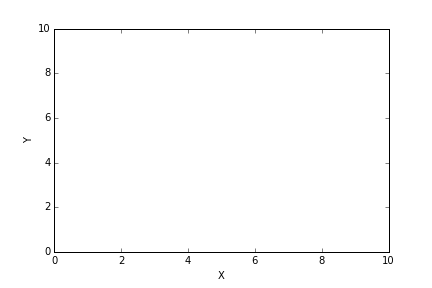
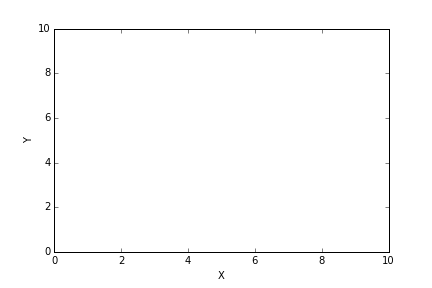
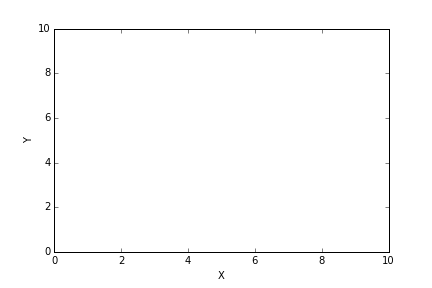
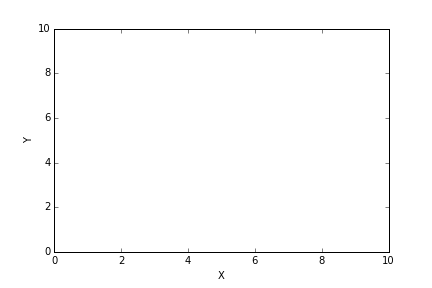
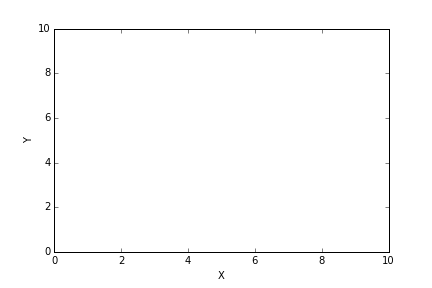
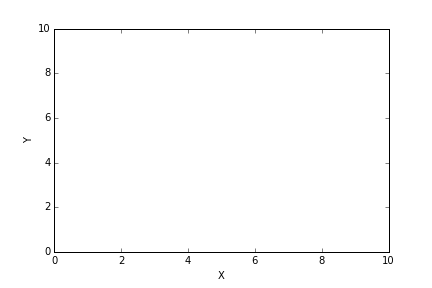
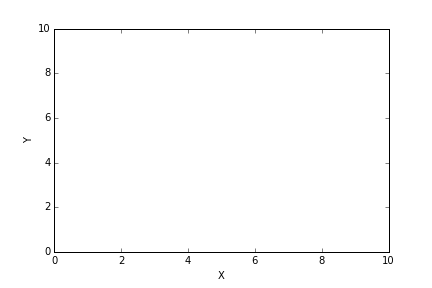
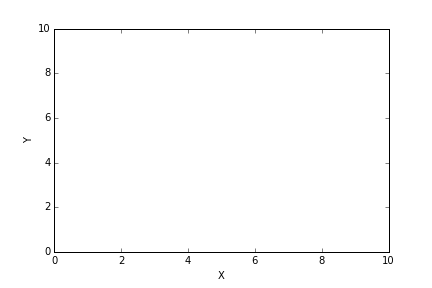
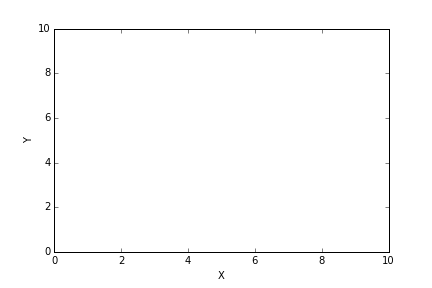
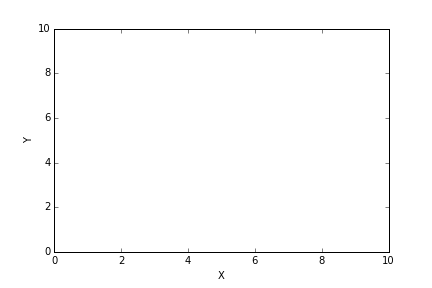
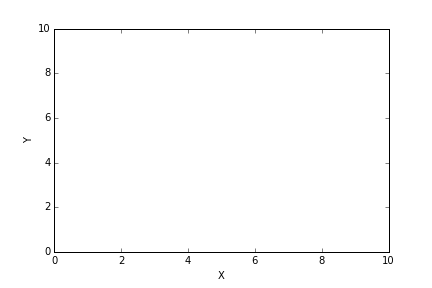
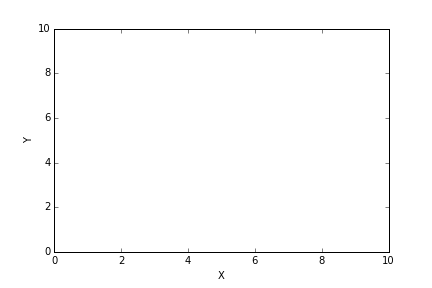
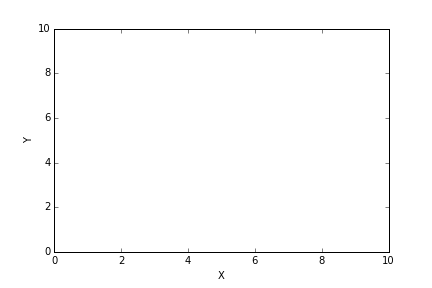
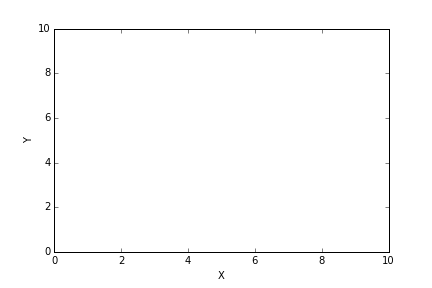
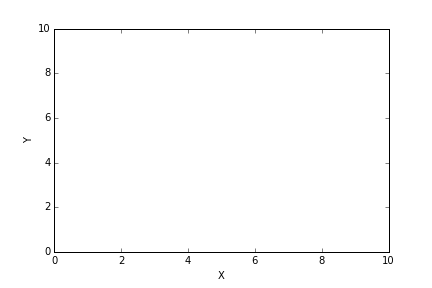
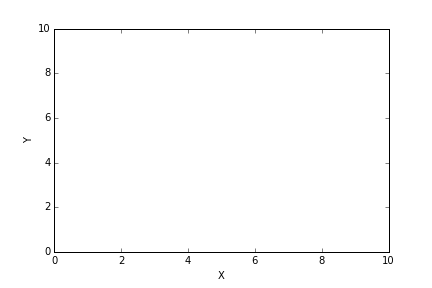
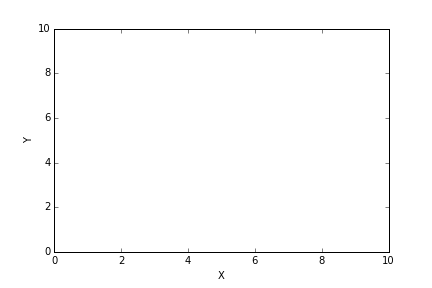
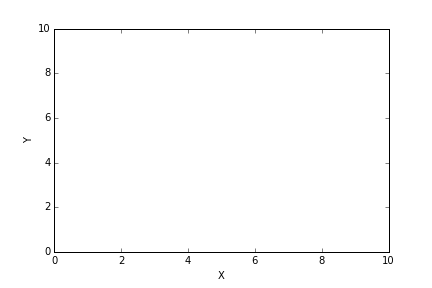
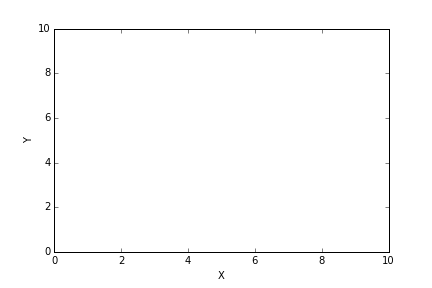
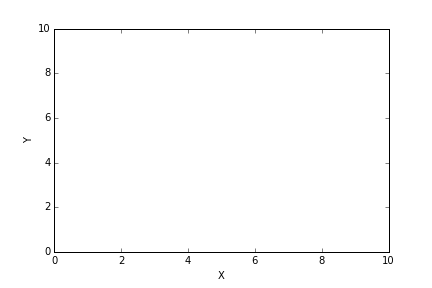
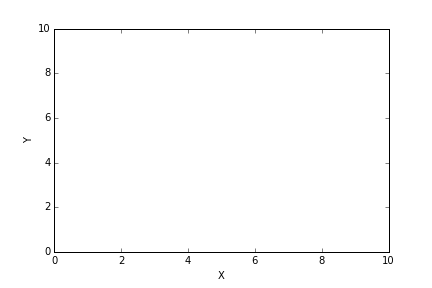
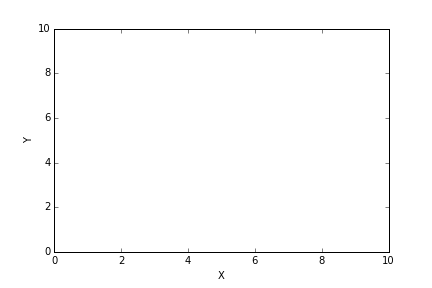
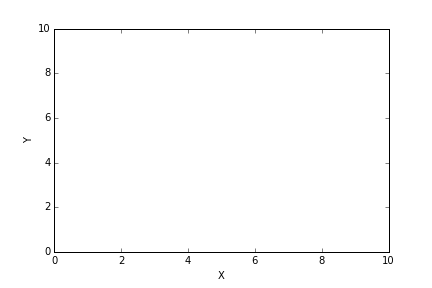
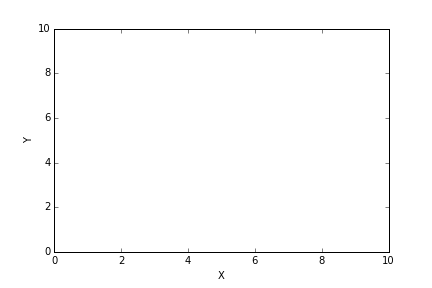
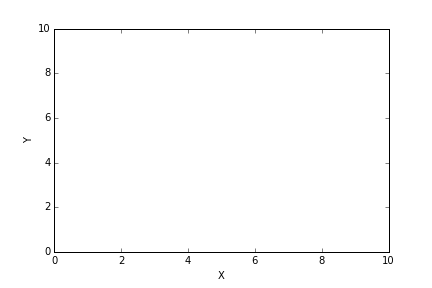
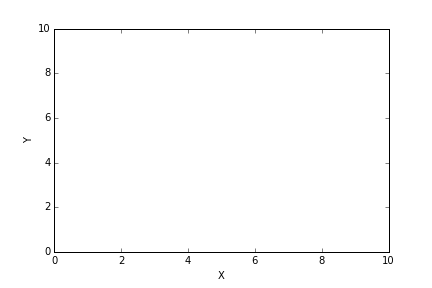
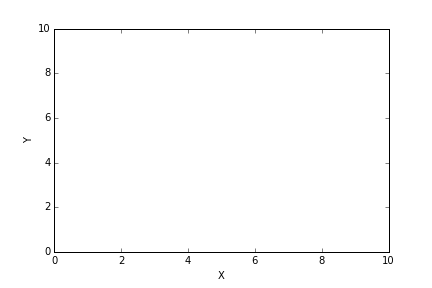
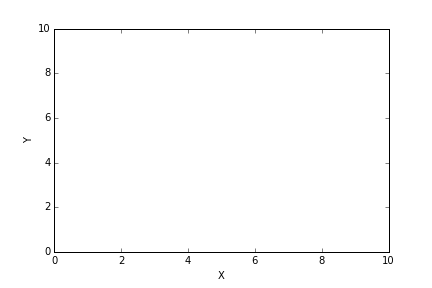
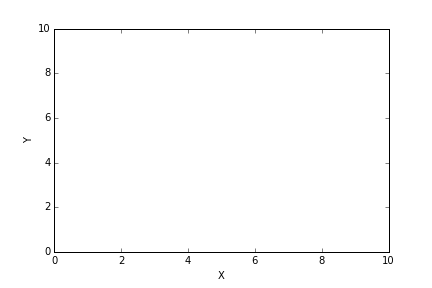
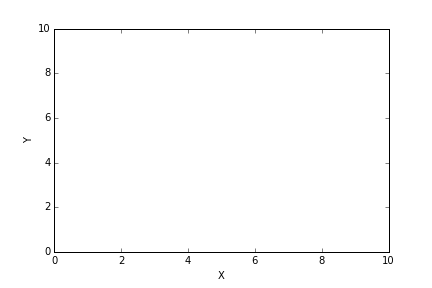
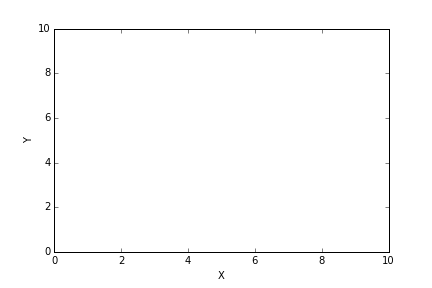
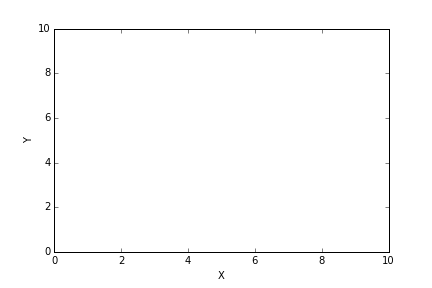
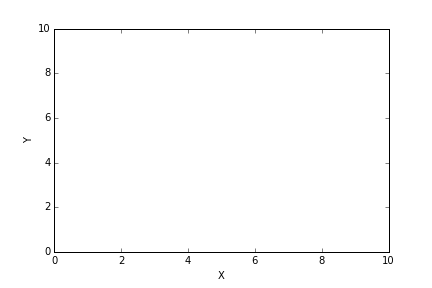
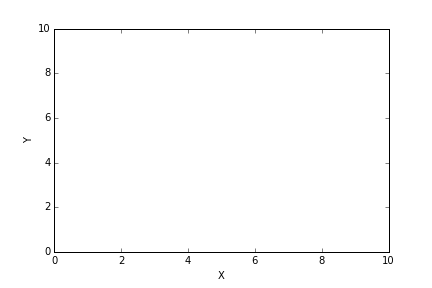
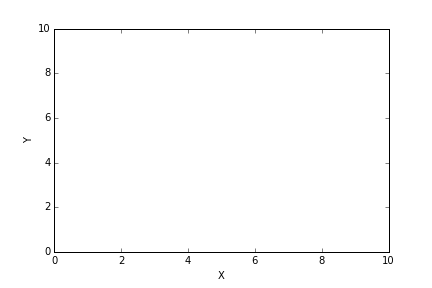
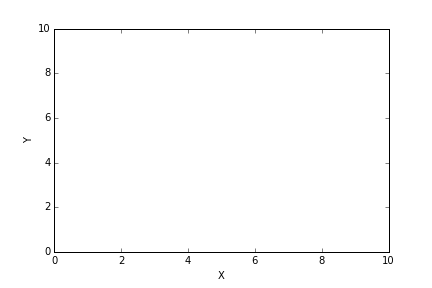
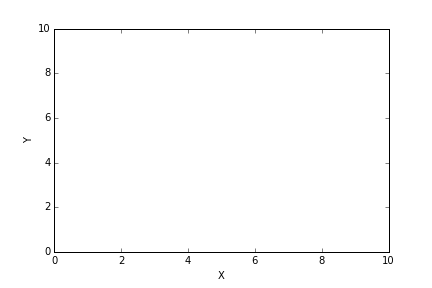
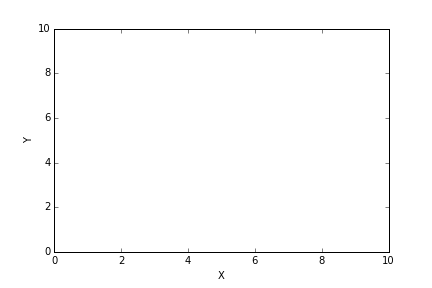
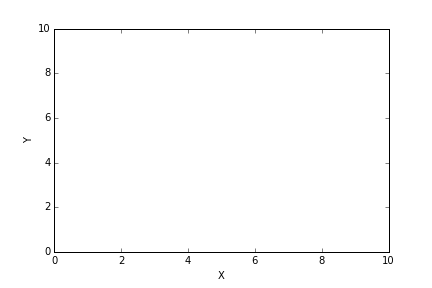
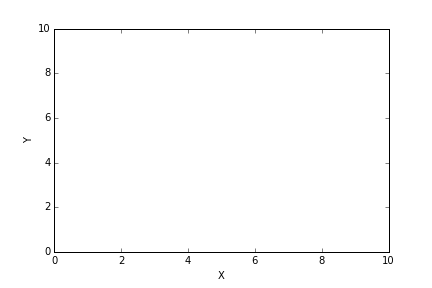
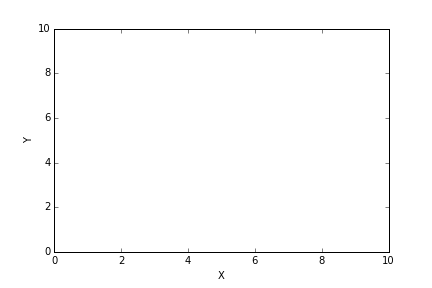
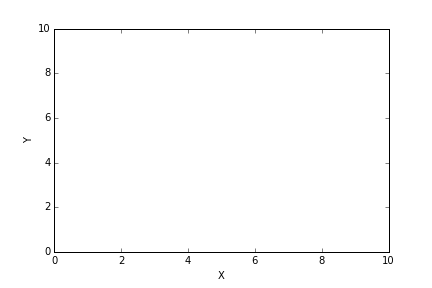
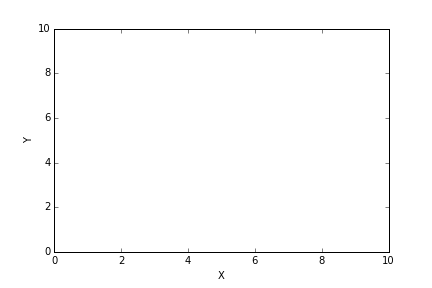
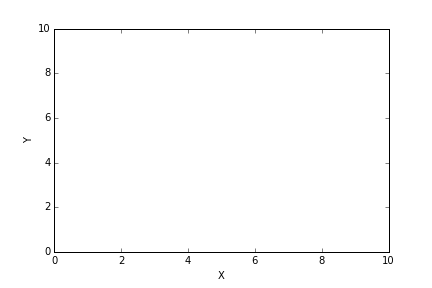
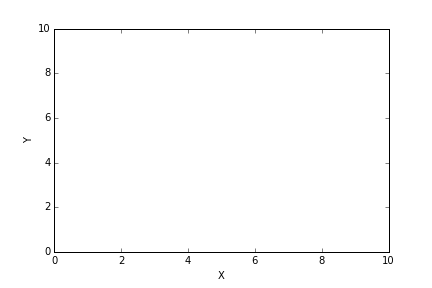
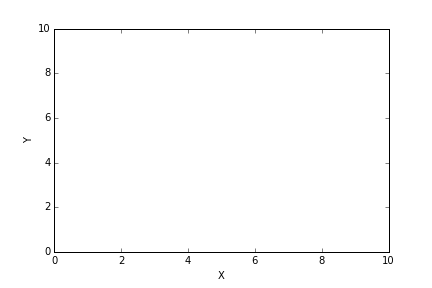
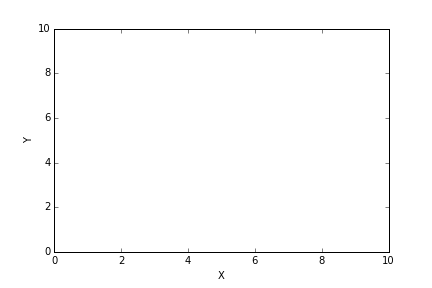
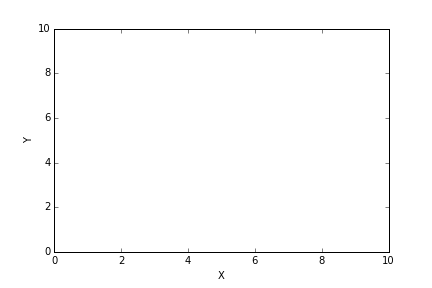
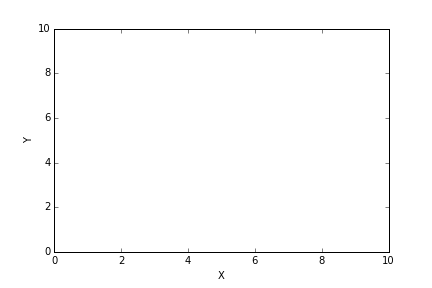
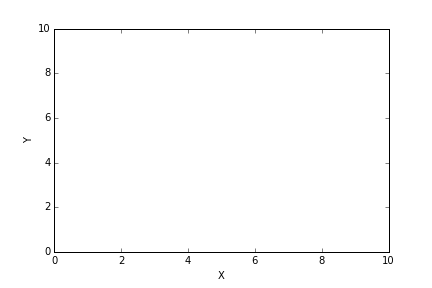
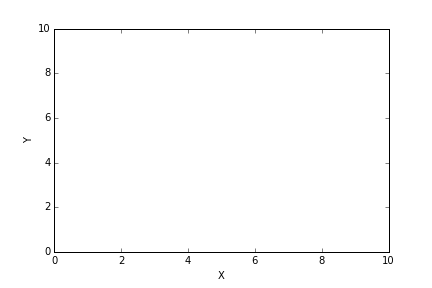
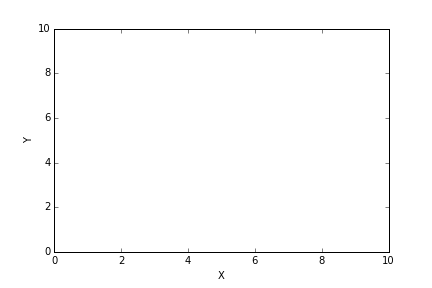
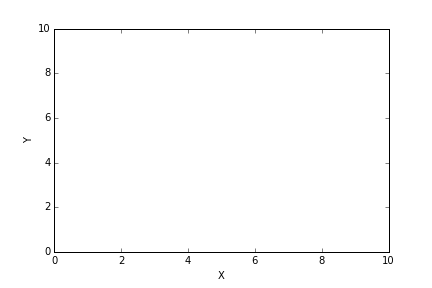
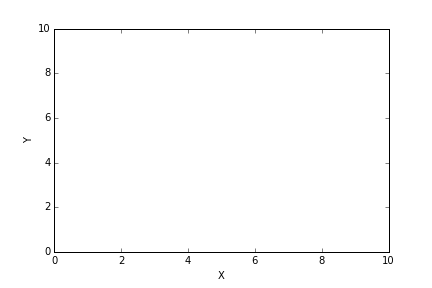
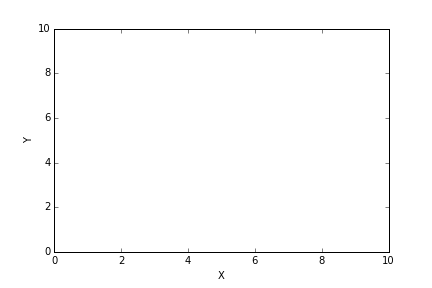
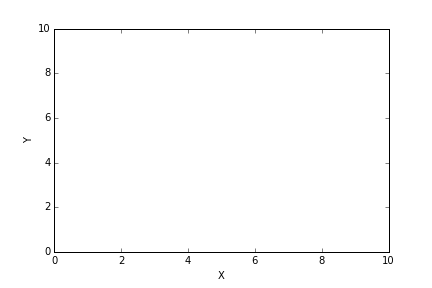
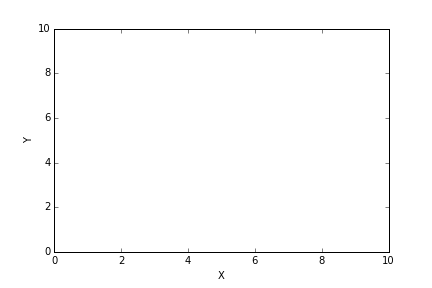
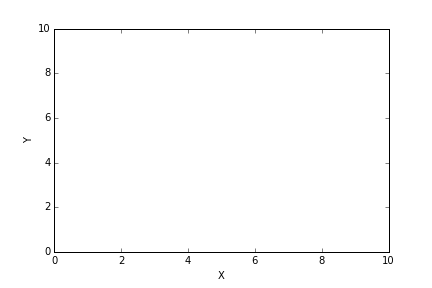
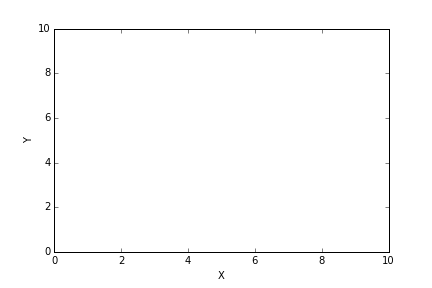
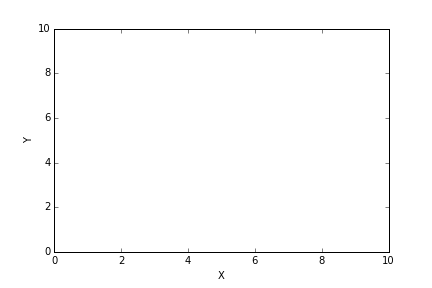
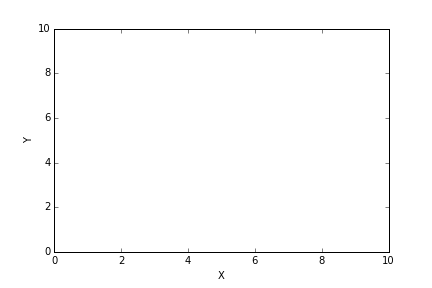
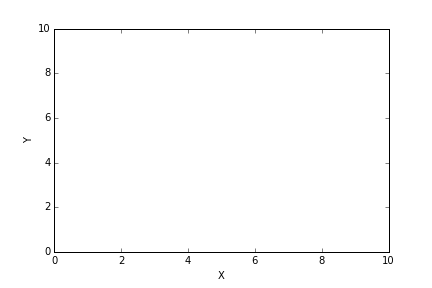
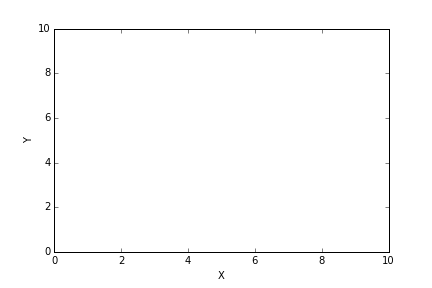
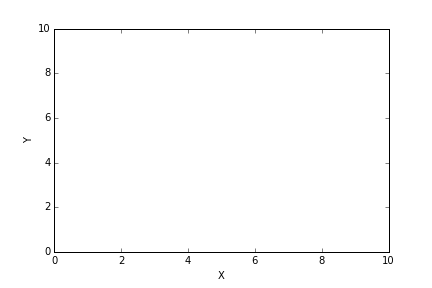
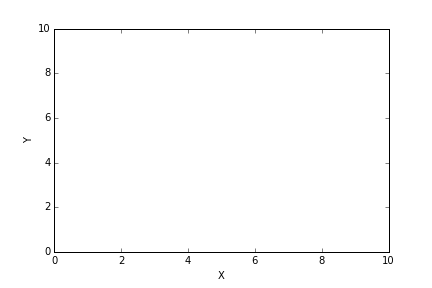
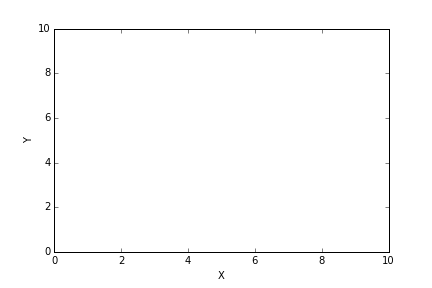
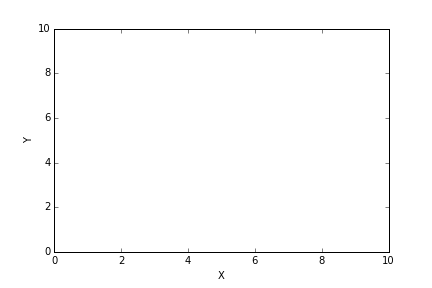
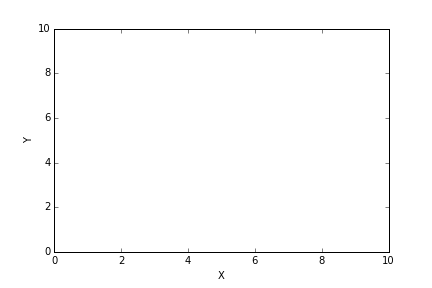
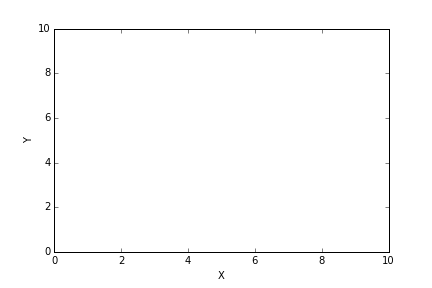
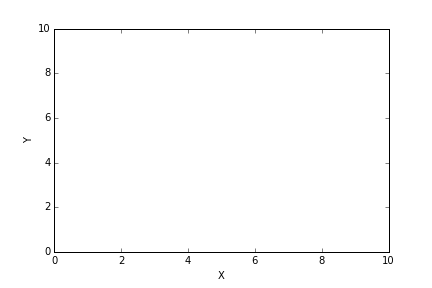
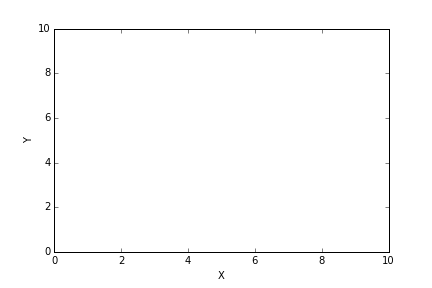
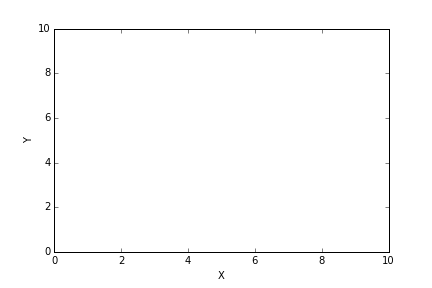
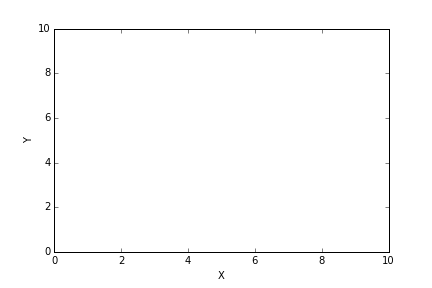
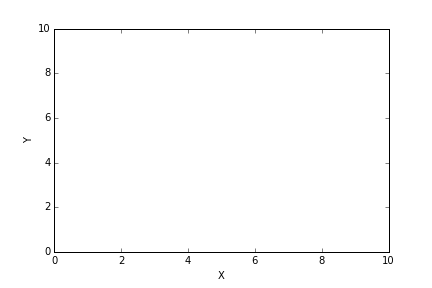
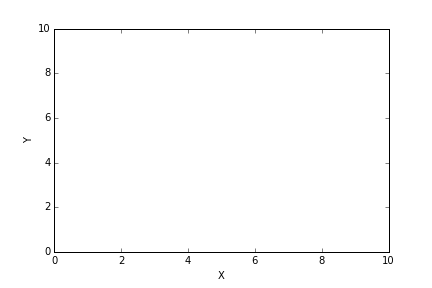
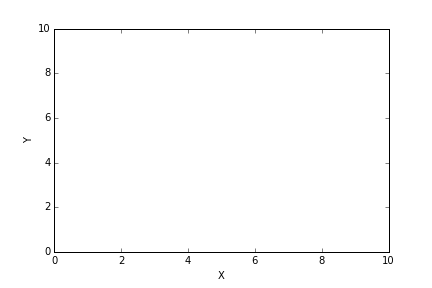
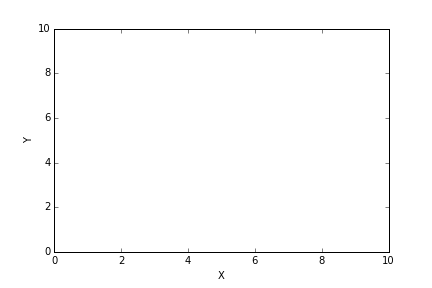
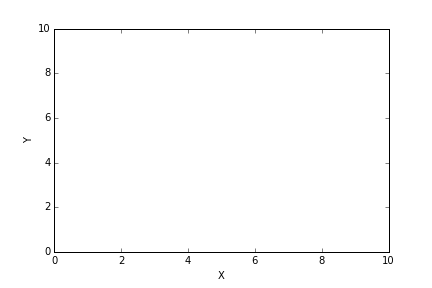
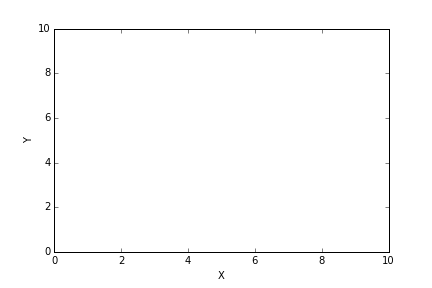
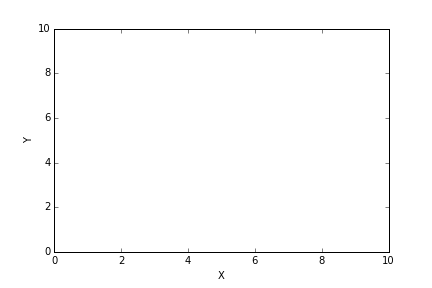
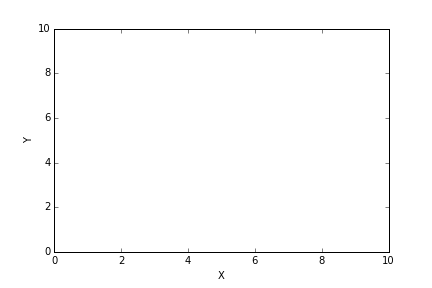
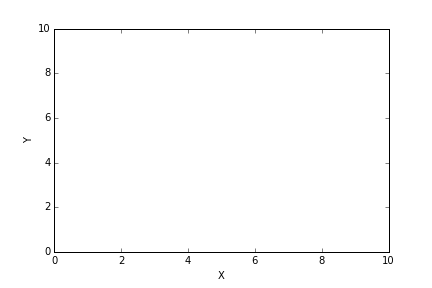
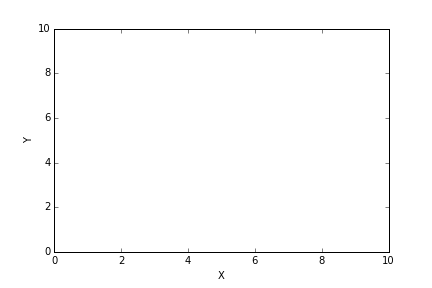
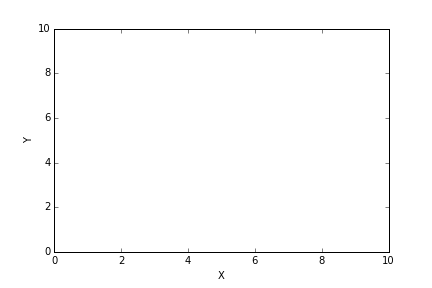
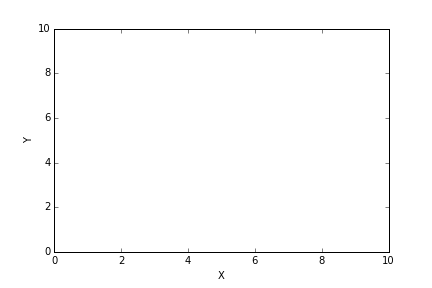
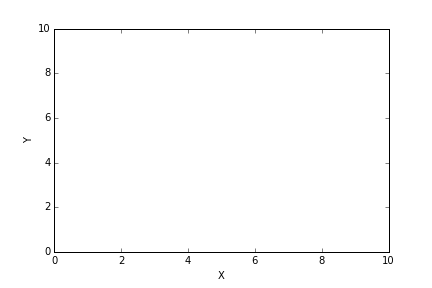
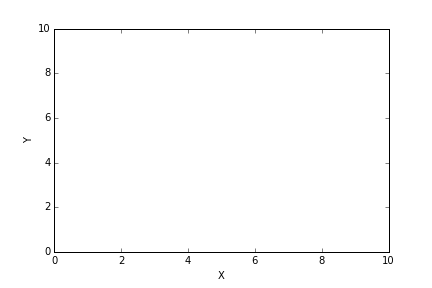
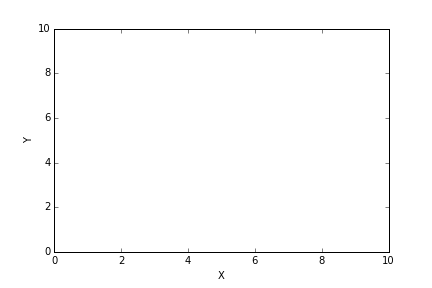
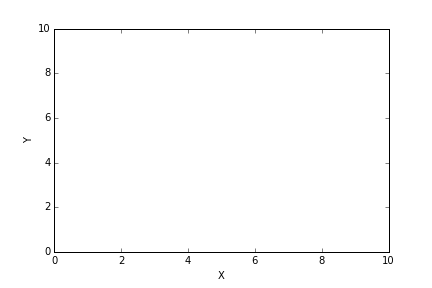
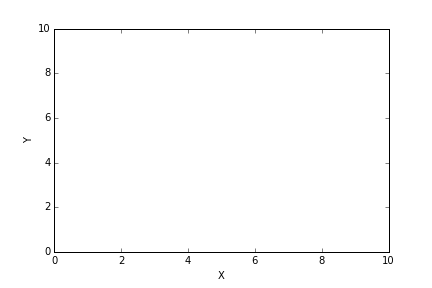
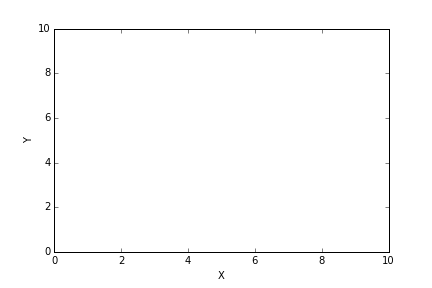
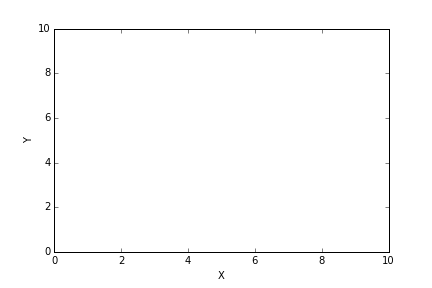
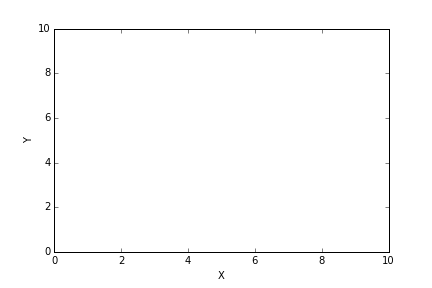
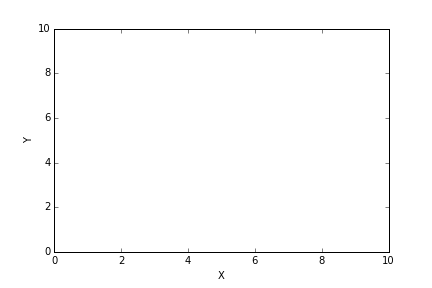
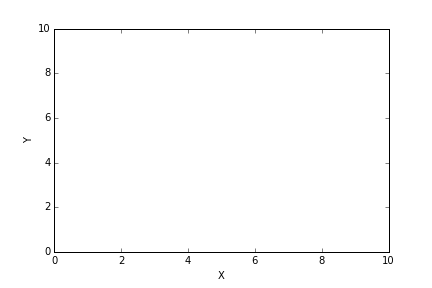
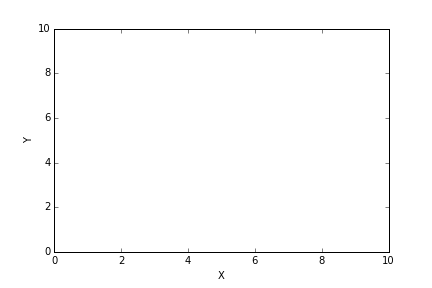
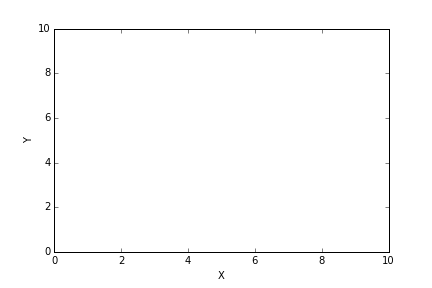
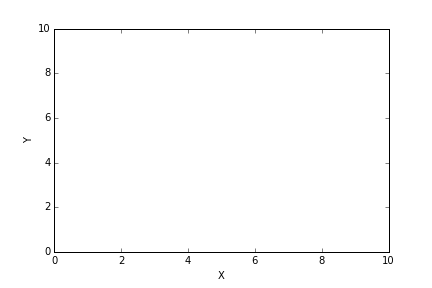
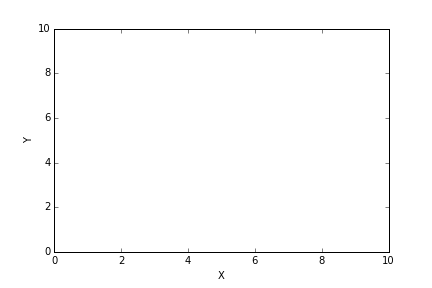
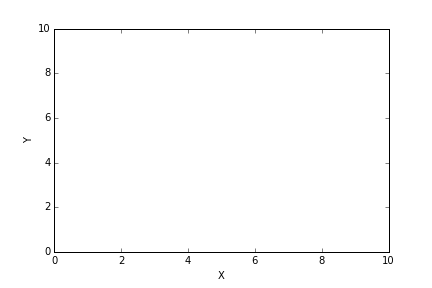
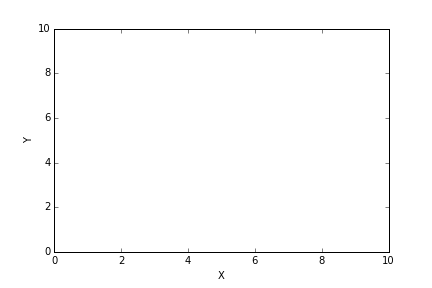
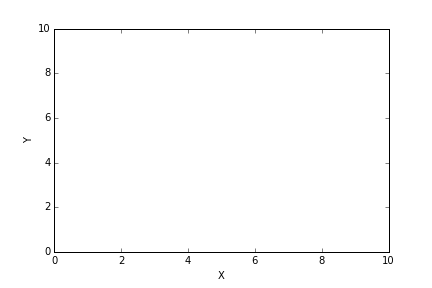
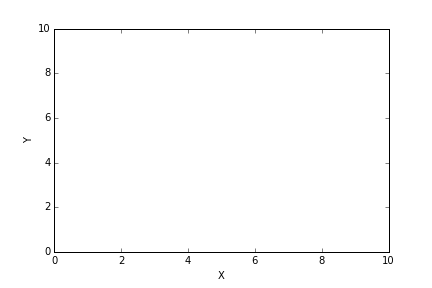
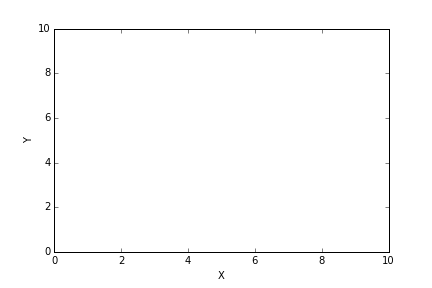
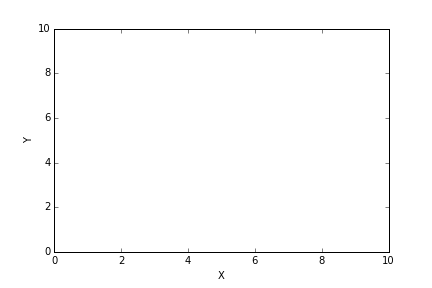
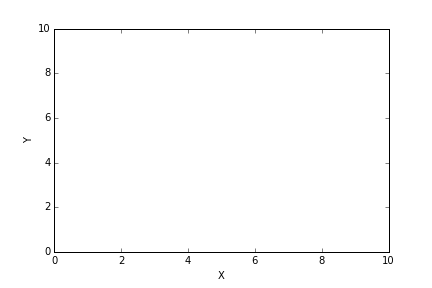
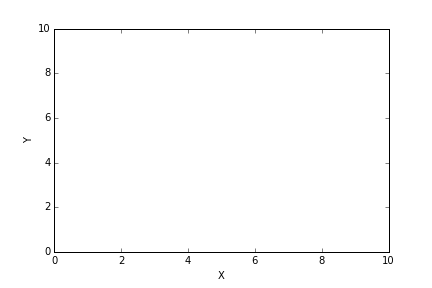
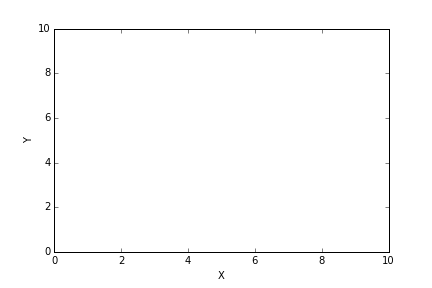
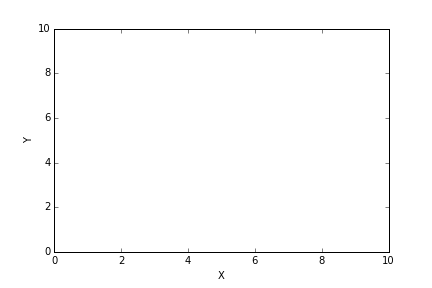
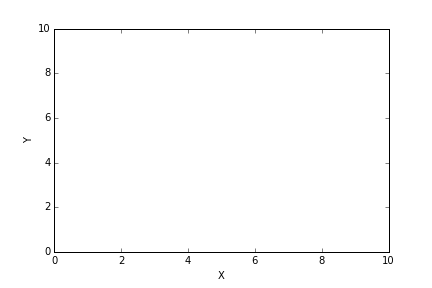
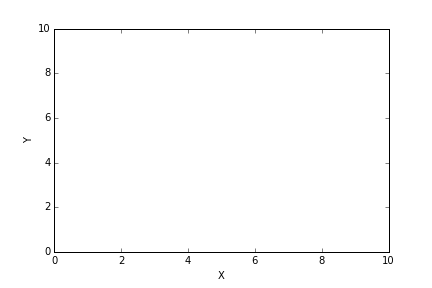
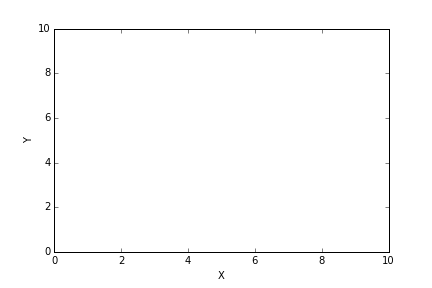
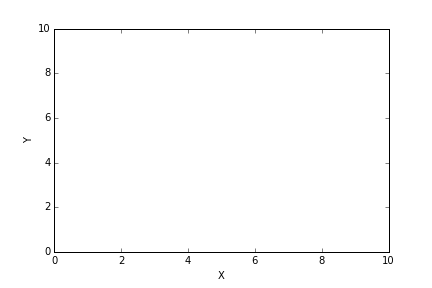
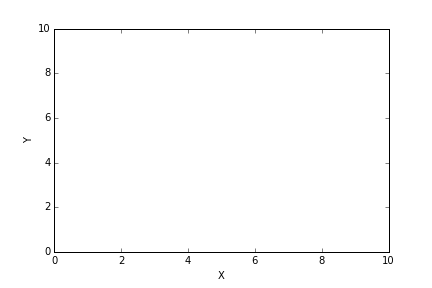
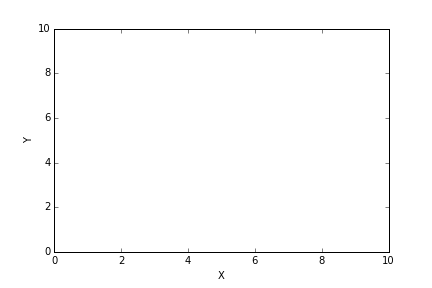
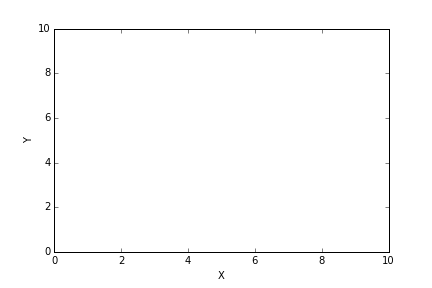
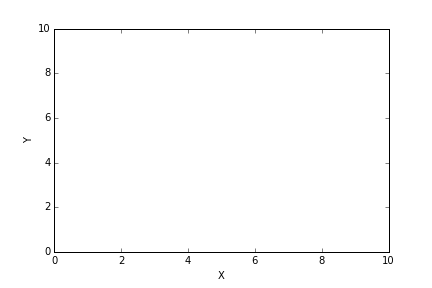
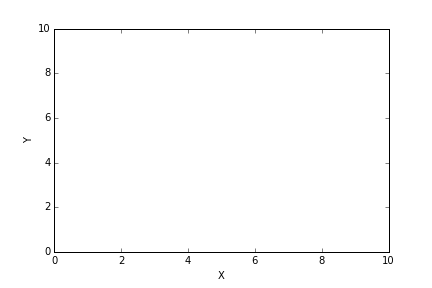
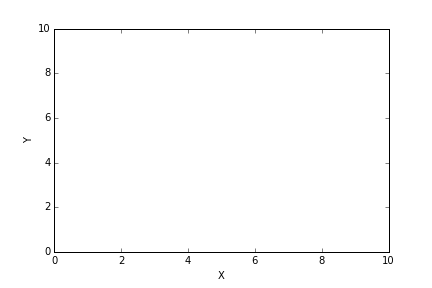
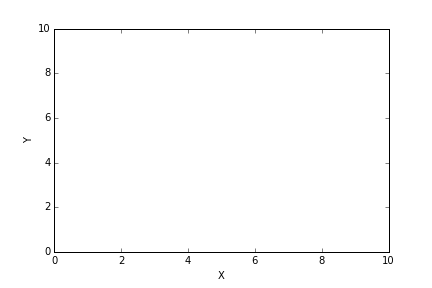
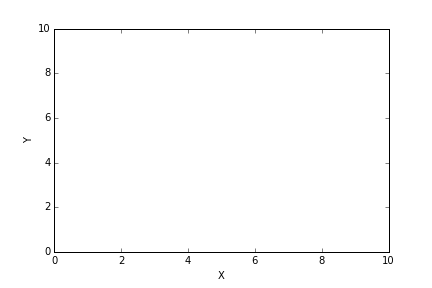
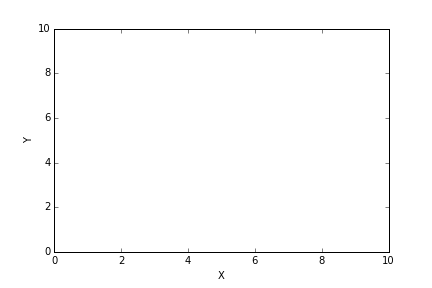
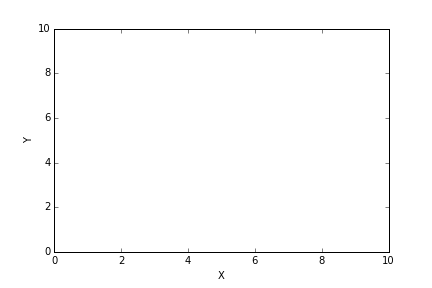
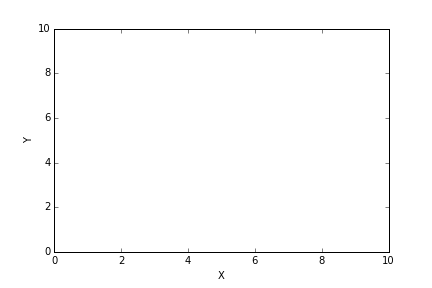
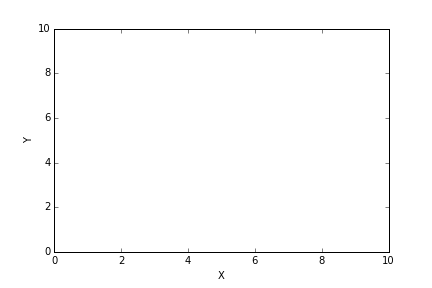
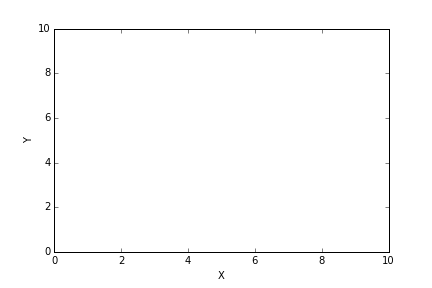
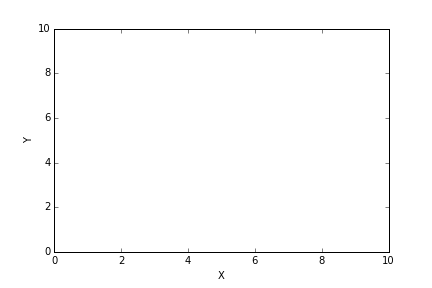
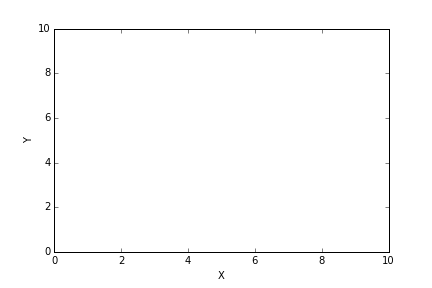
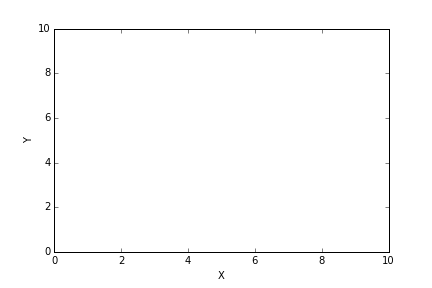
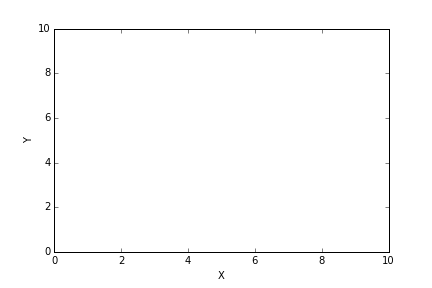
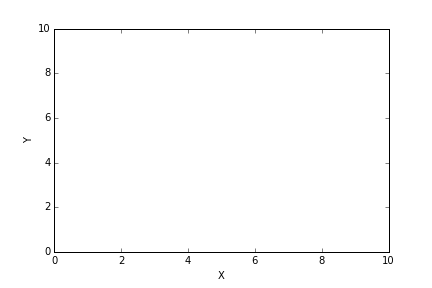
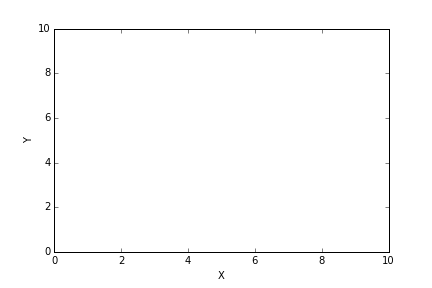
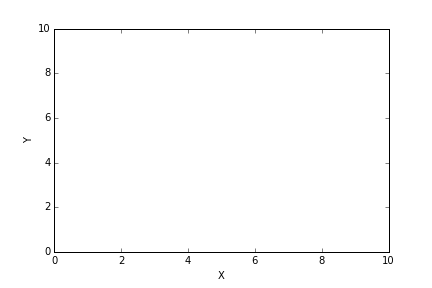
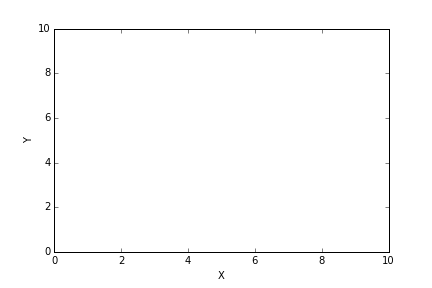
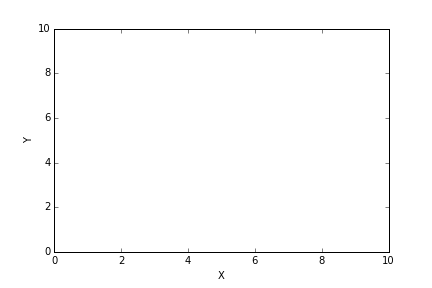
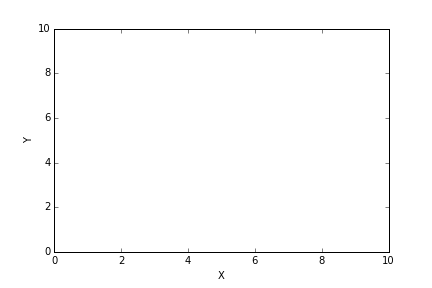
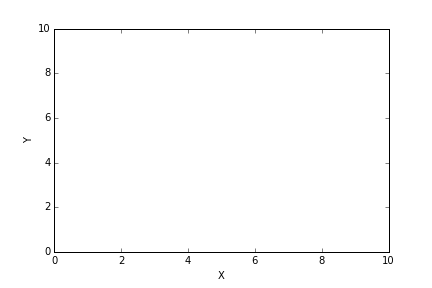
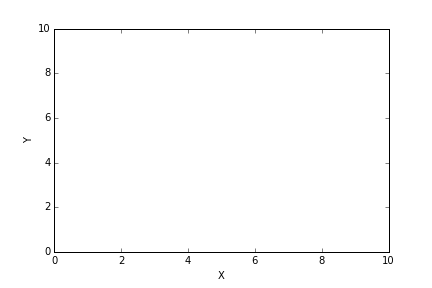
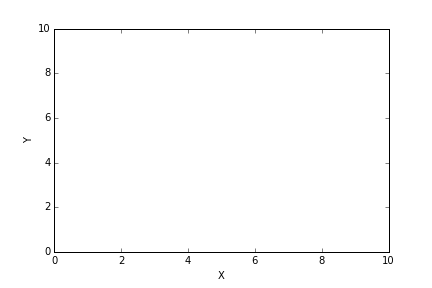
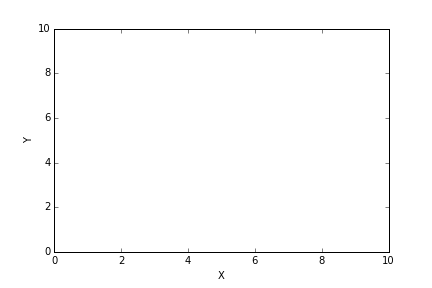
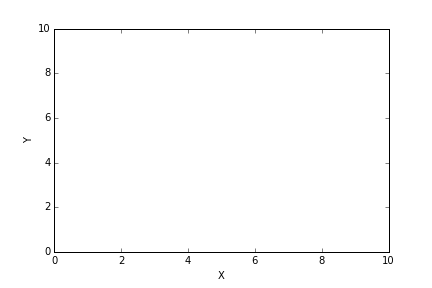
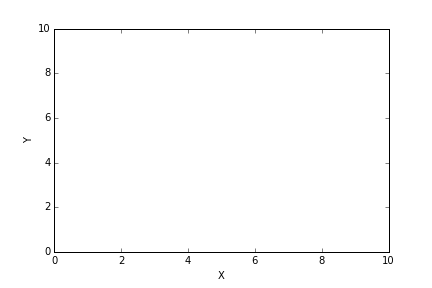
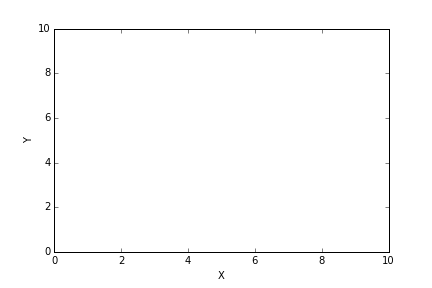
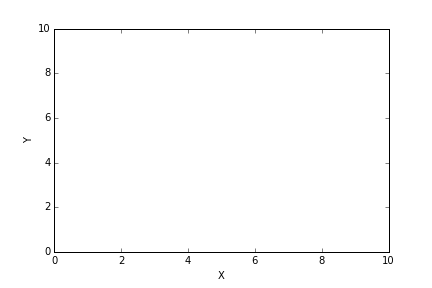
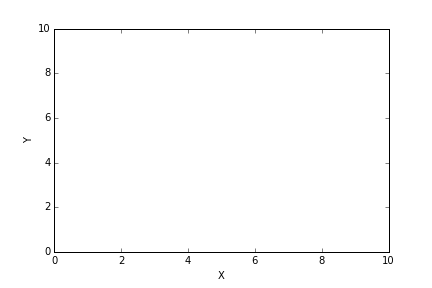
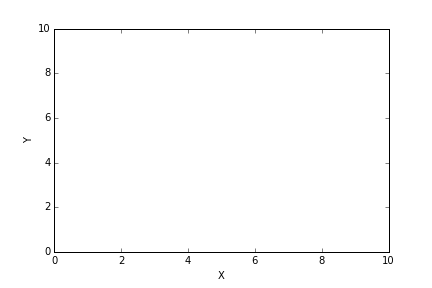
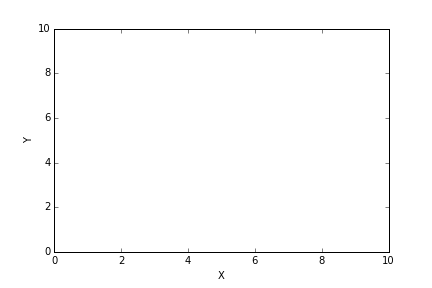
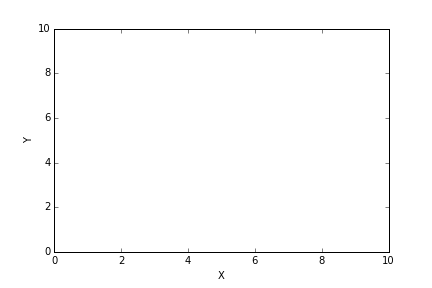
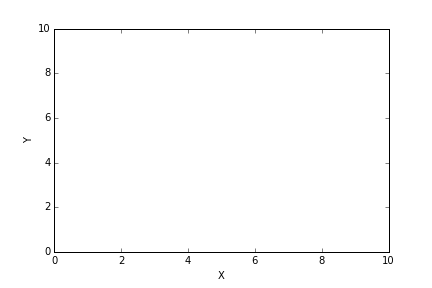
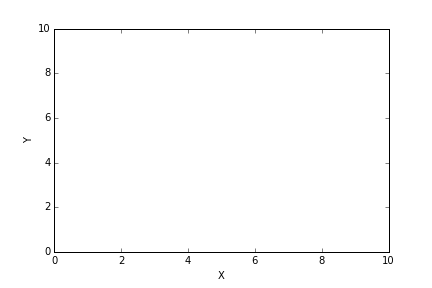
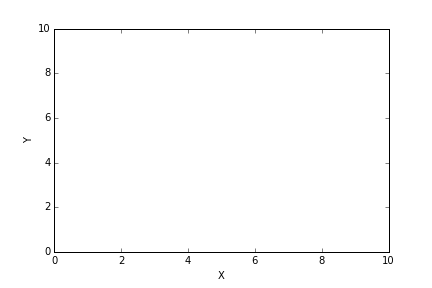
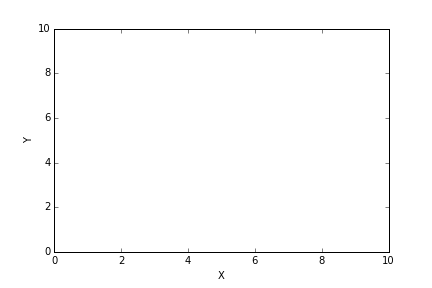
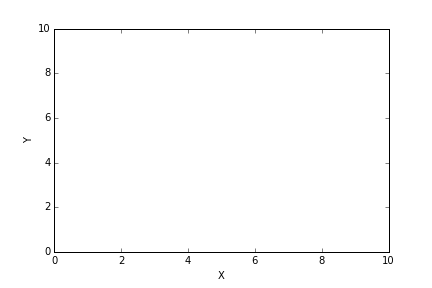
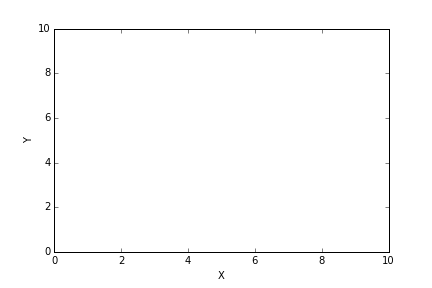
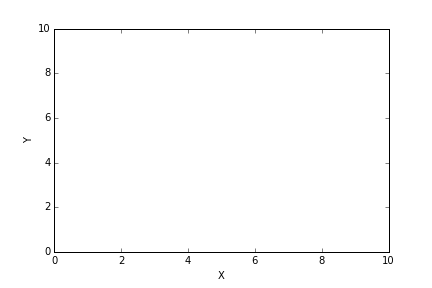
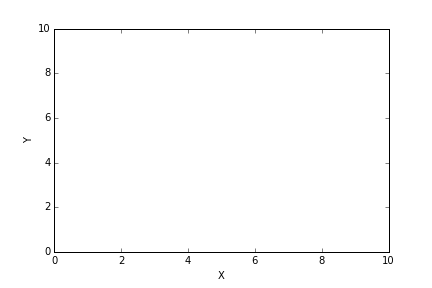
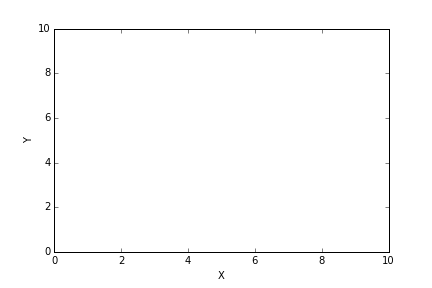
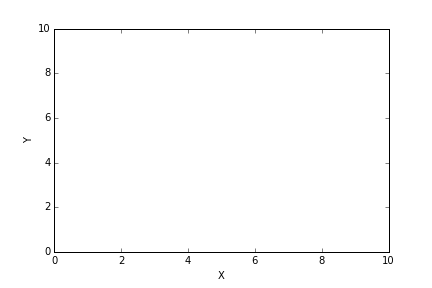
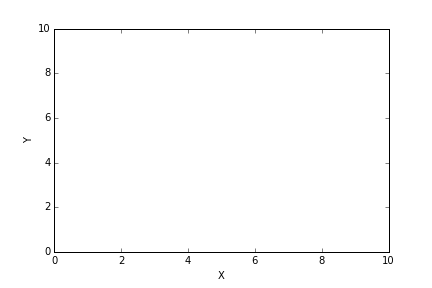
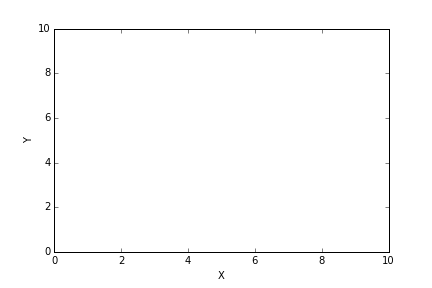
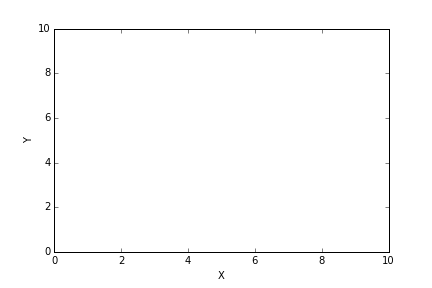
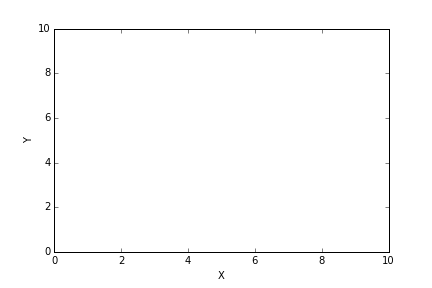
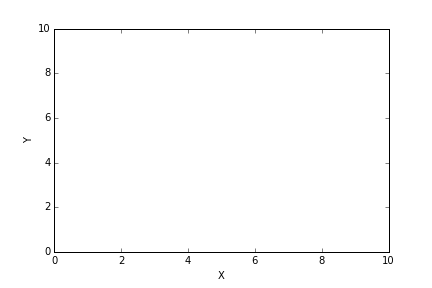
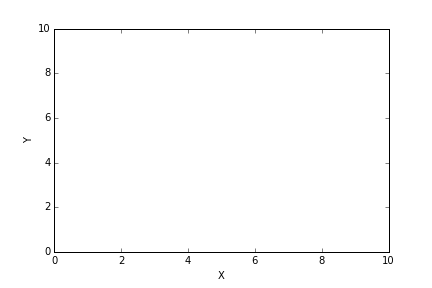
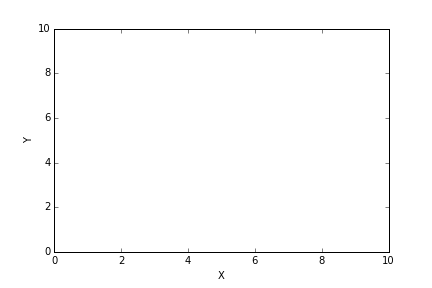
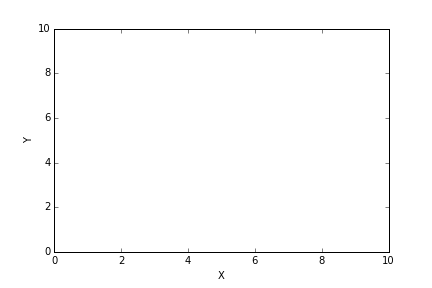
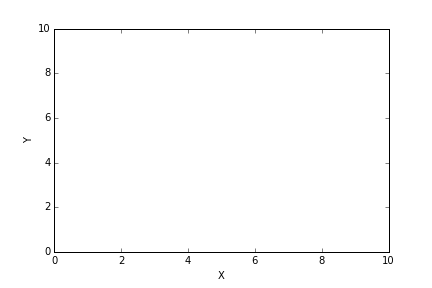
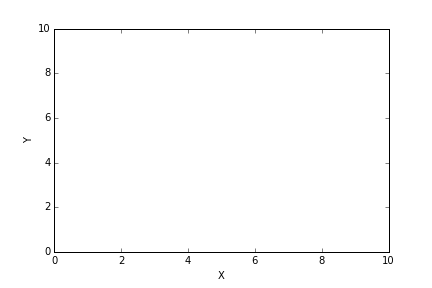
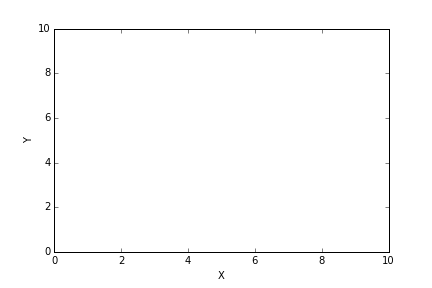
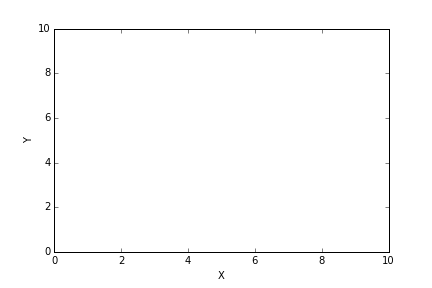
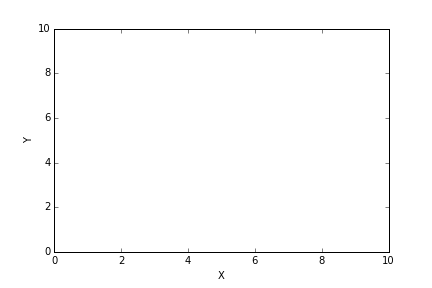
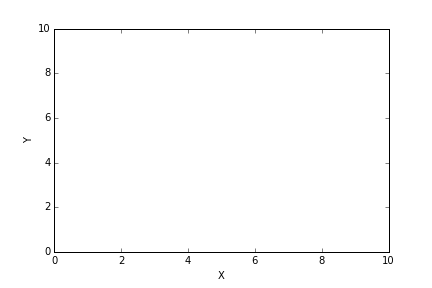
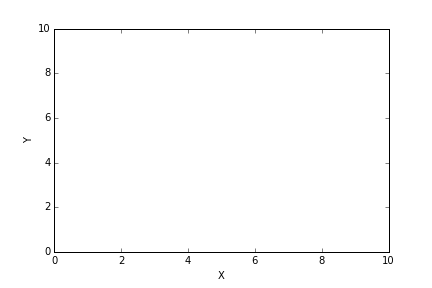
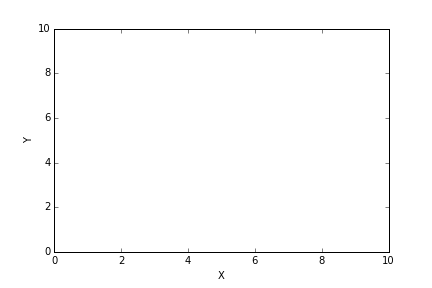
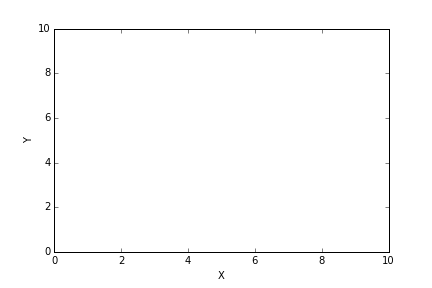
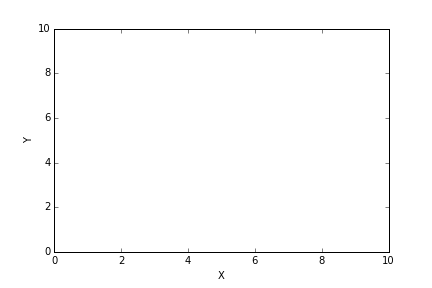
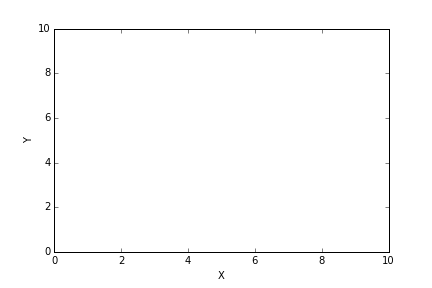
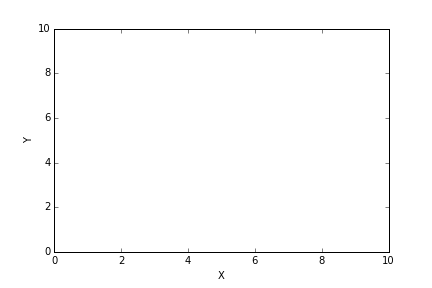
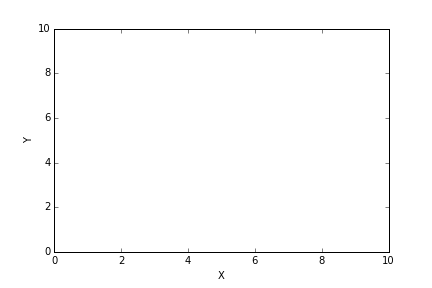
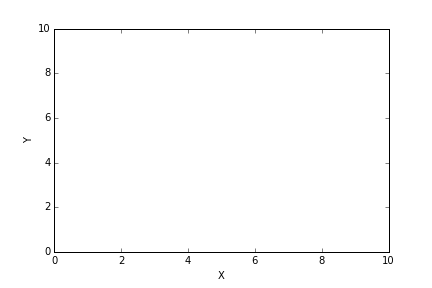
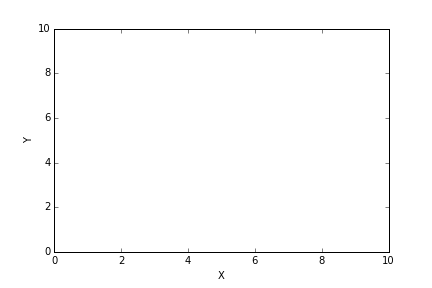
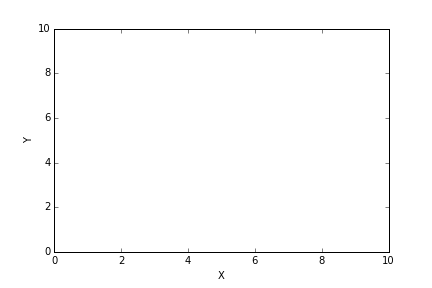
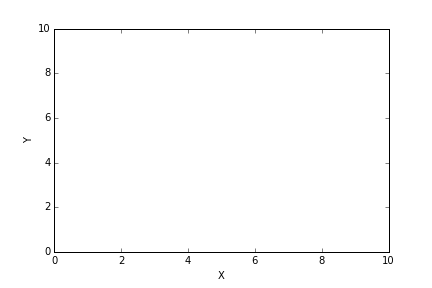
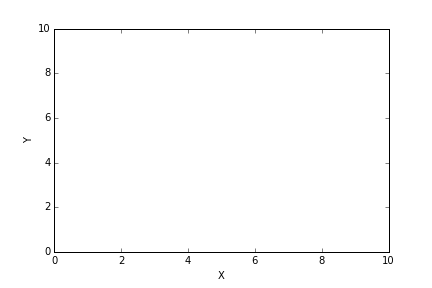
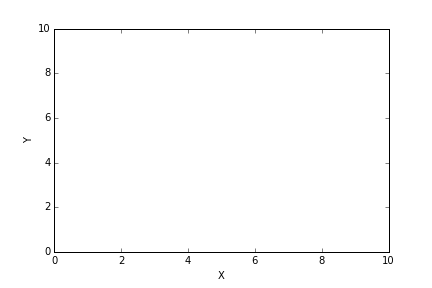
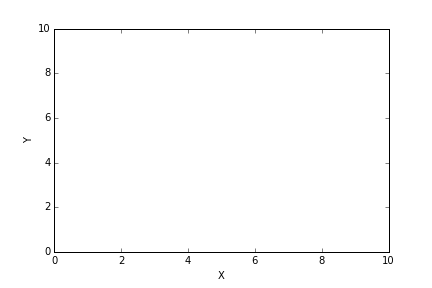
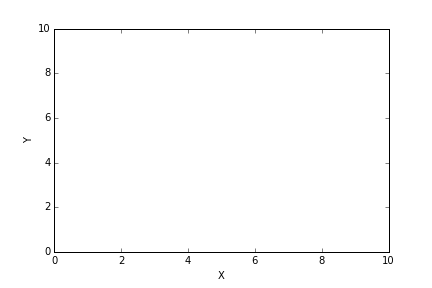
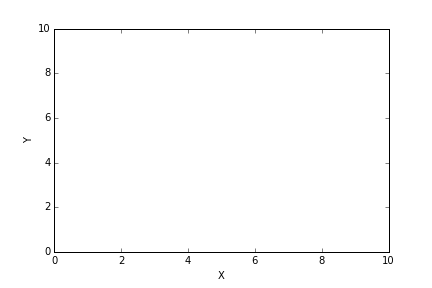
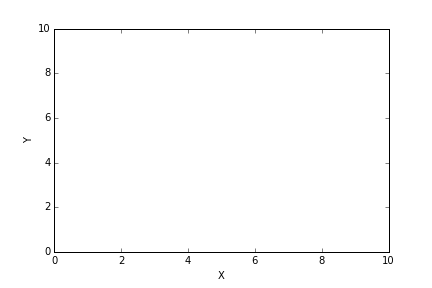
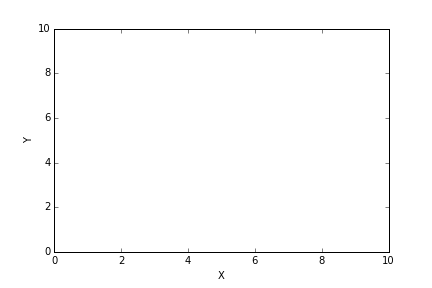
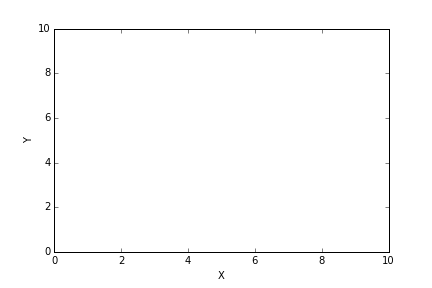
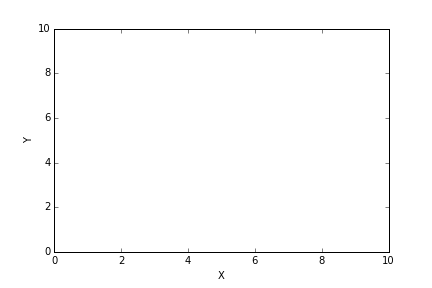
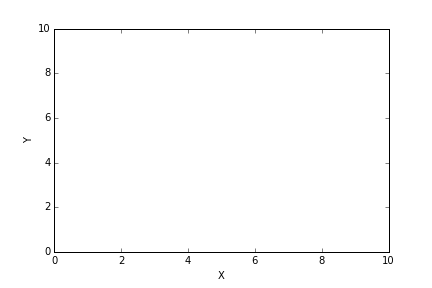
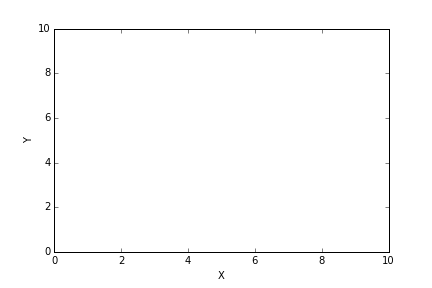
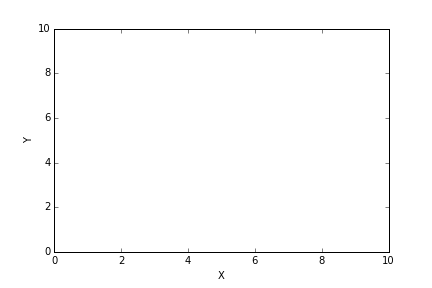
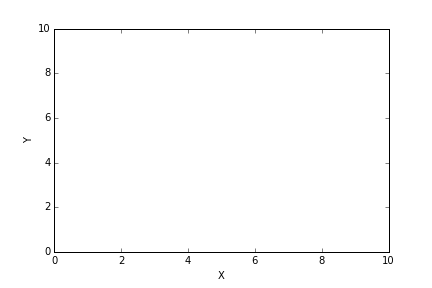
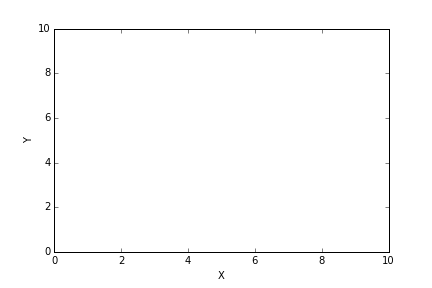
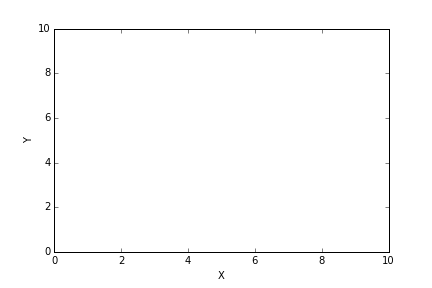
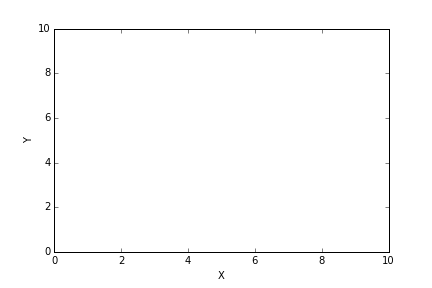
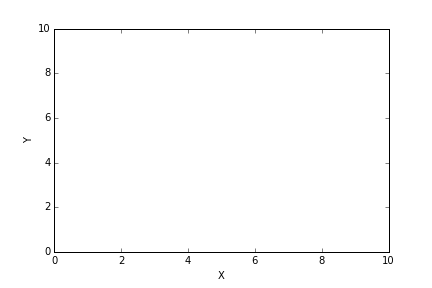
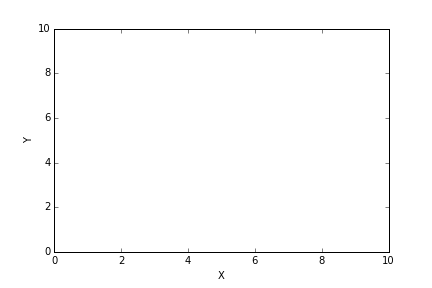
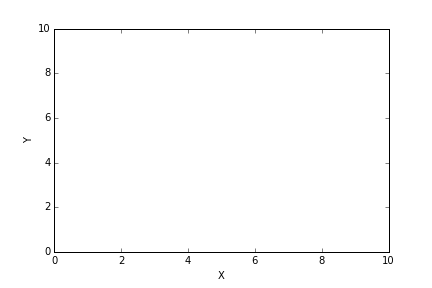
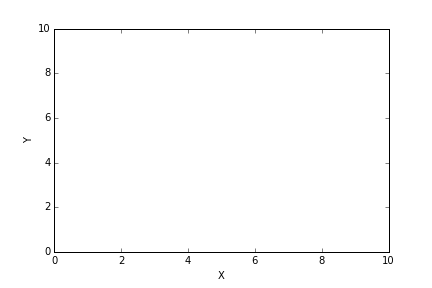
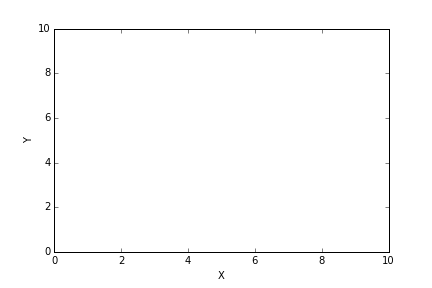
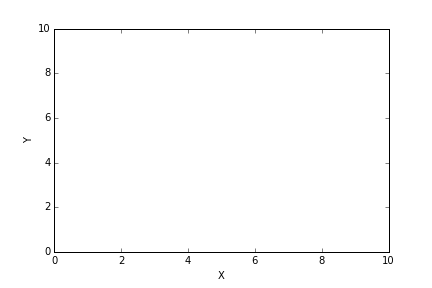
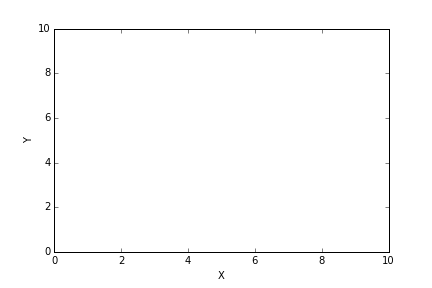
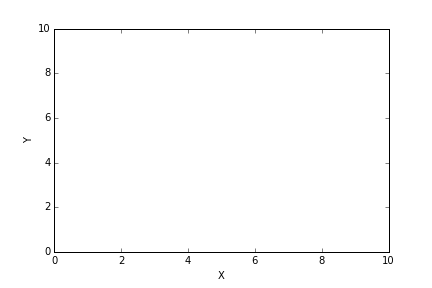
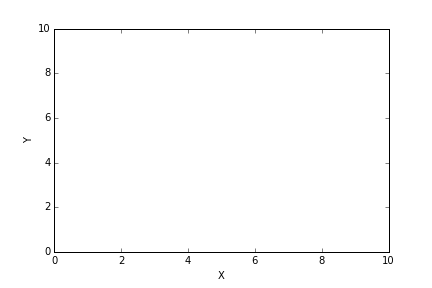
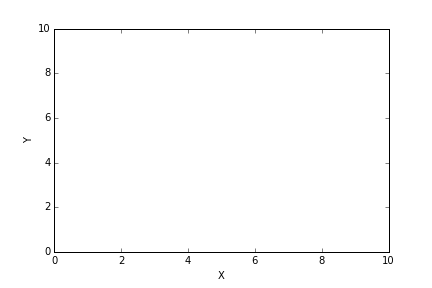
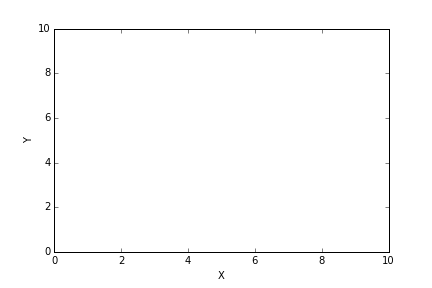
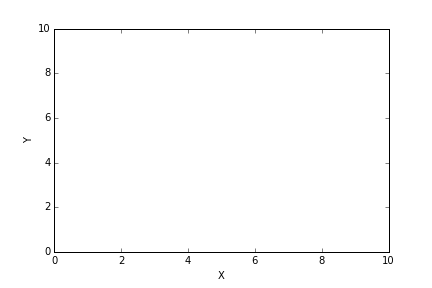
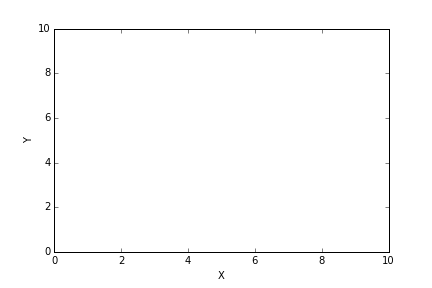
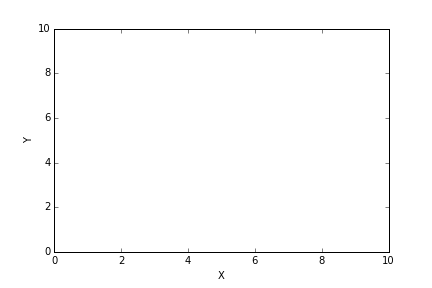
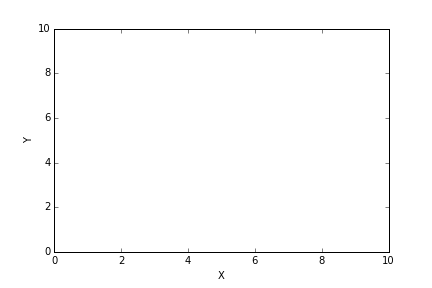
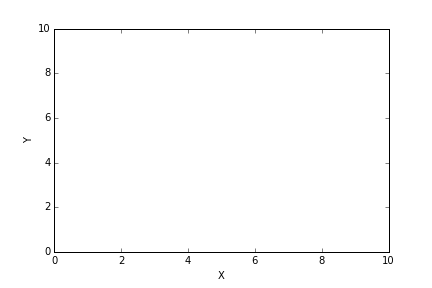
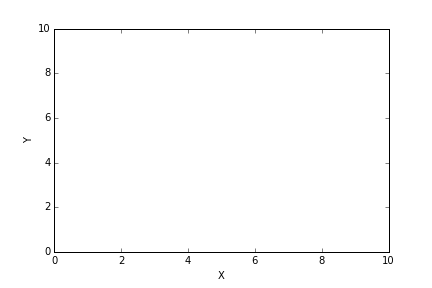
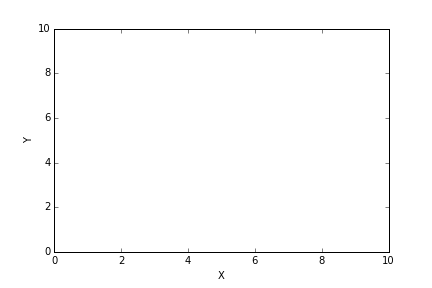
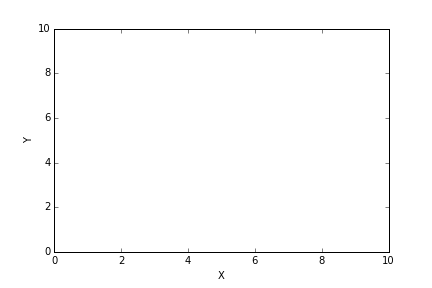
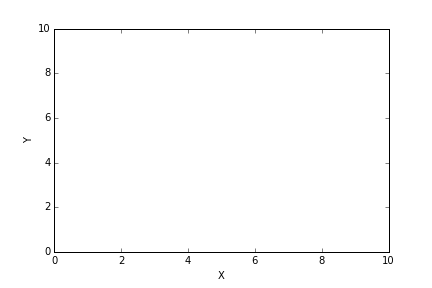
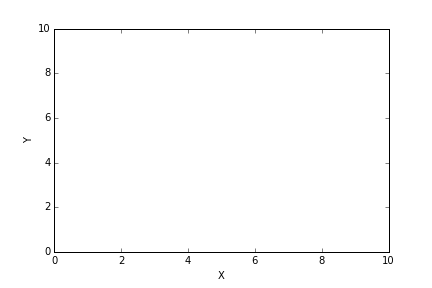
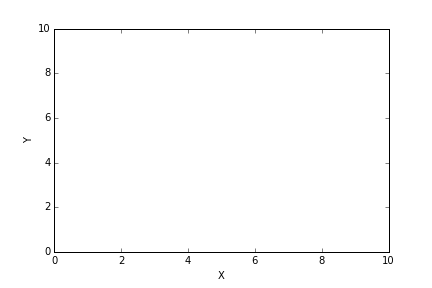
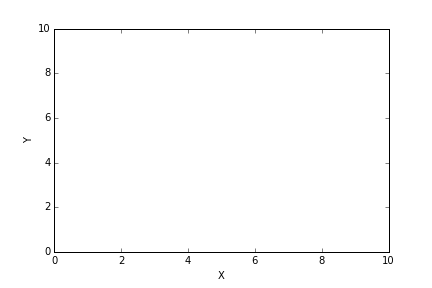
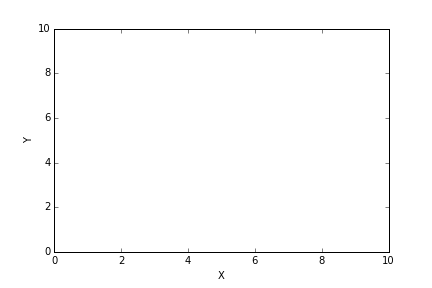
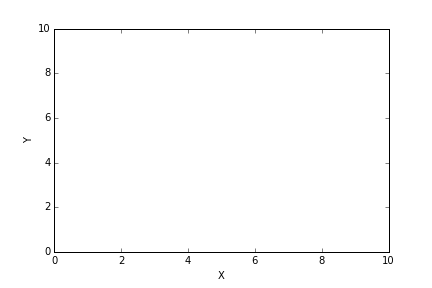
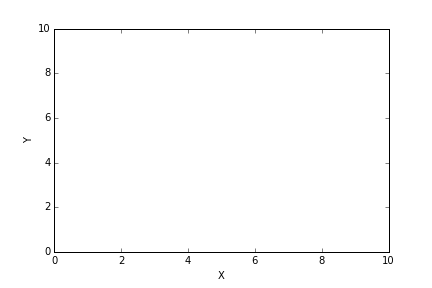
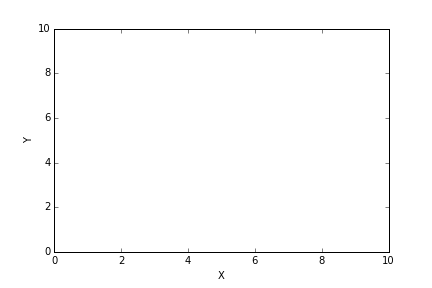
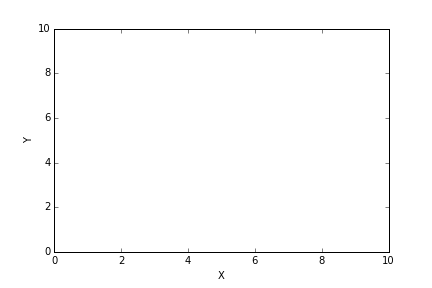
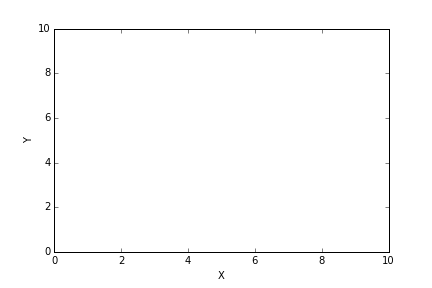
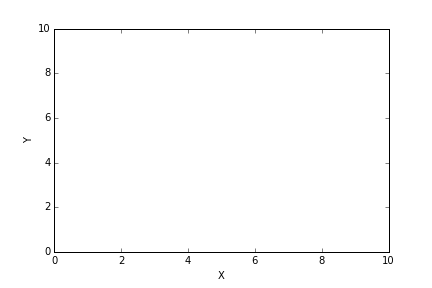
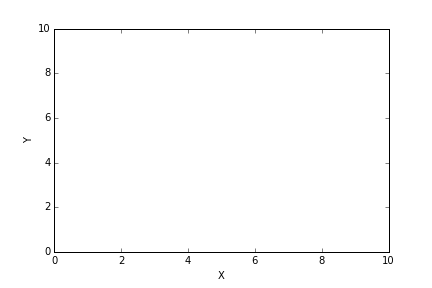
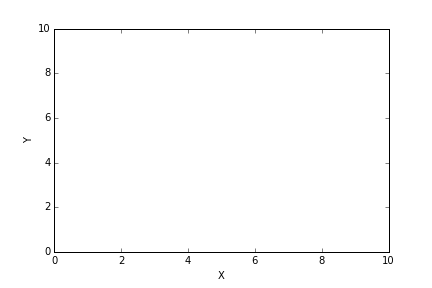
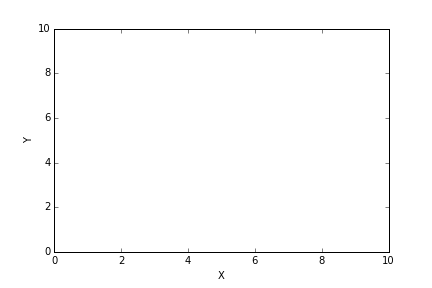
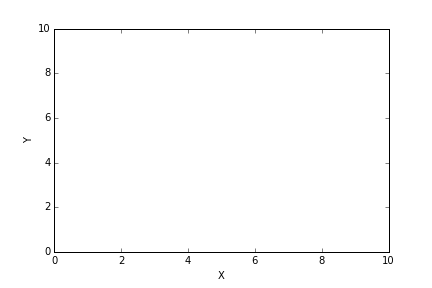
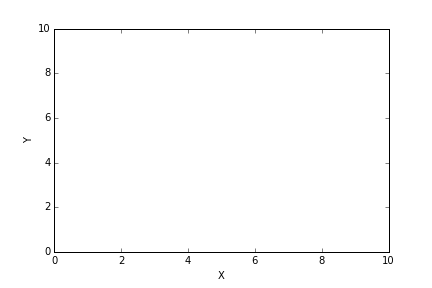
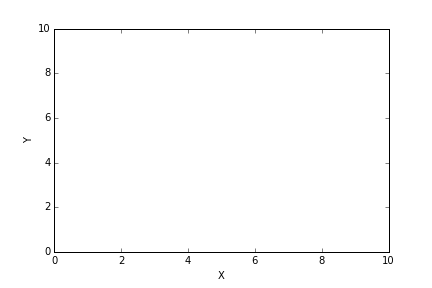
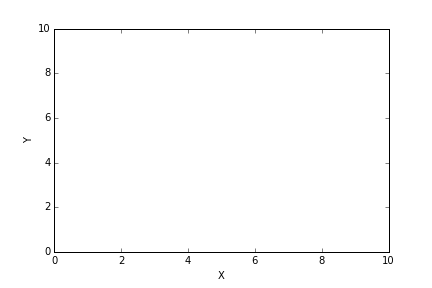
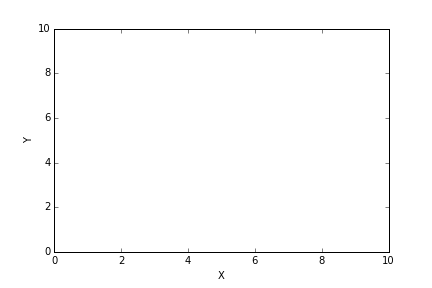
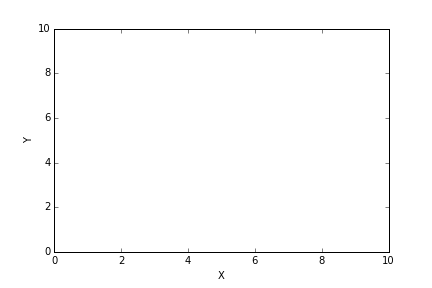
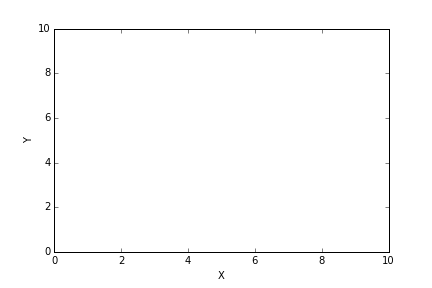
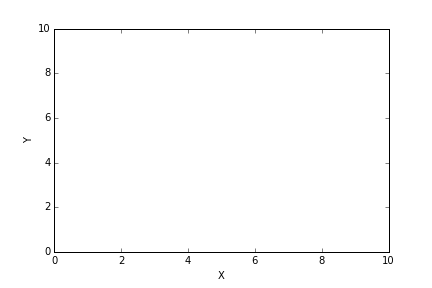
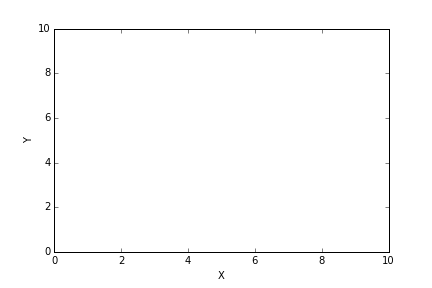
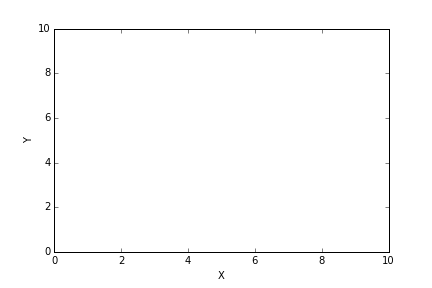
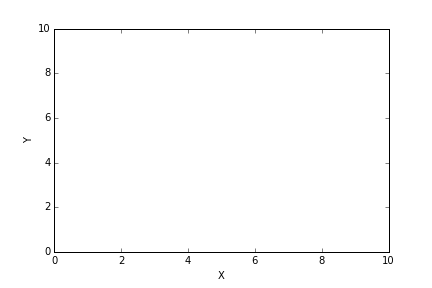
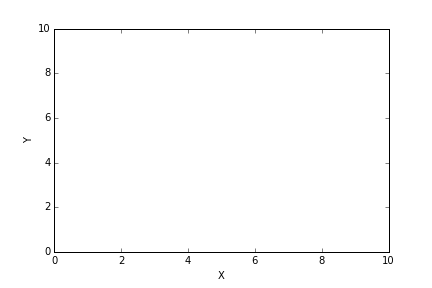
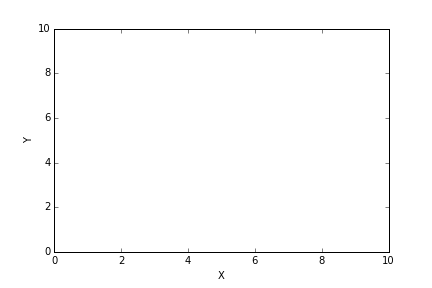
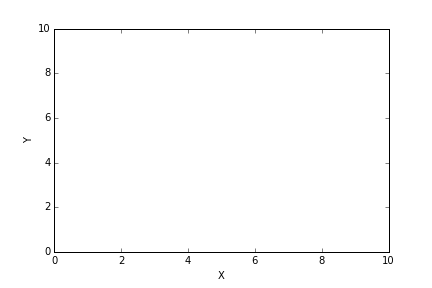
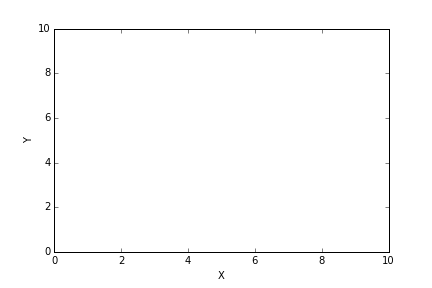
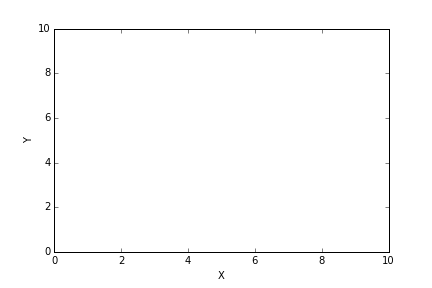
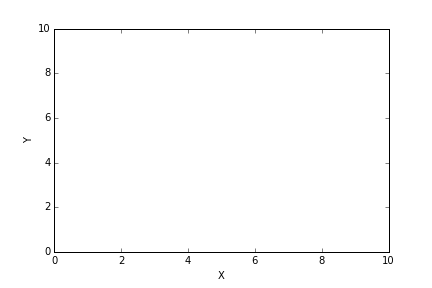
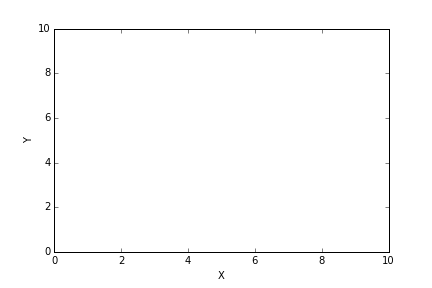
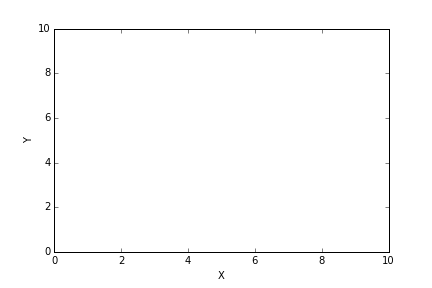
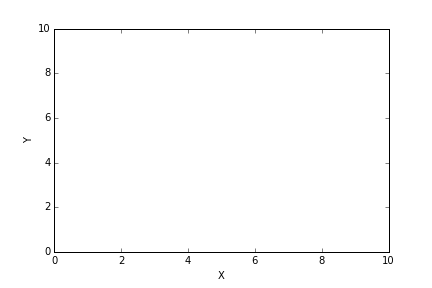
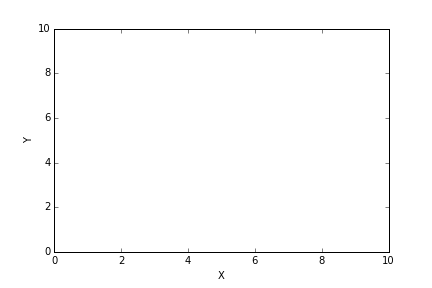
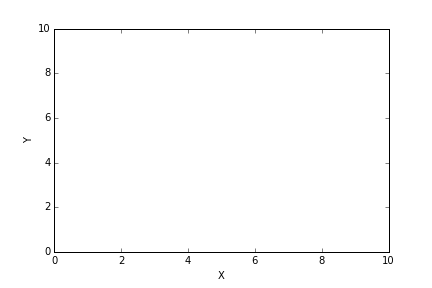
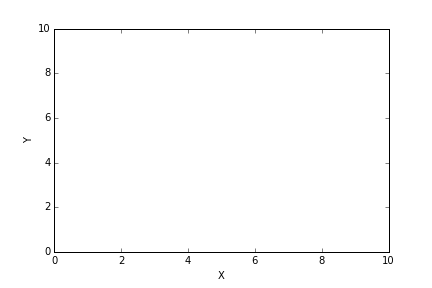
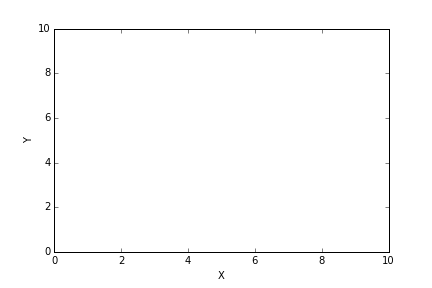
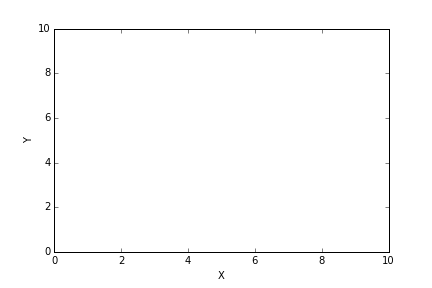
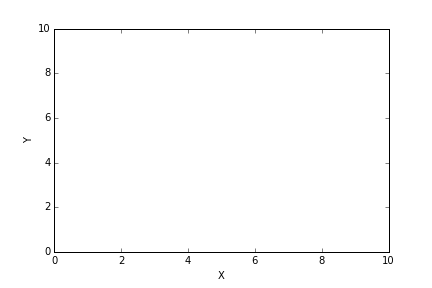
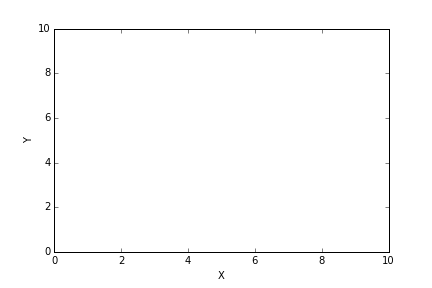
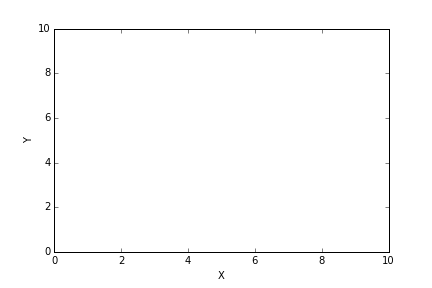
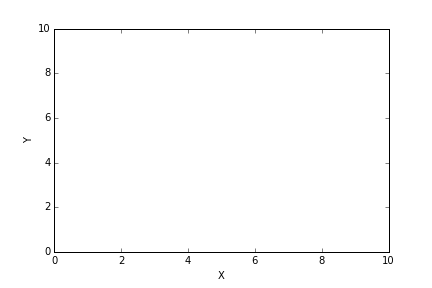
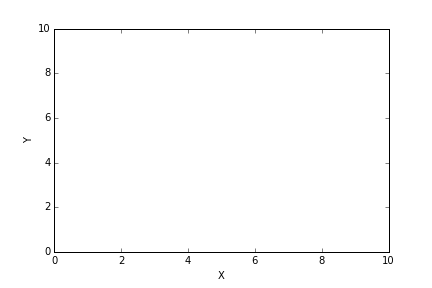
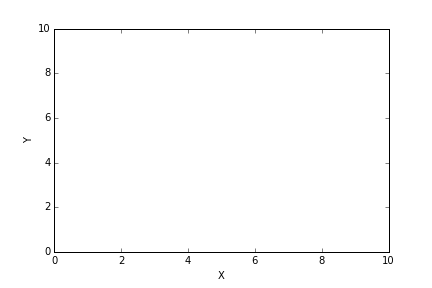
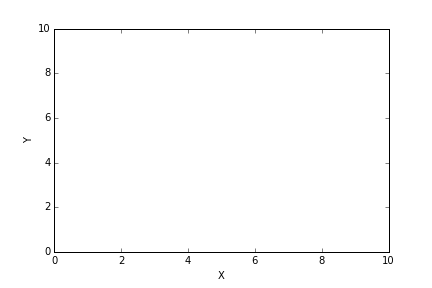
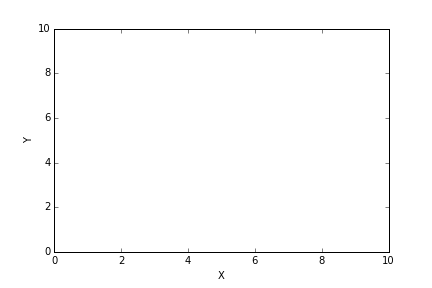
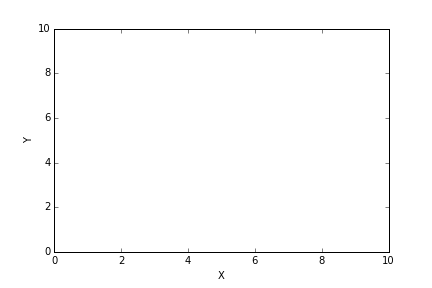
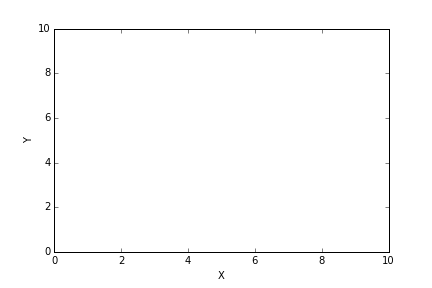
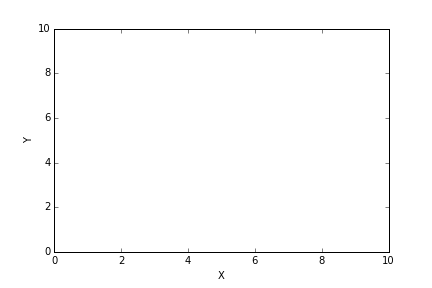
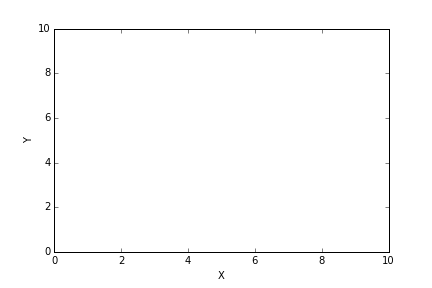
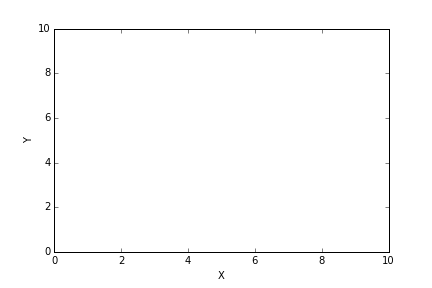
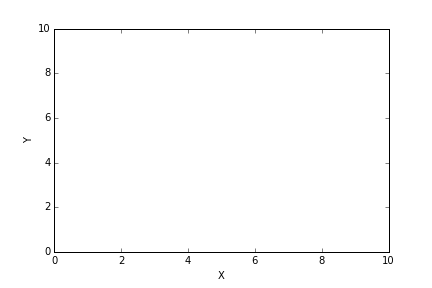
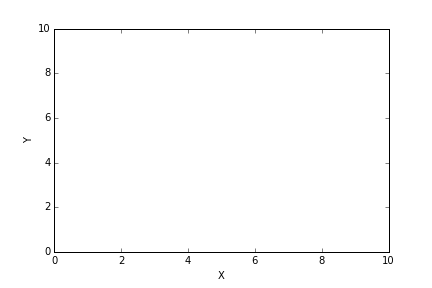
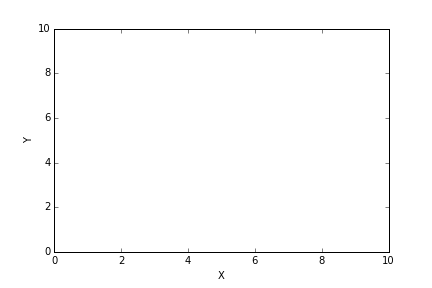
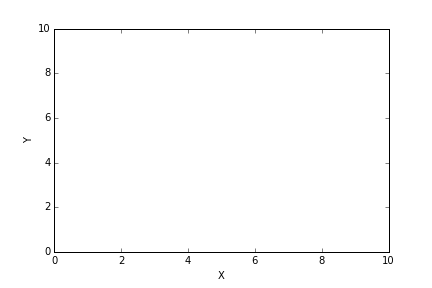
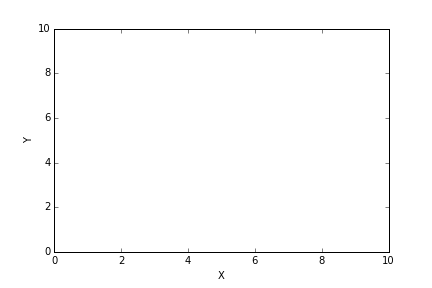
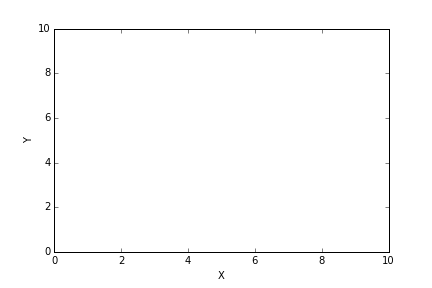
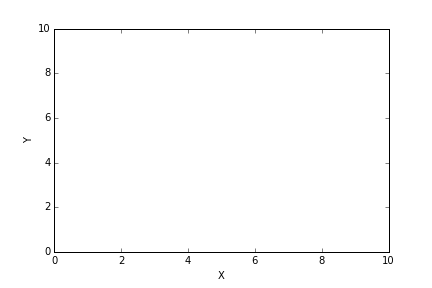
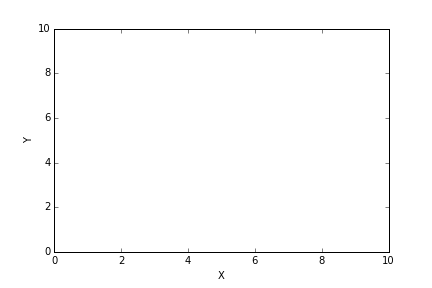
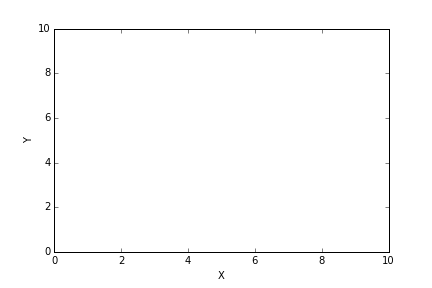
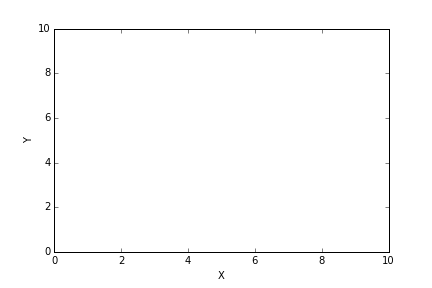
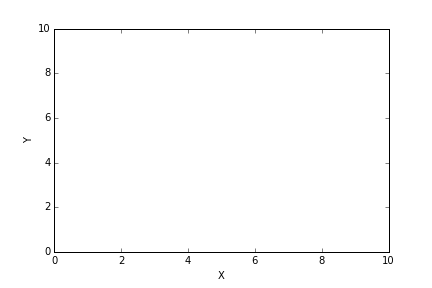
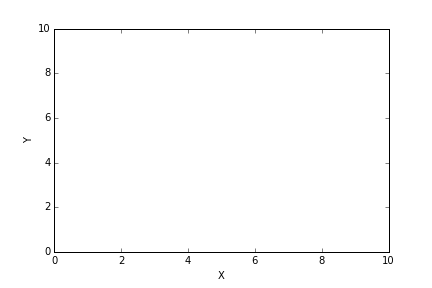
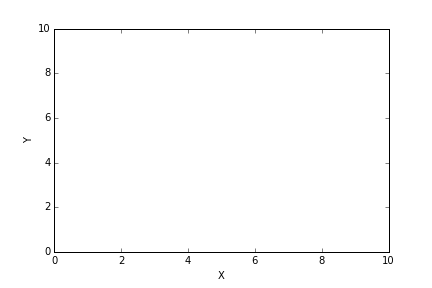
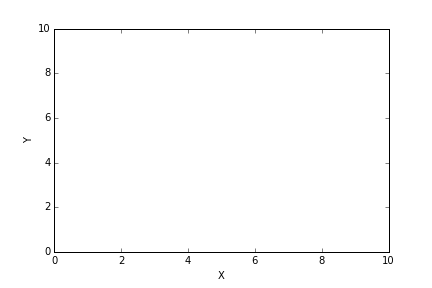
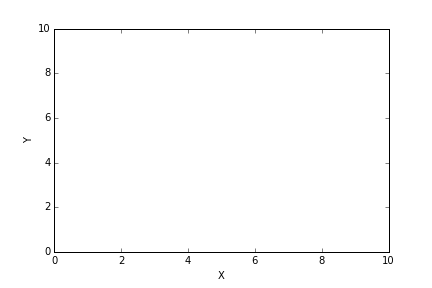
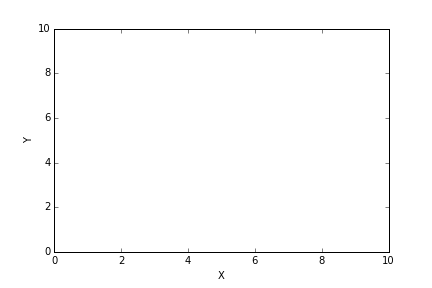

In [7]:
#cell for animation

x = np.zeros(N)
y = np.zeros(N)
fig = pyplot.figure()
ax = pyplot.axes(xlim=(0, lx), ylim=(0, ly), xlabel='X', ylabel='Y')
points, = ax.plot([], [], marker='o', linestyle='None')

def animate(i):
    S.evolve()
    for n in range(S.N):
        p = S.particles[n]
        x[n] = p.x
        y[n] = p.y
    points.set_data(x, y)
    return points


anim = animation.FuncAnimation(fig, animate, frames = 1000, interval=100, blit=True)

display_animation(anim, default_mode='once')

## Exercise 4.2 (Challenge 4.1)

error particle leaving array
error particle leaving array
error particle leaving array
error particle leaving array
error particle leaving array
error particle leaving array
error particle leaving array
error particle leaving array
error particle leaving array
error particle leaving array
error particle leaving array
error particle leaving array
error particle leaving array
error particle leaving array
error particle leaving array
error particle leaving array
error particle leaving array
error particle leaving array
error particle leaving array
error particle leaving array
error particle leaving array
error particle leaving array
error particle leaving array
error particle leaving array
error particle leaving array
error particle leaving array
error particle leaving array
error particle leaving array
error particle leaving array
error particle leaving array
error particle leaving array
error particle leaving array
error particle leaving array
error particle leaving array
error particle

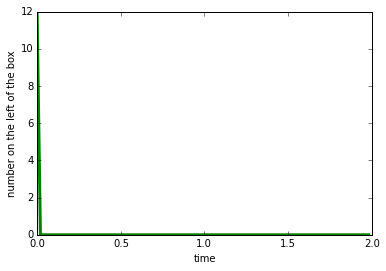

In [106]:
#Cell for initializing a specific experiment
lx = 8.
ly = lx
N = 12
dt = 0.02
vmax = 1.
nsteps = 100
#nequilib=1000

S=system(lx, ly, N, dt, BoundaryCondition.RBC)
S.initconfig(StartConf.Confined, vmax)
#print S.KE
#print S.PE

t = np.zeros(nsteps)
nL = np.zeros(nsteps)

for i in range(0,nsteps):
    S.evolve()
    t[i]=i*dt
    nL[i]=S.NumInArea(0., ly, 0., lx)
    #print "new step"
    
    
#print S.KE
#print S.PE
    
pyplot.plot(t, nL, color='green', ls='-', lw=3)

pyplot.xlabel('time')
pyplot.ylabel('number on the left of the box');